# Our imports

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nba_api.stats.endpoints import leaguegamefinder, BoxScoreAdvancedV3, ShotChartDetail, LeagueDashPlayerStats
import time
from sklearn.metrics import accuracy_score
from scipy.stats import mode

# Data Collection

In [4]:
# Pull games with IDs for the desired season

gamefinder = leaguegamefinder.LeagueGameFinder(season_nullable='2023-24',
                                              league_id_nullable='00',
                                              season_type_nullable='Regular Season')
games = gamefinder.get_data_frames()[0]

# create list of game_ids
game_ids = games['GAME_ID'].unique().tolist()

Connecting to API - only run of you dont have the data saved!

In [6]:
# Data collection

season = "2023-24"  # Replace with the current season

# Collecting all data
all_player_advanced_stats = []
all_shot_data = []
all_traditional_stats = []

# Pull advanced boxscore data
for game_id in game_ids:
    try:
        boxscore = BoxScoreAdvancedV3(game_id=game_id)
        if boxscore.player_stats:
            player_stats_dict = boxscore.player_stats.get_dict()
            if "data" in player_stats_dict and "headers" in player_stats_dict:
                all_player_advanced_stats.extend(player_stats_dict["data"])
        print(f"Advanced stats for game {game_id} pulled successfully.")
        time.sleep(1)  # Respect rate limits
    except Exception as e:
        print(f"Failed to pull advanced stats for game {game_id}: {e}")

# Pull traditional stats using LeagueDashPlayerStats
try:
    leaguedash = LeagueDashPlayerStats(season=season)
    traditional_stats = leaguedash.league_dash_player_stats.get_dict()["data"]
    all_traditional_stats.extend(traditional_stats)
    print("Traditional stats pulled successfully.")
except Exception as e:
    print(f"Failed to pull traditional stats: {e}")

# Extract player and team IDs from advanced stats
if all_player_advanced_stats:
    headers = boxscore.player_stats.get_dict()["headers"]
    person_id_index = headers.index("personId")
    team_id_index = headers.index("teamId")

    player_team_ids = [(stat[person_id_index], stat[team_id_index]) for stat in all_player_advanced_stats]
    player_team_ids = list(set(player_team_ids))  # Remove duplicates
    print(f"Extracted {len(player_team_ids)} unique player-team pairs.")

# Pull shot chart data for all players
for player_id, team_id in player_team_ids:
    try:
        shot_chart = ShotChartDetail(player_id=player_id, team_id=team_id, season_nullable=season)
        if shot_chart.shot_chart_detail:
            shot_chart_data = shot_chart.shot_chart_detail.get_dict()
            if "data" in shot_chart_data:
                all_shot_data.extend(shot_chart_data["data"])
        print(f"Shot chart data for player {player_id} (team {team_id}) pulled successfully.")
        time.sleep(1)  # Respect rate limits
    except Exception as e:
        print(f"Failed to pull shot chart data for player {player_id} (team {team_id}): {e}")

# Convert to DataFrames
df_advanced = pd.DataFrame(all_player_advanced_stats, columns=headers)
df_traditional = pd.DataFrame(all_traditional_stats, columns=leaguedash.league_dash_player_stats.get_dict()["headers"])

if all_shot_data:
    headers_shot = shot_chart.shot_chart_detail.get_dict()["headers"]
    df_shots = pd.DataFrame(all_shot_data, columns=headers_shot)
else:
    df_shots = pd.DataFrame()
    print("No shot chart data available.")

# Save raw data to CSVs (optional)
df_advanced.to_csv("advanced_player_stats.csv", index=False)
df_traditional.to_csv("traditional_player_stats.csv", index=False)
df_shots.to_csv("player_shot_data.csv", index=False)

print("All data pulled and saved successfully.")


Advanced stats for game 0022301194 pulled successfully.
Advanced stats for game 0022301195 pulled successfully.
Advanced stats for game 0022301186 pulled successfully.
Advanced stats for game 0022301188 pulled successfully.
Advanced stats for game 0022301191 pulled successfully.
Advanced stats for game 0022301193 pulled successfully.
Advanced stats for game 0022301196 pulled successfully.
Advanced stats for game 0022301198 pulled successfully.
Advanced stats for game 0022301199 pulled successfully.
Advanced stats for game 0022301190 pulled successfully.
Advanced stats for game 0022301200 pulled successfully.
Advanced stats for game 0022301197 pulled successfully.
Advanced stats for game 0022301192 pulled successfully.
Advanced stats for game 0022301187 pulled successfully.
Advanced stats for game 0022301189 pulled successfully.
Advanced stats for game 0022301181 pulled successfully.
Advanced stats for game 0022301177 pulled successfully.
Advanced stats for game 0022301178 pulled succes

## Datasets

In [8]:
# # Run this cell to pull complete files, adjust file paths

# # Load data from CSV files
df_advanced = pd.read_csv("advanced_player_stats.csv")
df_shots = pd.read_csv("player_shot_data.csv")
df_traditional = pd.read_csv("traditional_player_stats.csv")

In [9]:
# Load only necessary columns from CSV files for memory optimization
columns_advanced = ["personId", "position", "offensiveRating", "defensiveRating", "netRating", "usagePercentage", "pace"]
columns_shots = ["PLAYER_ID", "SHOT_DISTANCE"]
columns_traditional = ["PLAYER_ID", "PLAYER_NAME", "MIN", "FGM", "FGA", "FG3M", "FG3A", "FTM", "FTA", "FG_PCT", "FG3_PCT", "FT_PCT", "REB", "AST", "TOV", "STL", "BLK", "PTS", "PLUS_MINUS"]

df_advanced = pd.read_csv("advanced_player_stats.csv", usecols=columns_advanced)
df_shots = pd.read_csv("player_shot_data.csv", usecols=columns_shots)
df_traditional = pd.read_csv("traditional_player_stats.csv", usecols=columns_traditional)

# Rename columns
df_advanced.rename(columns={"personId": "PLAYER_ID"}, inplace=True)

## EDI and Data Manupilation

In [11]:
# Rename 'personId' to 'PLAYER_ID' in df_advanced
df_advanced.rename(columns={"personId": "PLAYER_ID"}, inplace=True)

# Only include players with more than 800 minutes in the season
df_traditional = df_traditional[df_traditional["MIN"] > 800]

Including clutch stats and lineup stats to enhance features

In [13]:
from nba_api.stats.endpoints import LeagueDashPlayerClutch, LeagueDashLineups, LeagueDashTeamStats

# Fetch clutch stats
clutch_stats = LeagueDashPlayerClutch(season="2023-24", clutch_time="Last 5 Minutes").get_data_frames()[0]

# Fetch lineup stats
lineup_stats = LeagueDashLineups(season="2023-24").get_data_frames()[0]

Developing final table set. Grouping by player and averaging

In [15]:
combined_stats = pd.merge(clutch_stats, lineup_stats, on="TEAM_ID", how="inner")

In [16]:
# Merge data
df_combined = pd.merge(df_advanced, df_traditional, on="PLAYER_ID", how="inner")
df_combined = pd.merge(df_combined, df_shots, on="PLAYER_ID", how="inner")
df_combined = df_combined.groupby('PLAYER_ID', as_index=False).first()

df_combined

PLAYER_ID position  offensiveRating  defensiveRating  netRating  \
0         2544        F            128.4            109.0       19.4   
1       101108        G            116.7            139.6      -22.9   
2       200768        G            110.2             75.5       34.7   
3       201142        F            139.2            102.8       36.4   
4       201143        F            106.3            157.6      -51.3   
..         ...      ...              ...              ...        ...   
297    1641731        G              0.0              0.0        0.0   
298    1641739        F            112.3            112.3        0.0   
299    1641764        G            131.1            106.8       24.3   
300    1641767        F            156.9            125.4       31.5   
301    1641871        C             77.4            129.6      -52.3   

     usagePercentage    pace         PLAYER_NAME          MIN  FGM  ...  FTA  \
0              0.299  101.26        LeBron James  2503.683333  685  ...  404   
1              0.220  101.57          Chris Paul  1530.890000  206  ...   52   
2              0.069  101.38          Kyle Lowry  1689.766667  163  ...   75   
3              0.218   92.56        Kevin Durant  2790.636667  751  ...  423   
4              0.121  100.47          Al Horford  1739.796667  214  ...   30   
..               ...     ...                 ...          ...  ...  ...  ...   
297            0.000    0.00     Bilal Coulibaly  1715.250000  188  ...  131   
298            0.155  103.00      Toumani Camara  1739.320000  197  ...   99   
299            0.127   99.58  Brandin Podziemski  1968.253333  271  ...   79   
300            0.088  110.12        Ben Sheppard   814.260000   90  ...   26   
301            0.222  106.34          Duop Reath  1214.115000  230  ...   93   

     FT_PCT  REB  AST  TOV  STL  BLK   PTS  PLUS_MINUS  SHOT_DISTANCE  
0     0.750  518  589  245   89   38  1822         218              0  
1     0.827  225  393   76   70    6   533         110             20  
2     0.840  194  253   85   59   21   487           2              1  
3     0.856  495  378  244   69   91  2032         291              2  
4     0.867  413  168   48   38   62   562         421              5  
..      ...  ...  ...  ...  ...  ...   ...         ...            ...  
297   0.702  256  110   87   57   48   532        -419              3  
298   0.758  343   87   84   66   33   527        -189              0  
299   0.633  427  273   88   61   14   682         264              5  
300   0.885   89   53   15   33    2   252          69             22  
301   0.742  250   67   52   33   38   617        -188             25  

[302 rows x 26 columns]

In [17]:
duplicated_ids = df_combined['PLAYER_ID'][df_combined['PLAYER_ID'].duplicated()].unique()

print(f"Duplicated PLAYER_IDs: {duplicated_ids}")

Duplicated PLAYER_IDs: []


In [18]:
# Select only numeric columns (excluding PLAYER_ID)
numeric_columns = combined_stats.select_dtypes(include='number').columns

# Group by PLAYER_ID and calculate the mean for numeric columns
aggregated_stats = combined_stats.groupby("PLAYER_ID")[numeric_columns].mean()

# If PLAYER_ID is already a column, avoid resetting the index
if 'PLAYER_ID' not in aggregated_stats.columns:
    aggregated_stats = aggregated_stats.reset_index()

# Check the shape and structure of the aggregated DataFrame
print(aggregated_stats.shape)
print(aggregated_stats.head())


(469, 115)
           PLAYER_ID       TEAM_ID   AGE  GP_x   W_x   L_x  W_PCT_x  \
PLAYER_ID                                                             
2544          2544.0  1.610613e+09  39.0  28.0  19.0   9.0    0.679   
101108      101108.0  1.610613e+09  39.0  28.0  14.0  14.0    0.500   
200768      200768.0  1.610613e+09  38.0  25.0  14.0  11.0    0.560   
200782      200782.0  1.610613e+09  39.0   5.0   1.0   4.0    0.200   
201142      201142.0  1.610613e+09  35.0  39.0  18.0  21.0    0.462   

                MIN_x  FGM_x  FGA_x  ...   REB_RANK_y   AST_RANK_y  \
PLAYER_ID                            ...                             
2544       115.666667   36.0   68.0  ...  1073.986301  1034.109589   
101108      61.851667    7.0   17.0  ...  1034.000000   908.493506   
200768      75.498333    9.0   21.0  ...  1100.909091  1179.393939   
200782      14.311667    0.0    0.0  ...   896.114286  1012.771429   
201142     138.270000   30.0   84.0  ...  1064.258065  1121.451613   



In [19]:
# Drop PLAYER_ID from the index if it's redundant
aggregated_stats = aggregated_stats.reset_index(drop=True)

# Perform the merge
df_combined = df_combined.merge(aggregated_stats, on="PLAYER_ID", how="inner")


In [20]:
# Select only numeric columns (excluding PLAYER_ID)
numeric_columns = df_combined.select_dtypes(include='number').columns

# Group by PLAYER_ID and calculate the mean for numeric columns
aggregated_stats = df_combined.groupby("PLAYER_ID")[numeric_columns].mean()

# Reset the index and ensure PLAYER_ID is not duplicated
if 'PLAYER_ID' not in aggregated_stats.columns:
    aggregated_stats = aggregated_stats.reset_index()

# Check the shape and structure of the aggregated DataFrame
print(aggregated_stats.shape)
print(aggregated_stats.head())


(302, 138)
           PLAYER_ID  offensiveRating  defensiveRating  netRating  \
PLAYER_ID                                                           
2544          2544.0            128.4            109.0       19.4   
101108      101108.0            116.7            139.6      -22.9   
200768      200768.0            110.2             75.5       34.7   
201142      201142.0            139.2            102.8       36.4   
201143      201143.0            106.3            157.6      -51.3   

           usagePercentage    pace          MIN    FGM     FGA  FG_PCT  ...  \
PLAYER_ID                                                               ...   
2544                 0.299  101.26  2503.683333  685.0  1269.0   0.540  ...   
101108               0.220  101.57  1530.890000  206.0   467.0   0.441  ...   
200768               0.069  101.38  1689.766667  163.0   377.0   0.432  ...   
201142               0.218   92.56  2790.636667  751.0  1436.0   0.523  ...   
201143               0.121  100

In [21]:
names = df_traditional[['PLAYER_ID','PLAYER_NAME']]

In [22]:
df_combined = df_combined.merge(names, on='PLAYER_ID', how='left')

In [23]:
df_combined

PLAYER_ID position  offensiveRating  defensiveRating  netRating  \
0         2544        F            128.4            109.0       19.4   
1       101108        G            116.7            139.6      -22.9   
2       200768        G            110.2             75.5       34.7   
3       201142        F            139.2            102.8       36.4   
4       201143        F            106.3            157.6      -51.3   
..         ...      ...              ...              ...        ...   
297    1641731        G              0.0              0.0        0.0   
298    1641739        F            112.3            112.3        0.0   
299    1641764        G            131.1            106.8       24.3   
300    1641767        F            156.9            125.4       31.5   
301    1641871        C             77.4            129.6      -52.3   

     usagePercentage    pace       PLAYER_NAME_x          MIN  FGM  ...  \
0              0.299  101.26        LeBron James  2503.683333  685  ...   
1              0.220  101.57          Chris Paul  1530.890000  206  ...   
2              0.069  101.38          Kyle Lowry  1689.766667  163  ...   
3              0.218   92.56        Kevin Durant  2790.636667  751  ...   
4              0.121  100.47          Al Horford  1739.796667  214  ...   
..               ...     ...                 ...          ...  ...  ...   
297            0.000    0.00     Bilal Coulibaly  1715.250000  188  ...   
298            0.155  103.00      Toumani Camara  1739.320000  197  ...   
299            0.127   99.58  Brandin Podziemski  1968.253333  271  ...   
300            0.088  110.12        Ben Sheppard   814.260000   90  ...   
301            0.222  106.34          Duop Reath  1214.115000  230  ...   

      AST_RANK_y    TOV_RANK_y   STL_RANK_y   BLK_RANK_y   BLKA_RANK_y  \
0    1034.109589  14167.027397  1366.534247  1640.027397  12346.328767   
1     908.493506  14432.129870  1426.753247  1720.935065  11576.337662   
2    1179.393939  13572.651515  1270.348485  1173.969697  12331.227273   
3    1121.451613  14510.209677  1205.451613  1269.403226  11426.016129   
4    1134.971014  13218.507246  1470.840580  1374.652174  10881.927536   
..           ...           ...          ...          ...           ...   
297   993.500000  14092.883333  1528.150000  1674.300000  12014.416667   
298  1362.716216  14315.405405  1668.581081  2126.729730  12953.905405   
299   908.493506  14432.129870  1426.753247  1720.935065  11576.337662   
300  1025.805970  13788.671642  1455.686567  1422.000000  12482.343284   
301  1362.716216  14315.405405  1668.581081  2126.729730  12953.905405   

        PF_RANK_y   PFD_RANK_y   PTS_RANK_y  PLUS_MINUS_RANK_y  \
0    13849.164384  1065.835616  1005.712329        6139.520548   
1    14520.766234  1320.246753   948.454545        7256.285714   
2    14683.863636  1488.818182  1046.439394        6966.757576   
3    14119.983871  1124.064516  1038.919355        5410.080645   
4    13507.492754  1501.028986  1037.666667        4512.942029   
..            ...          ...          ...                ...   
297  14353.700000  1202.633333  1036.100000        9690.650000   
298  14331.945946  1283.567568  1212.770270        9329.824324   
299  14520.766234  1320.246753   948.454545        7256.285714   
300  14760.537313  1386.686567  1043.895522        6458.776119   
301  14331.945946  1283.567568  1212.770270        9329.824324   

          PLAYER_NAME_y  
0          LeBron James  
1            Chris Paul  
2            Kyle Lowry  
3          Kevin Durant  
4            Al Horford  
..                  ...  
297     Bilal Coulibaly  
298      Toumani Camara  
299  Brandin Podziemski  
300        Ben Sheppard  
301          Duop Reath  

[302 rows x 141 columns]

## Feature Selection

In [25]:
# Select relevant numeric features
features = [
    "FGM", "FGA", "FG_PCT",        # Field goal metrics
    "FG3M", "FG3A", "FG3_PCT",     # Three-point shooting metrics
    "FTM", "FTA", "FT_PCT",        # Free throw metrics
    "PTS", "PLUS_MINUS",           # Points scored and impact metrics
    
    # Defensive Features
    "STL", "BLK",                  # Steals and blocks for defense
    "OREB_x", "DREB_x", "REB",         # Rebounding metrics
    "PF_x", "BLKA_x",                  # Personal fouls and blocks against
    
    # Playmaking Features
    "AST", "TOV",                  # Assists and turnovers
    "usagePercentage",             # Usage percentage
    "netRating", "offensiveRating", "defensiveRating",  # Efficiency ratings
    
    # Optional Contextual Metrics
    "pace",                        # Game pace
    "SHOT_DISTANCE",               # Average shot distance
]
df_features = df_combined[features].dropna()  # Drop rows with missing data

# Scale the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_features)

Using PCA for dimensionality reduction

In [27]:
# PCA for dimensionality reduction
pca = PCA(n_components=2)
df_pca = pd.DataFrame(pca.fit_transform(df_scaled), columns=["PC1", "PC2"])

# Experimenting Differnt Models - KMeans, PCA, Minibatch, 

### KMeans

C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


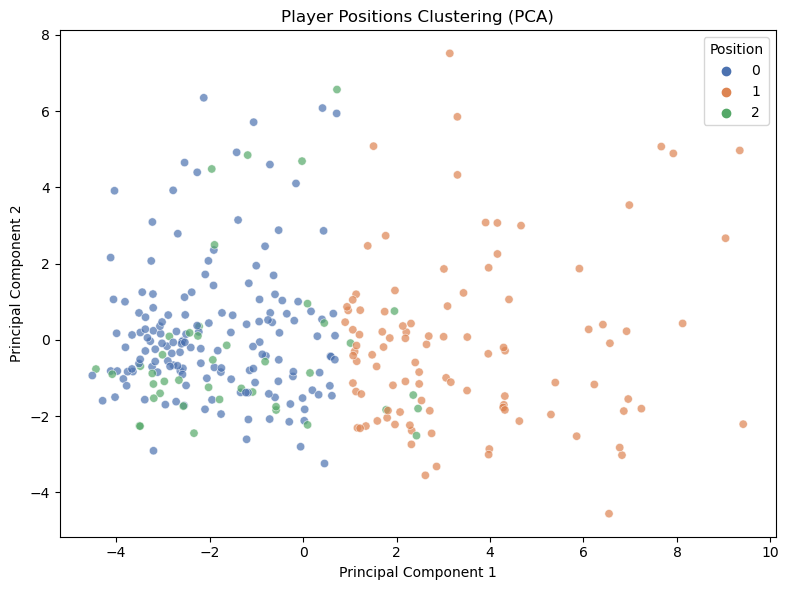

Position clustering results saved successfully.


In [30]:
# Initial clustering to identify positions
kmeans_positions = KMeans(n_clusters=3, random_state=42)
df_pca["Position"] = kmeans_positions.fit_predict(df_scaled)

# Plot PCA with positions
plt.figure(figsize=(8, 6))
sns.scatterplot(x="PC1", y="PC2", hue="Position", data=df_pca, palette="deep", alpha=0.7)
plt.title("Player Positions Clustering (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Position")
plt.tight_layout()
plt.show()

# Save position clustering results
df_pca["PLAYER_ID"] = df_combined["PLAYER_ID"].values
df_pca.to_csv("player_positions.csv", index=False)
print("Position clustering results saved successfully.")



### PCA & Minibatch

C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


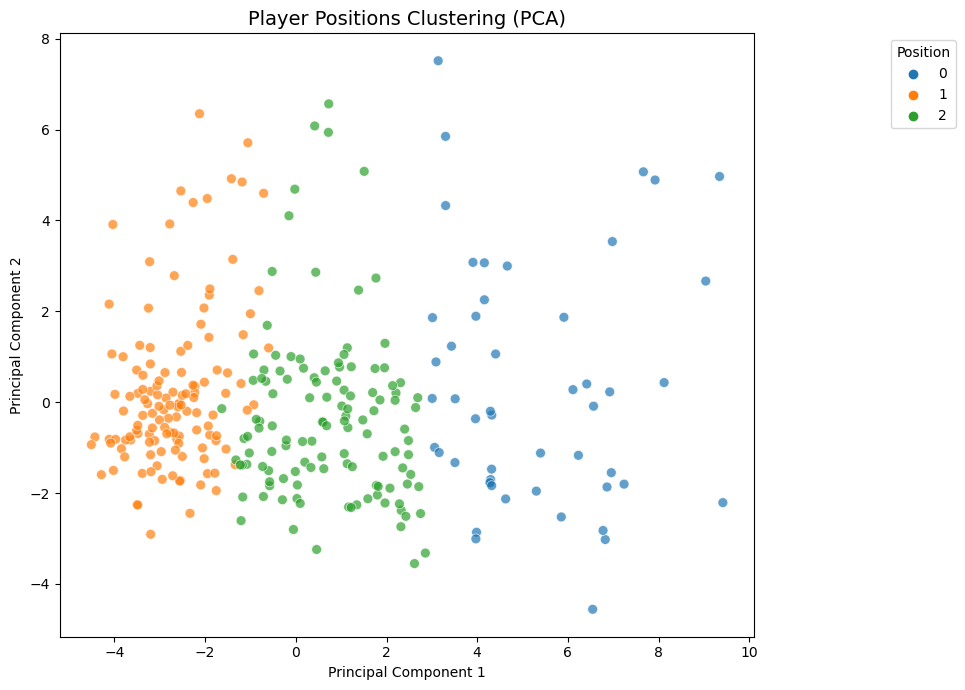

PCA Explained Variance (%): [35.69328399 15.25298784]
Optimized position clustering results and metadata saved successfully.


In [32]:
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Function to perform PCA and clustering
def perform_pca_clustering(data_scaled, original_df, n_clusters=3):
    """
    Perform PCA for dimensionality reduction and cluster using MiniBatchKMeans.
    Parameters:
        - data_scaled: Scaled feature matrix (numpy array or DataFrame)
        - original_df: Original DataFrame for adding PLAYER_ID
        - n_clusters: Number of clusters for MiniBatchKMeans
    Returns:
        - pca_data: DataFrame with PCA components and cluster assignments
        - pca: Trained PCA model
        - kmeans: Trained MiniBatchKMeans model
    """
    # PCA for dimensionality reduction
    pca = PCA(n_components=2)
    pca_data = pd.DataFrame(pca.fit_transform(data_scaled), columns=["PC1", "PC2"])
    
    # Clustering with MiniBatchKMeans
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=100)
    pca_data["Position"] = kmeans.fit_predict(data_scaled)
    
    # Add PLAYER_ID back for reference
    pca_data["PLAYER_ID"] = original_df["PLAYER_ID"].values
    
    return pca_data, pca, kmeans

# Function to plot PCA clusters
def plot_clusters(pca_data):
    """
    Visualize clustering results with PCA components.
    Parameters:
        - pca_data: DataFrame with PCA components and cluster assignments
    """
    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        x="PC1", y="PC2", hue="Position", data=pca_data,
        palette="tab10", alpha=0.7, s=50
    )
    plt.title("Player Positions Clustering (PCA)", fontsize=14)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title="Position", loc='upper right', bbox_to_anchor=(1.3, 1))
    plt.tight_layout()
    plt.show()

# Perform clustering and plot results
pca_results, pca_model, kmeans_model = perform_pca_clustering(df_scaled, df_combined)

# Plot PCA clusters
plot_clusters(pca_results)

# Save clustering results
pca_results.to_csv("player_positions_optimized.csv", index=False)

# Save explained variance as metadata
explained_variance = pca_model.explained_variance_ratio_ * 100
print(f"PCA Explained Variance (%): {explained_variance}")

# Save explained variance to a text file
with open("pca_metadata.txt", "w") as f:
    f.write("PCA Explained Variance (%):\n")
    f.write(", ".join([f"{var:.2f}" for var in explained_variance]))

print("Optimized position clustering results and metadata saved successfully.")


In [33]:
# Add Position to df_combined
df_combined["Position"] = df_pca["Position"]

# Visualizations for Initial Feature Selection

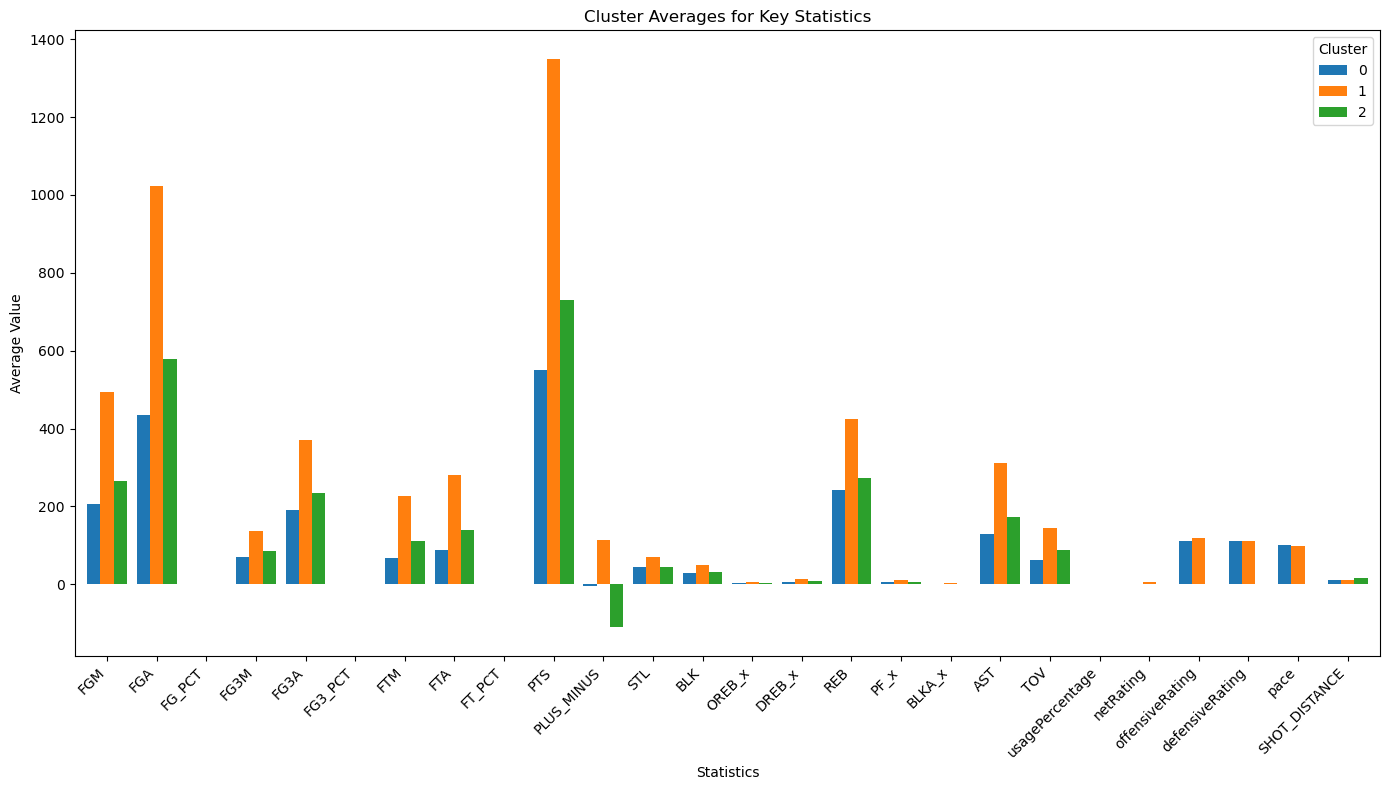

In [35]:
# Cluster statistics visualization
stats = [
    "FGM", "FGA", "FG_PCT",        # Field goal metrics
    "FG3M", "FG3A", "FG3_PCT",     # Three-point shooting metrics
    "FTM", "FTA", "FT_PCT",        # Free throw metrics
    "PTS", "PLUS_MINUS",           # Points scored and impact metrics
    
    # Defensive Features
    "STL", "BLK",                  # Steals and blocks for defense
    "OREB_x", "DREB_x", "REB",         # Rebounding metrics
    "PF_x", "BLKA_x",                  # Personal fouls and blocks against
    
    # Playmaking Features
    "AST", "TOV",                  # Assists and turnovers
    "usagePercentage",             # Usage percentage
    "netRating", "offensiveRating", "defensiveRating",  # Efficiency ratings
    
    # Optional Contextual Metrics
    "pace",                        # Game pace
    "SHOT_DISTANCE",               # Average shot distance
]
cluster_averages = df_combined.groupby("Position")[stats].mean()

cluster_averages.T.plot(kind="bar", figsize=(14, 8), width=0.8)
plt.title("Cluster Averages for Key Statistics")
plt.ylabel("Average Value")
plt.xlabel("Statistics")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Cluster", loc="upper right")
plt.tight_layout()
plt.show()

### Determining position by percentage of each for each cluster

Percentage of Players from Each Position in Each Cluster:
Position          0          1          2
position                                 
C         30.810093  53.696326  15.493581
F         33.347395  54.018140  12.634465
G         29.957627  57.097458  12.944915


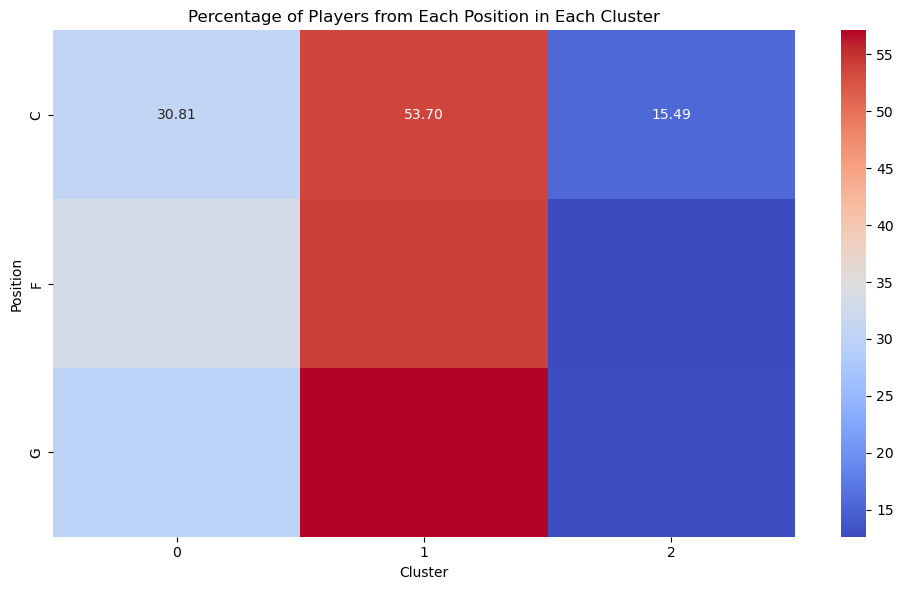

In [37]:
# Position-to-cluster analysis
df_position_cluster = pd.merge(
    df_advanced[["PLAYER_ID", "position"]],
    df_combined[["PLAYER_ID", "Position"]],
    on="PLAYER_ID",
    how="inner"
)
position_cluster_counts = df_position_cluster.groupby(["position", "Position"]).size().unstack(fill_value=0)
position_cluster_percentages = position_cluster_counts.div(position_cluster_counts.sum(axis=1), axis=0) * 100

# Display the percentage table
print("Percentage of Players from Each Position in Each Cluster:")
print(position_cluster_percentages)

# Display the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(position_cluster_percentages, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Percentage of Players from Each Position in Each Cluster")
plt.ylabel("Position")
plt.xlabel("Cluster")
plt.tight_layout()
plt.show()

### Closest players to center of each centroid

In [39]:
# Calculate distances of each player to cluster centroids
distances_to_centroids = kmeans_positions.transform(df_scaled)

# Find the player closest to each centroid
position_cluster_centers = {}

for cluster_label in range(kmeans_positions.n_clusters):
    cluster_indices = np.where(df_pca["Position"] == cluster_label)[0]
    cluster_distances = distances_to_centroids[cluster_indices, cluster_label]
    closest_player_index = cluster_indices[np.argmin(cluster_distances)]
    closest_player_id = df_combined.iloc[closest_player_index]["PLAYER_NAME_x"]
    closest_player_name = df_combined.iloc[closest_player_index]["PLAYER_NAME_x"]

    position_cluster_centers[cluster_label] = closest_player_name

# Display the names of players closest to each cluster centroid
print("Closest players to each position cluster centroid:")
for cluster_label, player_name in position_cluster_centers.items():
    print(f"Cluster {cluster_label}: {player_name}")


Closest players to each position cluster centroid:
Cluster 0: Terance Mann
Cluster 1: Austin Reaves
Cluster 2: Vince Williams Jr.


### Experimenting Using Models to Identify Archetypes Within Each Position

### KMeans

C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


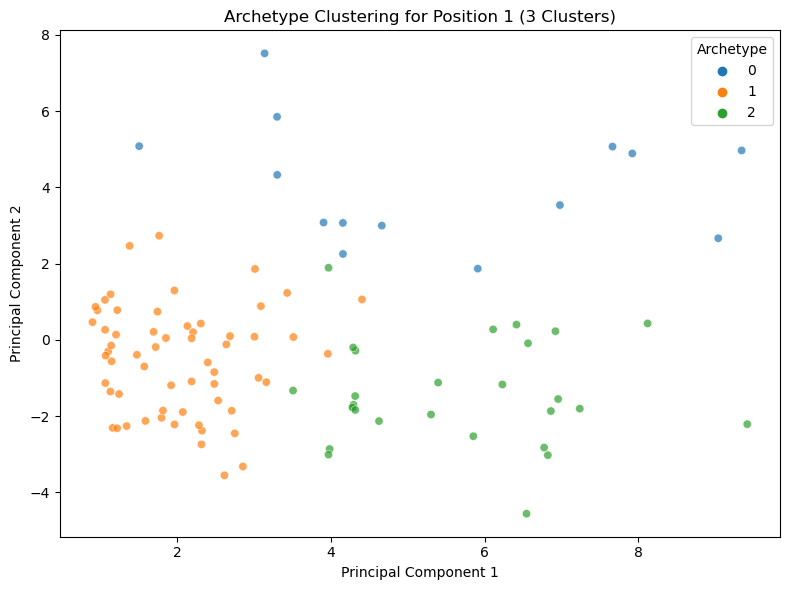

C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


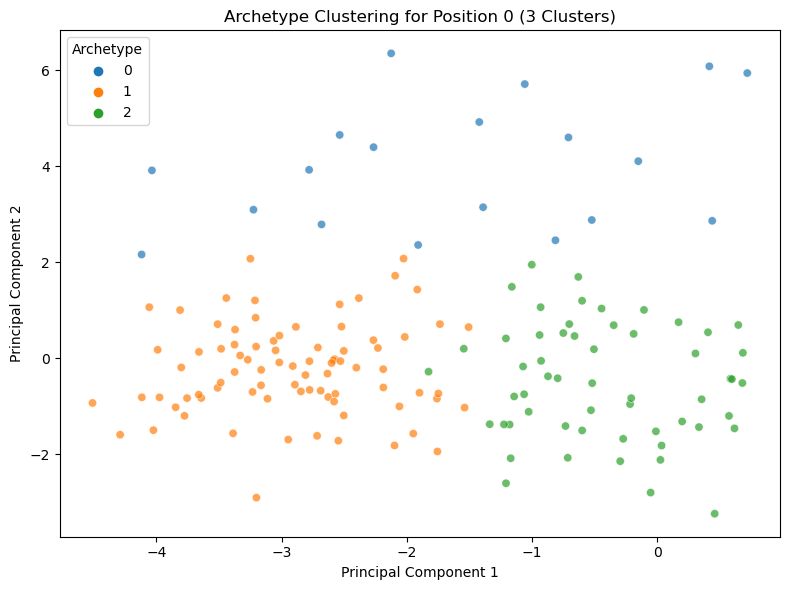

C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


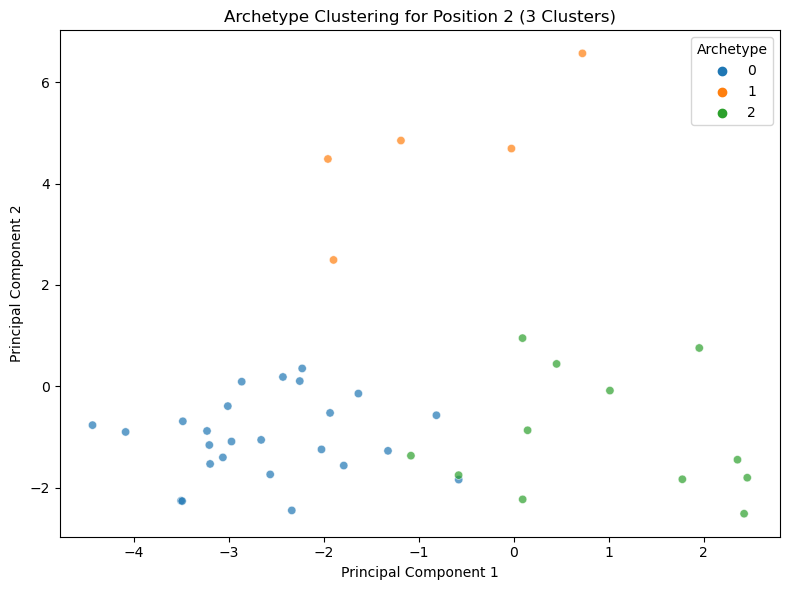

Archetype clustering results saved successfully.


In [42]:
# Archetype clustering for each position
for position in df_pca["Position"].unique():
    subset_indices = df_pca[df_pca["Position"] == position].index
    subset_data = df_scaled[subset_indices]

    kmeans_archetypes = KMeans(n_clusters=3, random_state=42)
    archetype_labels = kmeans_archetypes.fit_predict(subset_data)

    df_pca.loc[subset_indices, "Archetype"] = archetype_labels

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=df_pca.loc[subset_indices, "PC1"],
        y=df_pca.loc[subset_indices, "PC2"],
        hue=archetype_labels,
        palette="tab10",
        alpha=0.7
    )
    plt.title(f"Archetype Clustering for Position {position} (3 Clusters)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title="Archetype")
    plt.tight_layout()
    plt.show()

# Save archetype results
df_pca.to_csv("player_archetypes.csv", index=False)
print("Archetype clustering results saved successfully.")

### Minibatch

C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


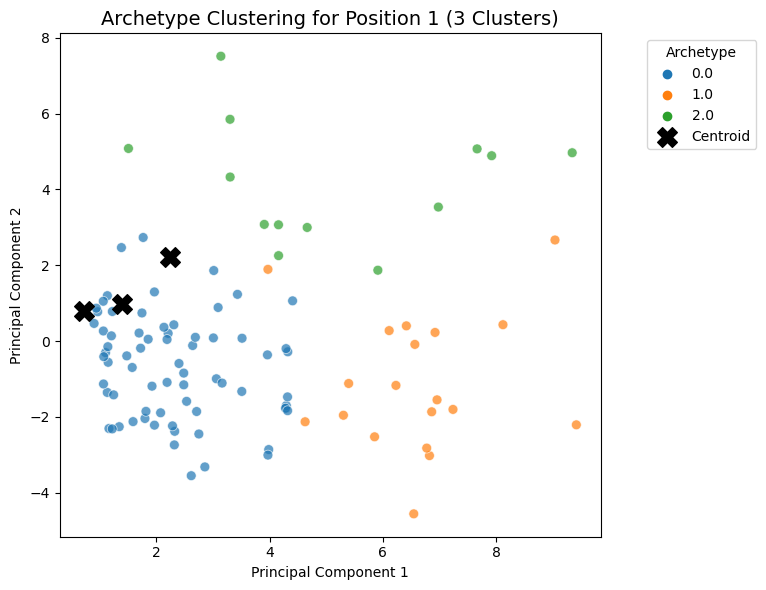

C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


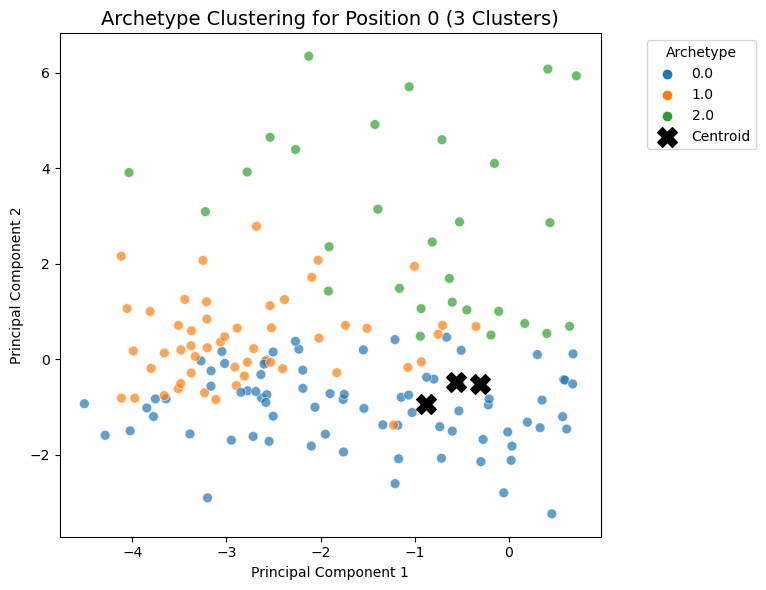

C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


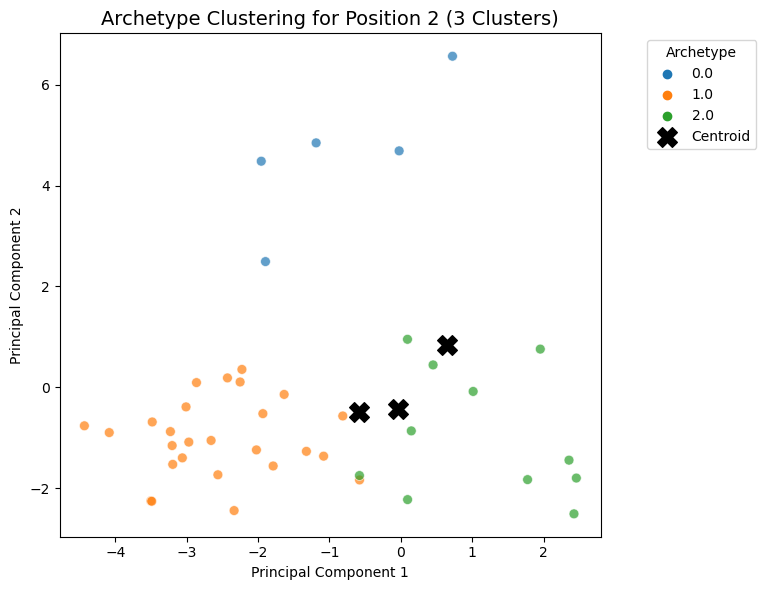

Optimized archetype clustering results saved successfully.


In [44]:
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def perform_archetype_clustering(df_pca, df_scaled, n_archetypes=3):
    """
    Perform archetype clustering for each position and visualize results.
    Parameters:
        - df_pca: DataFrame containing PCA results and position clusters.
        - df_scaled: Scaled feature matrix (numpy array or DataFrame).
        - n_archetypes: Number of archetypes (clusters) to create per position.
    Returns:
        - Updated df_pca with archetype labels.
    """
    unique_positions = df_pca["Position"].unique()
    for position in unique_positions:
        # Filter data for the current position
        subset_indices = df_pca[df_pca["Position"] == position].index
        subset_data = df_scaled[subset_indices]

        # Perform clustering for archetypes
        kmeans_archetypes = MiniBatchKMeans(n_clusters=n_archetypes, random_state=42, batch_size=100)
        archetype_labels = kmeans_archetypes.fit_predict(subset_data)

        # Add archetype labels to the DataFrame
        df_pca.loc[subset_indices, "Archetype"] = archetype_labels

        # Plot the results
        plot_archetypes(df_pca.loc[subset_indices], archetype_labels, position, kmeans_archetypes)
    
    return df_pca

def plot_archetypes(subset_df, archetype_labels, position, kmeans_model):
    """
    Plot PCA-based archetype clustering results for a specific position.
    Parameters:
        - subset_df: DataFrame subset containing PCA data for a single position.
        - archetype_labels: Cluster labels for archetypes.
        - position: Position ID being visualized.
        - kmeans_model: Trained KMeans model (for centroids).
    """
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x="PC1", y="PC2", hue="Archetype", data=subset_df,
        palette="tab10", alpha=0.7, s=50
    )
    # Add centroids to the plot
    centroids = kmeans_model.cluster_centers_
    pca_centroids = centroids[:, :2]  # Assume PC1 and PC2
    plt.scatter(
        pca_centroids[:, 0], pca_centroids[:, 1],
        s=200, c="black", marker="X", label="Centroid"
    )
    plt.title(f"Archetype Clustering for Position {position} (3 Clusters)", fontsize=14)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title="Archetype", loc='upper right', bbox_to_anchor=(1.3, 1))
    plt.tight_layout()
    plt.show()

# Perform archetype clustering and save results
df_pca = perform_archetype_clustering(df_pca, df_scaled)
df_pca.to_csv("player_archetypes_optimized.csv", index=False)
print("Optimized archetype clustering results saved successfully.")


### Finding Centroids Using KMeans

In [46]:
archetype_cluster_centers = {}

for position in df_pca["Position"].unique():
    print(f"\nProcessing Position {position}...")

    # Subset data for the current position
    subset_indices = df_pca[df_pca["Position"] == position].index
    subset_data = df_scaled[subset_indices]

    # Fit KMeans for archetypes within this position
    kmeans_archetypes = KMeans(n_clusters=3, random_state=42)
    archetype_labels = kmeans_archetypes.fit_predict(subset_data)

    # Calculate distances to archetype centroids
    distances_to_centroids = kmeans_archetypes.transform(subset_data)

    # Find the player closest to each archetype centroid
    archetype_centers = {}
    for archetype_label in range(kmeans_archetypes.n_clusters):
        cluster_indices = np.where(archetype_labels == archetype_label)[0]
        cluster_distances = distances_to_centroids[cluster_indices, archetype_label]
        closest_player_index = subset_indices[cluster_indices[np.argmin(cluster_distances)]]
        closest_player_id = df_combined.iloc[closest_player_index]["PLAYER_ID"]
        closest_player_name = df_combined.iloc[closest_player_index]["PLAYER_NAME_x"]

        archetype_centers[archetype_label] = closest_player_name

    archetype_cluster_centers[position] = archetype_centers

# Display the names of players closest to each archetype cluster centroid
print("\nClosest players to each archetype cluster centroid:")
for position, clusters in archetype_cluster_centers.items():
    print(f"\nPosition {position}:")
    for archetype_label, player_name in clusters.items():
        print(f"  Archetype {archetype_label}: {player_name}")


Processing Position 1...


C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



Processing Position 0...


C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



Processing Position 2...


C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



Closest players to each archetype cluster centroid:

Position 1:
  Archetype 0: Bam Adebayo
  Archetype 1: Tobias Harris
  Archetype 2: Donovan Mitchell

Position 0:
  Archetype 0: Goga Bitadze
  Archetype 1: Christian Wood
  Archetype 2: Ayo Dosunmu

Position 2:
  Archetype 0: Talen Horton-Tucker
  Archetype 1: Jalen Duren
  Archetype 2: Anfernee Simons


### GaussianMixture

In [48]:
# Additional imports left below

from sklearn.mixture import GaussianMixture
import numpy as np

archetype_cluster_centers = {}

for position in df_pca["Position"].unique():
    print(f"\nProcessing Position {position}...")

    # Subset data for the current position
    subset_indices = df_pca[df_pca["Position"] == position].index
    subset_data = df_scaled[subset_indices]

    # Fit GMM for archetypes within this position
    gmm = GaussianMixture(n_components=3, random_state=42, covariance_type='full')
    gmm_labels = gmm.fit_predict(subset_data)

    # Calculate distances to archetype centroids
    distances_to_centroids = gmm.predict_proba(subset_data)  # Probabilities as distances

    # Find the player closest to each archetype centroid
    archetype_centers = {}
    for archetype_label in range(gmm.n_components):
        cluster_indices = np.where(gmm_labels == archetype_label)[0]
        closest_player_index = subset_indices[cluster_indices[distances_to_centroids[cluster_indices, archetype_label].argmax()]]
        closest_player_name = df_combined.iloc[closest_player_index]["PLAYER_NAME_x"]

        archetype_centers[archetype_label] = closest_player_name

    archetype_cluster_centers[position] = archetype_centers

# Display the closest players
print("\nClosest players to each archetype cluster centroid:")
for position, clusters in archetype_cluster_centers.items():
    print(f"\nPosition {position}:")
    for archetype_label, player_name in clusters.items():
        print(f"  Archetype {archetype_label}: {player_name}")



Processing Position 1...

Processing Position 0...


C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



Processing Position 2...

Closest players to each archetype cluster centroid:

Position 1:
  Archetype 0: Nikola Vučević
  Archetype 1: Mike Conley
  Archetype 2: LeBron James

Position 0:
  Archetype 0: Jae Crowder
  Archetype 1: Russell Westbrook
  Archetype 2: Andre Drummond

Position 2:
  Archetype 0: Alec Burks
  Archetype 1: Clint Capela
  Archetype 2: Dennis Schröder


### Minibatch KMeans

In [50]:
from sklearn.cluster import MiniBatchKMeans
import numpy as np

archetype_cluster_centers = {}

for position in df_pca["Position"].unique():
    print(f"\nProcessing Position {position}...")

    # Subset data for the current position
    subset_indices = df_pca[df_pca["Position"] == position].index
    subset_data = df_scaled[subset_indices]

    # Fit MiniBatch KMeans for archetypes within this position
    mbkmeans = MiniBatchKMeans(n_clusters=3, batch_size=100, random_state=42)
    archetype_labels = mbkmeans.fit_predict(subset_data)

    # Calculate distances to archetype centroids
    distances_to_centroids = mbkmeans.transform(subset_data)

    # Find the player closest to each archetype centroid
    archetype_centers = {}
    for archetype_label in range(mbkmeans.n_clusters):
        cluster_indices = np.where(archetype_labels == archetype_label)[0]
        cluster_distances = distances_to_centroids[cluster_indices, archetype_label]
        closest_player_index = subset_indices[cluster_indices[np.argmin(cluster_distances)]]
        closest_player_name = df_combined.iloc[closest_player_index]["PLAYER_NAME_x"]

        archetype_centers[archetype_label] = closest_player_name

    archetype_cluster_centers[position] = archetype_centers

# Display the closest players
print("\nClosest players to each archetype cluster centroid:")
for position, clusters in archetype_cluster_centers.items():
    print(f"\nPosition {position}:")
    for archetype_label, player_name in clusters.items():
        print(f"  Archetype {archetype_label}: {player_name}")



Processing Position 1...


C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(



Processing Position 0...


C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(



Processing Position 2...


C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(



Closest players to each archetype cluster centroid:

Position 1:
  Archetype 0: Austin Reaves
  Archetype 1: Anthony Edwards
  Archetype 2: Bam Adebayo

Position 0:
  Archetype 0: Miles McBride
  Archetype 1: Haywood Highsmith
  Archetype 2: Paul Reed

Position 2:
  Archetype 0: Jalen Duren
  Archetype 1: Vince Williams Jr.
  Archetype 2: Cade Cunningham


## Position Predictions - Before Finalization

In [52]:
for position in df_combined['Position'].unique():
    subset = df_combined[df_combined['Position'] == position]
    kmeans_subset = KMeans(n_clusters=3, random_state=42)
    subset['Archetype'] = kmeans_subset.fit_predict(subset[features].values)
    print(f"Archetypes for Position {position}:")
    print(subset[['PLAYER_NAME_x', 'Archetype']])


C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\Temp\ipykernel_18392\757236437.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Archetype'] = kmeans_subset.fit_predict(subset[features].values)
C:\Users\n

Archetypes for Position 1:
         PLAYER_NAME_x  Archetype
0         LeBron James          0
3         Kevin Durant          0
5          Mike Conley          1
10         Brook Lopez          1
12        James Harden          1
..                 ...        ...
267     Jalen Williams          2
274   Jaime Jaquez Jr.          1
284  Victor Wembanyama          2
285     Brandon Miller          2
294     Keyonte George          1

[102 rows x 2 columns]


C:\Users\nlomnitz\AppData\Local\Temp\ipykernel_18392\757236437.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Archetype'] = kmeans_subset.fit_predict(subset[features].values)
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Archetypes for Position 0:
          PLAYER_NAME_x  Archetype
1            Chris Paul          2
2            Kyle Lowry          2
4            Al Horford          2
6            Jeff Green          2
7     Russell Westbrook          1
..                  ...        ...
296    Dereck Lively II          2
298      Toumani Camara          2
299  Brandin Podziemski          1
300        Ben Sheppard          0
301          Duop Reath          2

[158 rows x 2 columns]
Archetypes for Position 2:
           PLAYER_NAME_x  Archetype
22            Alec Burks          1
40       Dennis Schröder          0
47       Jordan Clarkson          0
55         Julius Randle          0
57           Joel Embiid          0
58            Danté Exum          2
60          Clint Capela          1
68            Tyus Jones          1
80         Norman Powell          0
97       Malcolm Brogdon          2
100          Ivica Zubac          1
101  Dorian Finney-Smith          1
103    Derrick Jones Jr.          

C:\Users\nlomnitz\AppData\Local\Temp\ipykernel_18392\757236437.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Archetype'] = kmeans_subset.fit_predict(subset[features].values)


### Understanding Optimal K for KMeans

C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chun

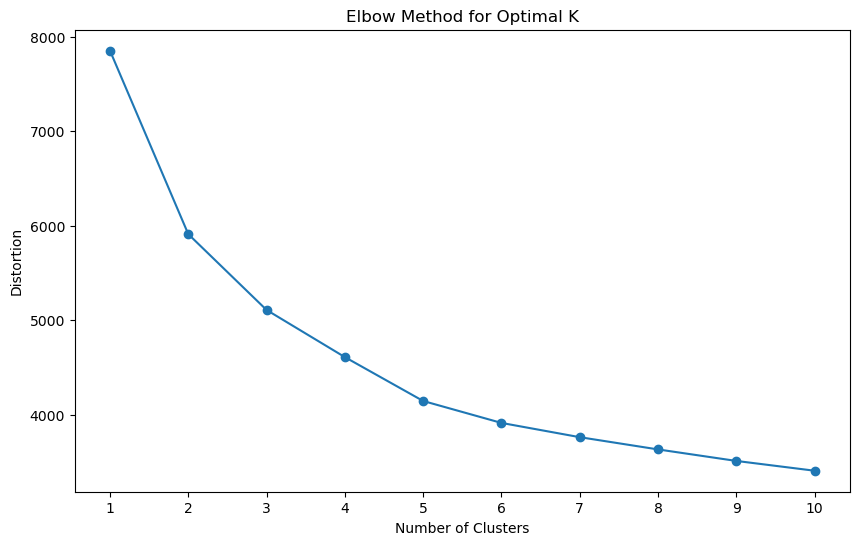

In [54]:

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow method to find optimal number of clusters
def plot_elbow_method(data, max_k=10):
    distortions = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_k + 1), distortions, marker='o')
    plt.xticks(range(1, max_k + 1))
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion')
    plt.title('Elbow Method for Optimal K')
    plt.show()

plot_elbow_method(df_scaled)

C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chun

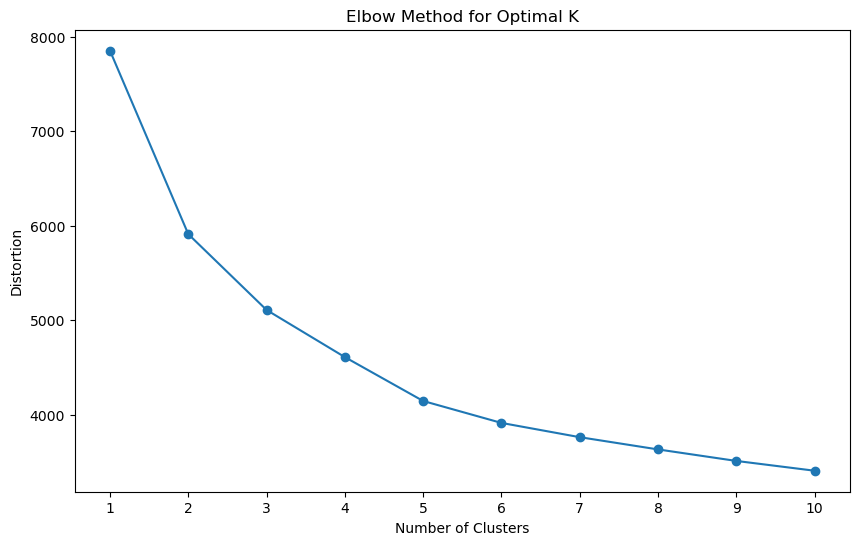

In [55]:

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow method to find optimal number of clusters
def plot_elbow_method(data, max_k=10):
    distortions = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_k + 1), distortions, marker='o')
    plt.xticks(range(1, max_k + 1))
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion')
    plt.title('Elbow Method for Optimal K')
    plt.show()

plot_elbow_method(df_scaled)


C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chun

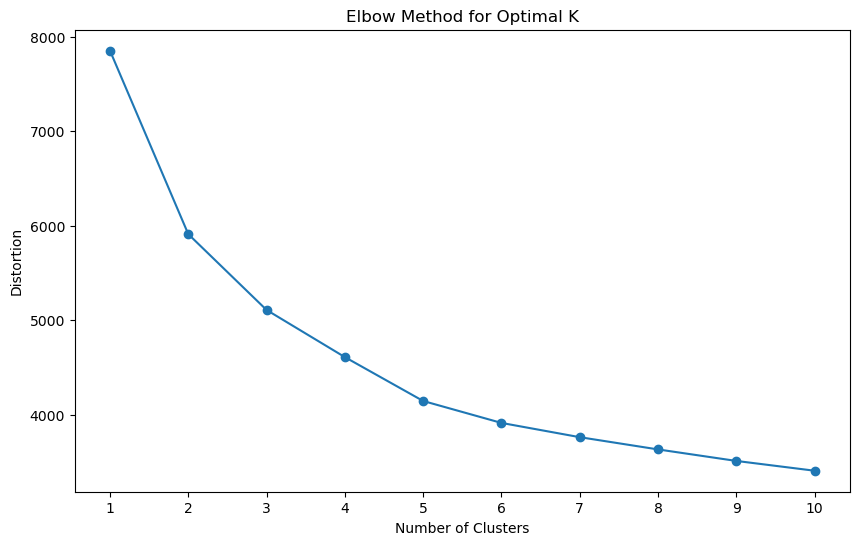

In [56]:

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow method to find optimal number of clusters
def plot_elbow_method(data, max_k=10):
    distortions = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_k + 1), distortions, marker='o')
    plt.xticks(range(1, max_k + 1))
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion')
    plt.title('Elbow Method for Optimal K')
    plt.show()

plot_elbow_method(df_scaled)


## Final Model Feature Selection

In [58]:
# Step 4: Split by Position and Cluster Archetypes
archetype_results = {}
features = [
    "FGM", "FGA", "FG_PCT",        # Field goal metrics
    "FG3M", "FG3A", "FG3_PCT",     # Three-point shooting metrics
    "FTM", "FTA", "FT_PCT",        # Free throw metrics
    "PTS", "PLUS_MINUS",           # Points scored and impact metrics
    
    # Defensive Features
    "STL", "BLK",                  # Steals and blocks for defense
    "OREB_x", "DREB_x", "REB",         # Rebounding metrics
    "PF_x", "BLKA_x",                  # Personal fouls and blocks against
    
    # Playmaking Features
    "AST", "TOV",                  # Assists and turnovers
    "usagePercentage",             # Usage percentage
    "netRating", "offensiveRating", "defensiveRating",  # Efficiency ratings
    
    # Optional Contextual Metrics
    "pace",                        # Game pace
    "SHOT_DISTANCE",               # Average shot distance
]

In [59]:
import pandas as pd
from nba_api.stats.endpoints import commonteamroster
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
from requests.exceptions import ReadTimeout
import requests  # Import requests for API calls

# Step 1: Load teamId from advanced_player_stats.csv
advanced_player_stats_path = 'advanced_player_stats.csv'
advanced_player_stats = pd.read_csv(advanced_player_stats_path)

# Rename personId to PLAYER_ID to ensure compatibility
advanced_player_stats.rename(columns={'personId': 'PLAYER_ID'}, inplace=True)

# Extract teamId from the dataset
first_q_data = advanced_player_stats[['teamId']].drop_duplicates().dropna()



## Featching Player Positions From API - Better Position Understanding

In [61]:
# Step 2: Fetch Player Positions from NBA Stats API with Rate Limiting
def fetch_team_roster(team_id, season, retries=3, delay=5):
    """
    Fetch the roster for a given team ID from the NBA stats API.
    """
    url = f"https://stats.nba.com/stats/commonteamroster?Season={season}&TeamID={team_id}"
    headers = {
        "Host": "stats.nba.com",
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
        "Accept": "application/json, text/plain, */*",
        "Accept-Language": "en-US,en;q=0.9",
        "Connection": "keep-alive",
        "Referer": "https://www.nba.com/",
        "Origin": "https://www.nba.com",
    }

    for attempt in range(retries):
        try:
            response = requests.get(url, headers=headers, timeout=30)
            response.raise_for_status()  # Raise HTTPError for bad responses
            json_data = response.json()
            roster_data = json_data["resultSets"][0]["rowSet"]  # Player roster data
            columns = json_data["resultSets"][0]["headers"]  # Column names
            return pd.DataFrame(roster_data, columns=columns)
        except requests.exceptions.Timeout:
            print(f"Timeout for team_id {team_id}. Retrying ({attempt + 1}/{retries})...")
            time.sleep(delay)
        except Exception as e:
            print(f"Error fetching data for team_id {team_id}: {e}")
            return pd.DataFrame()
    print(f"Failed to fetch data for team_id {team_id} after {retries} retries.")
    return pd.DataFrame()

def fetch_all_rosters(first_q_data, season):
    """
    Fetch rosters for all teams in the given data and season with rate limiting.
    """
    team_ids = first_q_data['teamId']
    unique_team_ids = list(set(team_ids))
    unique_team_ids = [int(value) for value in unique_team_ids if not math.isnan(value)]
    
    all_team_rosters = pd.DataFrame()
    for team_id in unique_team_ids:
        print(f"Fetching roster for team ID {team_id}...")
        roster_df = fetch_team_roster(team_id, season)
        all_team_rosters = pd.concat([all_team_rosters, roster_df], ignore_index=True)
        time.sleep(1)  # Respect rate limits with 1-second delay
    return all_team_rosters

In [62]:
# Fetch positions for the 2023-24 season
player_position_data = fetch_all_rosters(first_q_data, "2023-24")
print(player_position_data.head())

Fetching roster for team ID 1610612737...
Fetching roster for team ID 1610612738...
Fetching roster for team ID 1610612739...
Fetching roster for team ID 1610612740...
Fetching roster for team ID 1610612741...
Fetching roster for team ID 1610612742...
Fetching roster for team ID 1610612743...
Fetching roster for team ID 1610612744...
Fetching roster for team ID 1610612745...
Fetching roster for team ID 1610612746...
Fetching roster for team ID 1610612747...
Fetching roster for team ID 1610612748...
Fetching roster for team ID 1610612749...
Fetching roster for team ID 1610612750...
Fetching roster for team ID 1610612751...
Fetching roster for team ID 1610612752...
Fetching roster for team ID 1610612753...
Fetching roster for team ID 1610612754...
Fetching roster for team ID 1610612755...
Fetching roster for team ID 1610612756...
Fetching roster for team ID 1610612757...
Fetching roster for team ID 1610612758...
Fetching roster for team ID 1610612759...
Fetching roster for team ID 161061

In [63]:
player_position_data.head(5)

TeamID SEASON LeagueID           PLAYER  NICKNAME      PLAYER_SLUG NUM  \
0  1610612737   2023       00    Jalen Johnson     Jalen    jalen-johnson   1   
1  1610612737   2023       00    Trent Forrest     Trent    trent-forrest   2   
2  1610612737   2023       00       Seth Lundy      Seth       seth-lundy   3   
3  1610612737   2023       00      Kobe Bufkin      Kobe      kobe-bufkin   4   
4  1610612737   2023       00  Dejounte Murray  Dejounte  dejounte-murray   5   

  POSITION HEIGHT WEIGHT    BIRTH_DATE   AGE EXP         SCHOOL  PLAYER_ID  \
0        F    6-8    219  DEC 18, 2001  22.0   2           Duke    1630552   
1        G    6-4    210  JUN 12, 1998  26.0   3  Florida State    1630235   
2      G-F    6-4    220  APR 02, 2000  24.0   R     Penn State    1641754   
3        G    6-5    195  SEP 21, 2003  20.0   R       Michigan    1641723   
4        G    6-5    180  SEP 19, 1996  27.0   6     Washington    1627749   

             HOW_ACQUIRED  
0  #20 Pick in 2021 Draft  
1                    None  
2  #46 Pick in 2023 Draft  
3  #15 Pick in 2023 Draft  
4                    None

### Merging New Position Data

In [65]:
# Step 3: Merge position data into the advanced_player_stats dataset
df_combined = df_combined.merge(
    player_position_data[['PLAYER_ID', 'POSITION']],
    on='PLAYER_ID',
    how='left'
)

In [66]:
df_combined = df_combined.groupby('PLAYER_ID', as_index=False).first()

print(df_combined)

     PLAYER_ID position  offensiveRating  defensiveRating  netRating  \
0         2544        F            128.4            109.0       19.4   
1       101108        G            116.7            139.6      -22.9   
2       200768        G            110.2             75.5       34.7   
3       201142        F            139.2            102.8       36.4   
4       201143        F            106.3            157.6      -51.3   
..         ...      ...              ...              ...        ...   
297    1641731        G              0.0              0.0        0.0   
298    1641739        F            112.3            112.3        0.0   
299    1641764        G            131.1            106.8       24.3   
300    1641767        F            156.9            125.4       31.5   
301    1641871        C             77.4            129.6      -52.3   

     usagePercentage    pace       PLAYER_NAME_x          MIN  FGM  ...  \
0              0.299  101.26        LeBron James  2503.68333

In [67]:
df_combined

PLAYER_ID position  offensiveRating  defensiveRating  netRating  \
0         2544        F            128.4            109.0       19.4   
1       101108        G            116.7            139.6      -22.9   
2       200768        G            110.2             75.5       34.7   
3       201142        F            139.2            102.8       36.4   
4       201143        F            106.3            157.6      -51.3   
..         ...      ...              ...              ...        ...   
297    1641731        G              0.0              0.0        0.0   
298    1641739        F            112.3            112.3        0.0   
299    1641764        G            131.1            106.8       24.3   
300    1641767        F            156.9            125.4       31.5   
301    1641871        C             77.4            129.6      -52.3   

     usagePercentage    pace       PLAYER_NAME_x          MIN  FGM  ...  \
0              0.299  101.26        LeBron James  2503.683333  685  ...   
1              0.220  101.57          Chris Paul  1530.890000  206  ...   
2              0.069  101.38          Kyle Lowry  1689.766667  163  ...   
3              0.218   92.56        Kevin Durant  2790.636667  751  ...   
4              0.121  100.47          Al Horford  1739.796667  214  ...   
..               ...     ...                 ...          ...  ...  ...   
297            0.000    0.00     Bilal Coulibaly  1715.250000  188  ...   
298            0.155  103.00      Toumani Camara  1739.320000  197  ...   
299            0.127   99.58  Brandin Podziemski  1968.253333  271  ...   
300            0.088  110.12        Ben Sheppard   814.260000   90  ...   
301            0.222  106.34          Duop Reath  1214.115000  230  ...   

      STL_RANK_y   BLK_RANK_y   BLKA_RANK_y     PF_RANK_y   PFD_RANK_y  \
0    1366.534247  1640.027397  12346.328767  13849.164384  1065.835616   
1    1426.753247  1720.935065  11576.337662  14520.766234  1320.246753   
2    1270.348485  1173.969697  12331.227273  14683.863636  1488.818182   
3    1205.451613  1269.403226  11426.016129  14119.983871  1124.064516   
4    1470.840580  1374.652174  10881.927536  13507.492754  1501.028986   
..           ...          ...           ...           ...          ...   
297  1528.150000  1674.300000  12014.416667  14353.700000  1202.633333   
298  1668.581081  2126.729730  12953.905405  14331.945946  1283.567568   
299  1426.753247  1720.935065  11576.337662  14520.766234  1320.246753   
300  1455.686567  1422.000000  12482.343284  14760.537313  1386.686567   
301  1668.581081  2126.729730  12953.905405  14331.945946  1283.567568   

      PTS_RANK_y  PLUS_MINUS_RANK_y       PLAYER_NAME_y  Position  POSITION  
0    1005.712329        6139.520548        LeBron James         1         F  
1     948.454545        7256.285714          Chris Paul         0         G  
2    1046.439394        6966.757576          Kyle Lowry         0         G  
3    1038.919355        5410.080645        Kevin Durant         1         F  
4    1037.666667        4512.942029          Al Horford         0       C-F  
..           ...                ...                 ...       ...       ...  
297  1036.100000        9690.650000     Bilal Coulibaly         2         G  
298  1212.770270        9329.824324      Toumani Camara         0         F  
299   948.454545        7256.285714  Brandin Podziemski         0         G  
300  1043.895522        6458.776119        Ben Sheppard         0         G  
301  1212.770270        9329.824324          Duop Reath         0         C  

[302 rows x 143 columns]

## Preprocessing on Final df_combined

In [69]:
# Simplify position column to G, F, C
if "PLAYER_ID" not in player_position_data.columns:
    player_position_data.rename(columns={"PERSON_ID": "PLAYER_ID"}, inplace=True)
player_position_data['POSITION'] = player_position_data['POSITION'].str[0]

In [70]:
# Step 3: Merge position data into the advanced_player_stats dataset
df_combined = df_combined.merge(
    player_position_data[['PLAYER_ID', 'POSITION']],
    on='PLAYER_ID',
    how='left'
)

In [71]:
df_combined = df_combined.dropna(subset=['position'])

In [72]:
# Group by PLAYER_ID and keep the first occurrence
df_combined = df_combined.groupby('PLAYER_ID', as_index=False).first()

print(df_combined)

     PLAYER_ID position  offensiveRating  defensiveRating  netRating  \
0         2544        F            128.4            109.0       19.4   
1       101108        G            116.7            139.6      -22.9   
2       200768        G            110.2             75.5       34.7   
3       201142        F            139.2            102.8       36.4   
4       201143        F            106.3            157.6      -51.3   
..         ...      ...              ...              ...        ...   
287    1641731        G              0.0              0.0        0.0   
288    1641739        F            112.3            112.3        0.0   
289    1641764        G            131.1            106.8       24.3   
290    1641767        F            156.9            125.4       31.5   
291    1641871        C             77.4            129.6      -52.3   

     usagePercentage    pace       PLAYER_NAME_x          MIN  FGM  ...  \
0              0.299  101.26        LeBron James  2503.68333

In [73]:
df_combined

PLAYER_ID position  offensiveRating  defensiveRating  netRating  \
0         2544        F            128.4            109.0       19.4   
1       101108        G            116.7            139.6      -22.9   
2       200768        G            110.2             75.5       34.7   
3       201142        F            139.2            102.8       36.4   
4       201143        F            106.3            157.6      -51.3   
..         ...      ...              ...              ...        ...   
287    1641731        G              0.0              0.0        0.0   
288    1641739        F            112.3            112.3        0.0   
289    1641764        G            131.1            106.8       24.3   
290    1641767        F            156.9            125.4       31.5   
291    1641871        C             77.4            129.6      -52.3   

     usagePercentage    pace       PLAYER_NAME_x          MIN  FGM  ...  \
0              0.299  101.26        LeBron James  2503.683333  685  ...   
1              0.220  101.57          Chris Paul  1530.890000  206  ...   
2              0.069  101.38          Kyle Lowry  1689.766667  163  ...   
3              0.218   92.56        Kevin Durant  2790.636667  751  ...   
4              0.121  100.47          Al Horford  1739.796667  214  ...   
..               ...     ...                 ...          ...  ...  ...   
287            0.000    0.00     Bilal Coulibaly  1715.250000  188  ...   
288            0.155  103.00      Toumani Camara  1739.320000  197  ...   
289            0.127   99.58  Brandin Podziemski  1968.253333  271  ...   
290            0.088  110.12        Ben Sheppard   814.260000   90  ...   
291            0.222  106.34          Duop Reath  1214.115000  230  ...   

      BLK_RANK_y   BLKA_RANK_y     PF_RANK_y   PFD_RANK_y   PTS_RANK_y  \
0    1640.027397  12346.328767  13849.164384  1065.835616  1005.712329   
1    1720.935065  11576.337662  14520.766234  1320.246753   948.454545   
2    1173.969697  12331.227273  14683.863636  1488.818182  1046.439394   
3    1269.403226  11426.016129  14119.983871  1124.064516  1038.919355   
4    1374.652174  10881.927536  13507.492754  1501.028986  1037.666667   
..           ...           ...           ...          ...          ...   
287  1674.300000  12014.416667  14353.700000  1202.633333  1036.100000   
288  2126.729730  12953.905405  14331.945946  1283.567568  1212.770270   
289  1720.935065  11576.337662  14520.766234  1320.246753   948.454545   
290  1422.000000  12482.343284  14760.537313  1386.686567  1043.895522   
291  2126.729730  12953.905405  14331.945946  1283.567568  1212.770270   

     PLUS_MINUS_RANK_y       PLAYER_NAME_y  Position  POSITION_x  POSITION_y  
0          6139.520548        LeBron James         1           F           F  
1          7256.285714          Chris Paul         0           G           G  
2          6966.757576          Kyle Lowry         0           G           G  
3          5410.080645        Kevin Durant         1           F           F  
4          4512.942029          Al Horford         0         C-F           C  
..                 ...                 ...       ...         ...         ...  
287        9690.650000     Bilal Coulibaly         2           G           G  
288        9329.824324      Toumani Camara         0           F           F  
289        7256.285714  Brandin Podziemski         0           G           G  
290        6458.776119        Ben Sheppard         0           G           G  
291        9329.824324          Duop Reath         0           C           C  

[292 rows x 144 columns]

## Running Model on Final df_combined - KMeans, GaussianMixture, SpectralClustering Experimentation


Processing with KMeans...


C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\Temp\ipykernel_18392\1592180658.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  position_data['Archetype'] = labels
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib


Processing with GMM...


C:\Users\nlomnitz\AppData\Local\Temp\ipykernel_18392\1592180658.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  position_data['Archetype'] = labels
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\Temp\ipykernel_18392\1592180658.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st


Processing with SpectralClustering...


C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\Temp\ipykernel_18392\1592180658.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  position_data['Archetype'] = labels
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings


Summary Table for KMeans:
  Position  Archetype           Players
0        F          0       Cam Reddish
1        F          1       Evan Mobley
2        F          2     Caleb Houstan
3        G          0    Justin Holiday
4        G          1       Alex Caruso
5        G          2  Dennis Smith Jr.
6        C          0     Nick Richards
7        C          1       Brook Lopez
8        C          2       Maxi Kleber


C:\Users\nlomnitz\AppData\Local\Temp\ipykernel_18392\1592180658.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  position_data['Archetype'] = labels


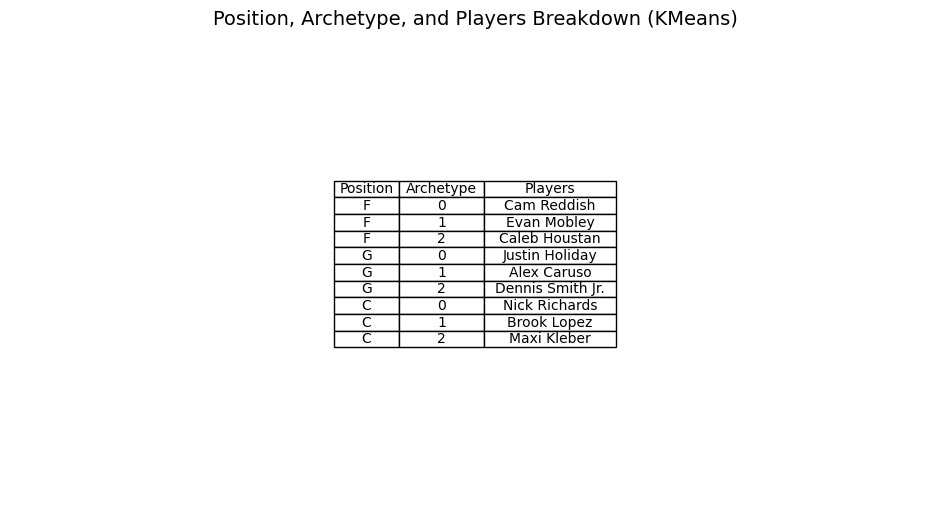


Summary Table for GMM:
  Position  Archetype           Players
0        F          0       Cam Reddish
1        F          1    Toumani Camara
2        F          2      Jimmy Butler
3        G          0  Dennis Smith Jr.
4        G          1    Justin Holiday
5        G          2       Alex Caruso
6        C          0     Nick Richards
7        C          1       Maxi Kleber
8        C          2      Jusuf Nurkić


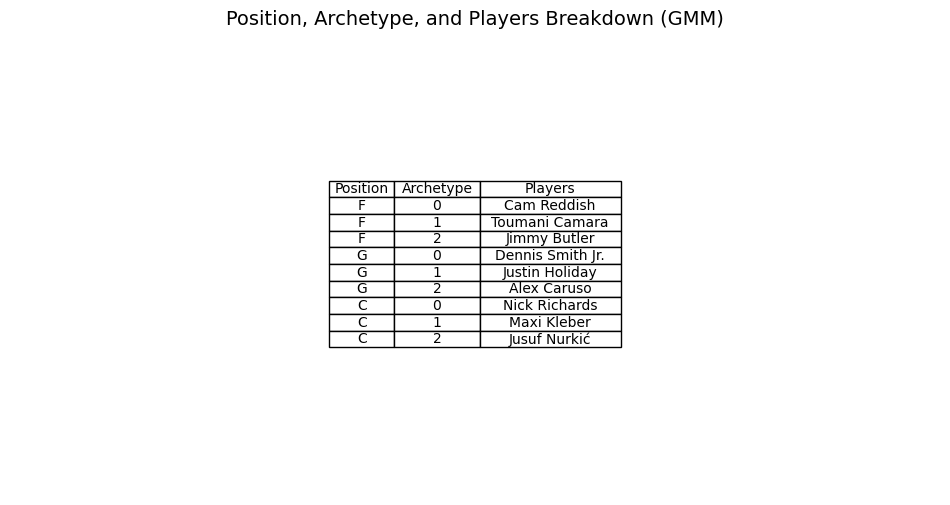


Summary Table for SpectralClustering:
  Position  Archetype            Players
0        F          0      Tobias Harris
1        F          1  Derrick Jones Jr.
2        F          2        Amir Coffey
3        G          0   D'Angelo Russell
4        G          1         Alec Burks
5        G          2      Cameron Payne
6        C          0       Clint Capela
7        C          1     Onyeka Okongwu
8        C          2        Bam Adebayo


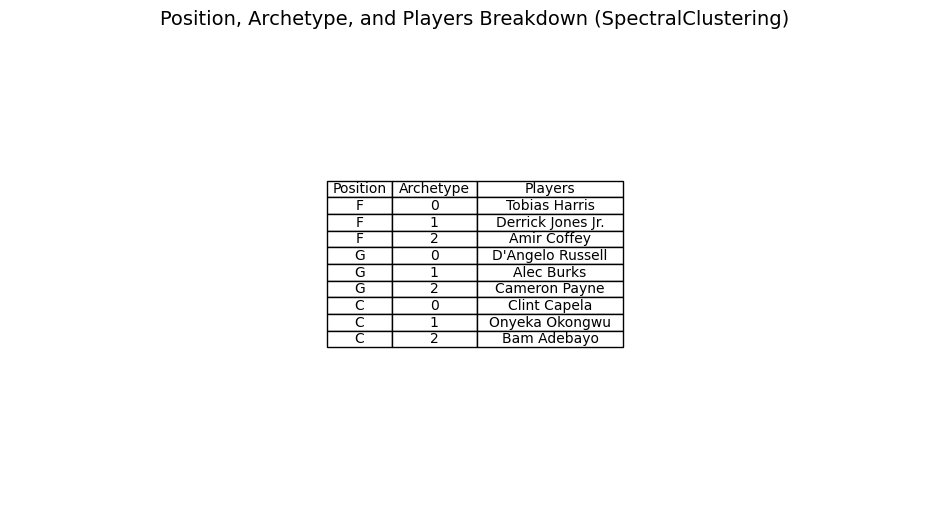

In [75]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
import numpy as np

# Define clustering models
models = {
    "KMeans": KMeans(n_clusters=3, random_state=42),
    "GMM": GaussianMixture(n_components=3, random_state=42),
    "SpectralClustering": SpectralClustering(n_clusters=3, affinity='nearest_neighbors', random_state=42)
}

def summarize_archetypes(model_name, model, position_data, position_features, features):
    # Fit the model
    if model_name == "SpectralClustering":
        labels = model.fit_predict(position_features)
    else:
        model.fit(position_features)
        labels = model.predict(position_features)
    
    position_data['Archetype'] = labels

    # Find closest players to each archetype center
    summary_rows = []
    for archetype in np.unique(labels):
        subset = position_data[position_data['Archetype'] == archetype]
        if model_name != "SpectralClustering":
            centroid = model.means_[archetype] if hasattr(model, "means_") else model.cluster_centers_[archetype]
        else:
            centroid = subset[features].mean().values

        closest_player_idx = ((subset[features] - centroid) ** 2).sum(axis=1).idxmin()
        closest_player = subset.loc[closest_player_idx, 'PLAYER_NAME_x']
        summary_rows.append([archetype, closest_player])
    
    return position_data, pd.DataFrame(summary_rows, columns=['Archetype', 'Players'])


# Apply models and generate tables for each position
model_summaries = {}
for model_name, model in models.items():
    print(f"\nProcessing with {model_name}...")
    model_results = []
    
    for position in df_combined['position'].unique():
        position_data = df_combined[df_combined['position'] == position]
        position_features = position_data[features].dropna()

        if position_features.empty:
            print(f"Skipping position {position} due to insufficient data.")
            continue

        # Standardize features
        scaler = StandardScaler()
        position_scaled = scaler.fit_transform(position_features)

        # Generate archetypes and summaries
        position_data, summary_table = summarize_archetypes(
            model_name, model, position_data, position_scaled, features
        )
        summary_table.insert(0, "Position", position)  # Add position column
        model_results.append(summary_table)

    # Combine all summaries for the model
    model_summaries[model_name] = pd.concat(model_results, ignore_index=True)

# Display summary tables for each model
for model_name, summary in model_summaries.items():
    print(f"\nSummary Table for {model_name}:")
    print(summary)

    # Visualize table
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(
        cellText=summary.values,
        colLabels=summary.columns,
        loc='center',
        cellLoc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(summary.columns))))
    plt.title(f'Position, Archetype, and Players Breakdown ({model_name})', fontsize=14)
    plt.show()


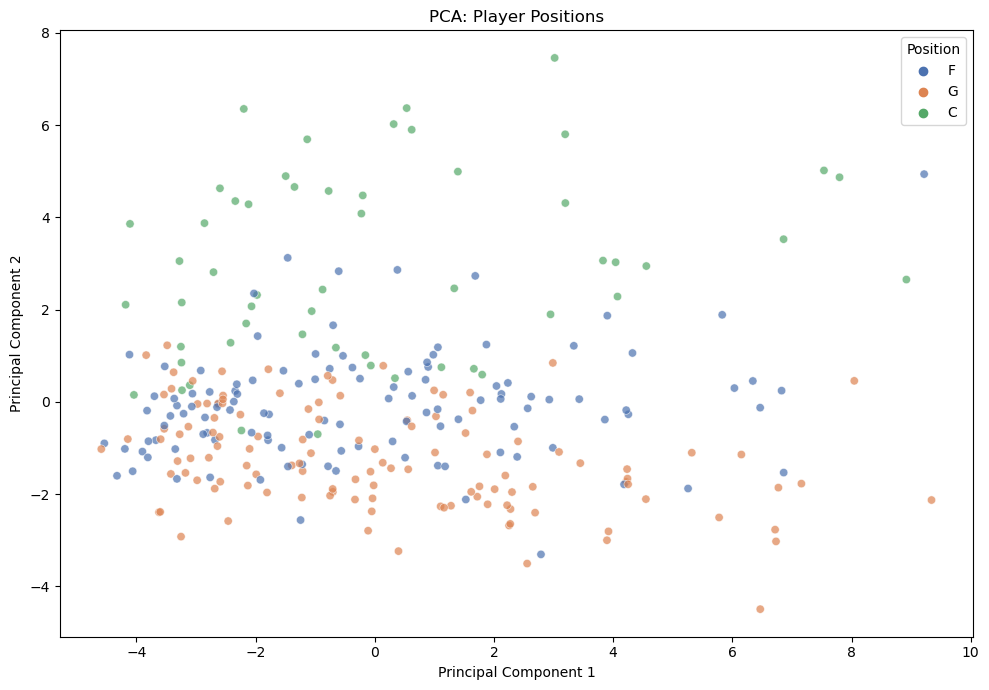


Processing with KMeans...


C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Accuracy for KMeans: 43.49%
Silhouette Score for KMeans: 0.2336

Processing with GMM...
Accuracy for GMM: 42.81%
Silhouette Score for GMM: 0.1342

Processing with Agglomerative...
Accuracy for Agglomerative: 43.84%
Silhouette Score for Agglomerative: 0.2150


C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` 

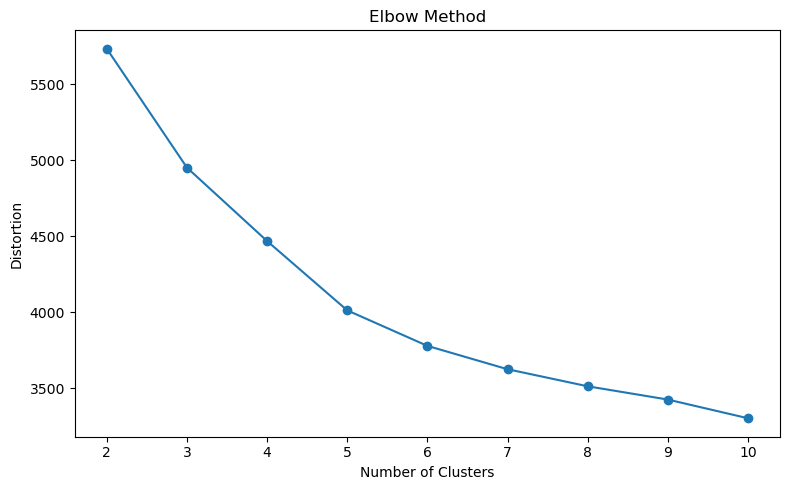


Best Model: Agglomerative
Accuracy: 43.84%
Silhouette Score: 0.2150


In [76]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

df_combined = df_combined.dropna(subset=features + ["position"])

# Encode positions numerically
position_mapping = {pos: idx for idx, pos in enumerate(df_combined['position'].unique())}
df_combined['POSITION_ENCODED'] = df_combined['position'].map(position_mapping)

# Scale the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_combined[features])

# PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)
df_combined['PC1'] = pca_result[:, 0]
df_combined['PC2'] = pca_result[:, 1]

# Plot PCA visualization
plt.figure(figsize=(10, 7))
sns.scatterplot(x="PC1", y="PC2", hue="position", data=df_combined, palette="deep", alpha=0.7)
plt.title("PCA: Player Positions")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Position")
plt.tight_layout()
plt.show()

# Function to map clustering labels to true labels
def map_clusters_to_labels(labels, true_labels):
    label_mapping = {}
    for cluster in np.unique(labels):
        cluster_true_labels = true_labels[labels == cluster]
        most_common_label = Counter(cluster_true_labels).most_common(1)[0][0]
        label_mapping[cluster] = most_common_label
    return np.vectorize(label_mapping.get)(labels)

# Define clustering models
models = {
    "KMeans": KMeans(n_clusters=3, random_state=42),
    "GMM": GaussianMixture(n_components=3, random_state=42),
    "Agglomerative": AgglomerativeClustering(n_clusters=3),
}

# Run clustering models
model_results = {}
for model_name, model in models.items():
    print(f"\nProcessing with {model_name}...")
    if model_name == "GMM":
        model.fit(df_scaled)
        labels = model.predict(df_scaled)
    else:
        labels = model.fit_predict(df_scaled)

    # Map clusters to true labels
    mapped_labels = map_clusters_to_labels(labels, df_combined['POSITION_ENCODED'].values)

    # Calculate accuracy and silhouette score
    accuracy = accuracy_score(df_combined['POSITION_ENCODED'], mapped_labels)
    silhouette = silhouette_score(df_scaled, labels)

    print(f"Accuracy for {model_name}: {accuracy:.2%}")
    print(f"Silhouette Score for {model_name}: {silhouette:.4f}")

    # Save results
    model_results[model_name] = {"labels": labels, "accuracy": accuracy, "silhouette": silhouette}

# Plot Elbow Method for KMeans
distortions = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    distortions.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), distortions, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Distortion")
plt.tight_layout()
plt.show()

# Analyze best-performing model
best_model_name = max(model_results, key=lambda x: model_results[x]['accuracy'])
print(f"\nBest Model: {best_model_name}")
print(f"Accuracy: {model_results[best_model_name]['accuracy']:.2%}")
print(f"Silhouette Score: {model_results[best_model_name]['silhouette']:.4f}")


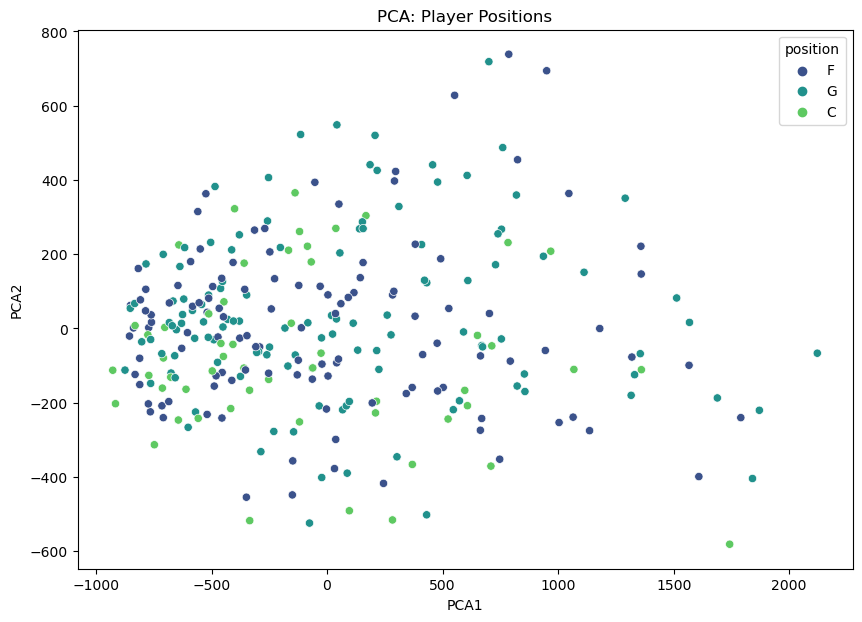


Processing with KMeans...


C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Silhouette Score for KMeans: 0.3193
Accuracy for KMeans: 43.15%


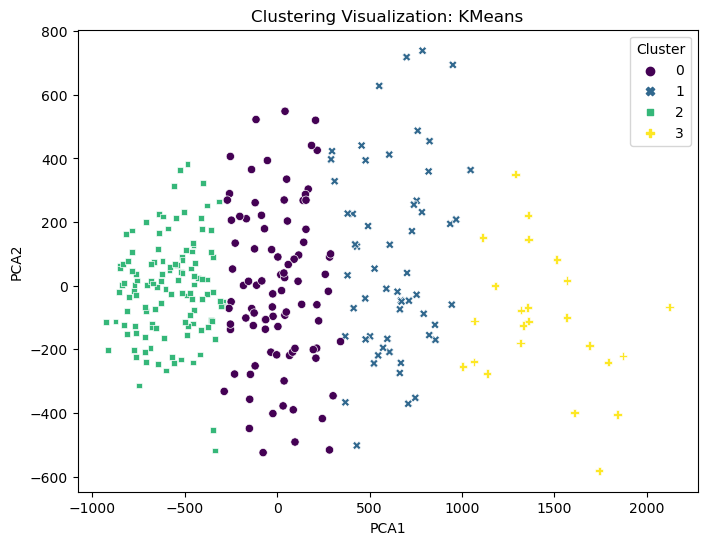


Processing with GMM...
Silhouette Score for GMM: 0.3088
Accuracy for GMM: 43.15%


C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


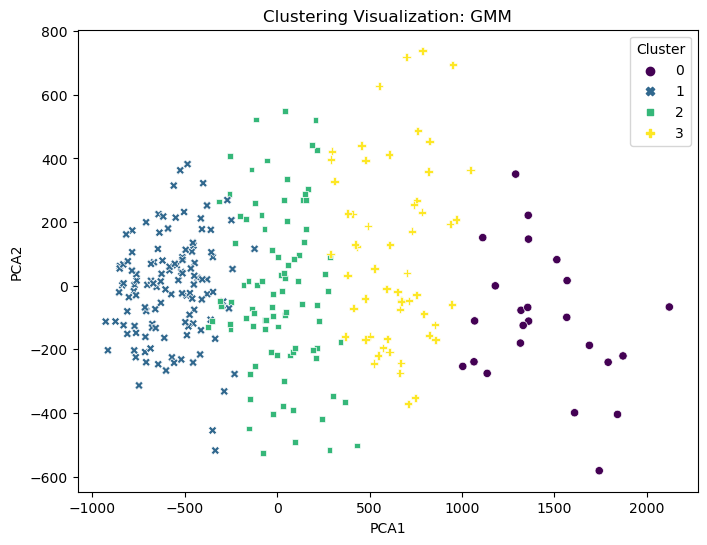


Processing with Agglomerative...
Silhouette Score for Agglomerative: 0.2861
Accuracy for Agglomerative: 45.55%


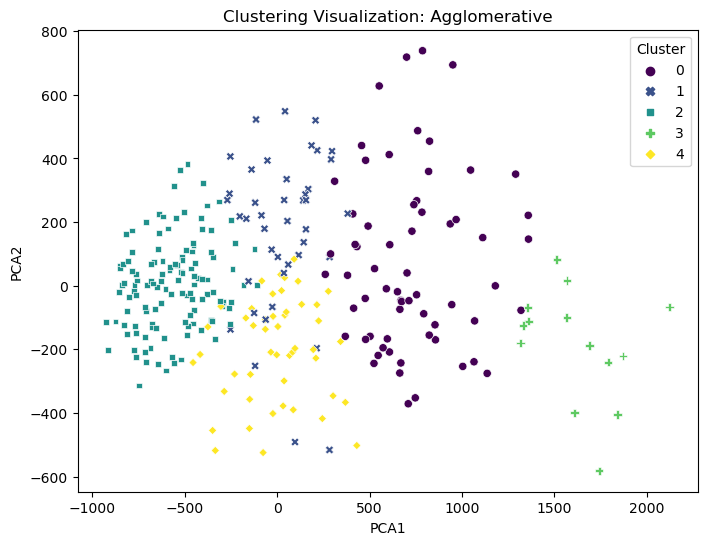


Processing with DBSCAN...
DBSCAN detected noise. Skipping accuracy evaluation.
KMeans: Accuracy=43.15%, Silhouette=0.3193
GMM: Accuracy=43.15%, Silhouette=0.3088
Agglomerative: Accuracy=45.55%, Silhouette=0.2861


In [77]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, accuracy_score
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Function to map clustering labels to true labels
def map_clusters_to_labels(labels, true_labels):
    label_mapping = {}
    for cluster in np.unique(labels):
        cluster_true_labels = true_labels[labels == cluster]
        most_common_label = Counter(cluster_true_labels).most_common(1)[0][0]
        label_mapping[cluster] = most_common_label
    return np.vectorize(label_mapping.get)(labels)

# Apply PCA to the dataset
def apply_pca(X, n_components=2):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    return X_pca, pca

# Clustering function
def run_clustering(df, features, target):
    models = {
        "KMeans": KMeans(n_clusters=4, random_state=42),
        "GMM": GaussianMixture(n_components=4, random_state=42),
        "Agglomerative": AgglomerativeClustering(n_clusters=5),
        "DBSCAN": DBSCAN(eps=1.5, min_samples=10)
    }

    results = {}
    for model_name, model in models.items():
        print(f"\nProcessing with {model_name}...")
        if model_name == "DBSCAN":
            labels = model.fit_predict(df[features])
            if -1 in labels:  # Handle noise
                print(f"{model_name} detected noise. Skipping accuracy evaluation.")
                continue
        elif model_name == "Agglomerative":
            labels = model.fit_predict(df[features])  # Use fit_predict for AgglomerativeClustering
        else:
            labels = model.fit(df[features]).predict(df[features])

        df['Cluster'] = labels

        # Evaluate clustering
        silhouette = silhouette_score(df[features], labels)
        print(f"Silhouette Score for {model_name}: {silhouette:.4f}")

        # Map clusters to true labels and calculate accuracy
        if model_name != "DBSCAN":
            mapped_labels = map_clusters_to_labels(labels, df[target].values)
            accuracy = accuracy_score(df[target], mapped_labels)
            print(f"Accuracy for {model_name}: {accuracy:.2%}")
            results[model_name] = {"Accuracy": accuracy, "Silhouette": silhouette}
        else:
            results[model_name] = {"Silhouette": silhouette}

        # Visualize clusters
        plt.figure(figsize=(8, 6))
        sns.scatterplot(
            x="PCA1", y="PCA2", hue="Cluster", data=df, palette="viridis", style="Cluster", legend="full"
        )
        plt.title(f"Clustering Visualization: {model_name}")
        plt.show()

    return results

# Select features for PCA
def select_features(X, y):
    selected_features = X.columns  # Replace with feature selection logic if needed
    return X[selected_features], selected_features

# Main script
if __name__ == "__main__":
    # Load your data into `df_combined` here
    # Example: df_combined = pd.read_csv("data.csv")
    
    # Preprocess the data
    target = "position"  # Replace with your target column name
    df_combined.dropna(subset=features + [target], inplace=True)
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_combined[features])
    df_processed = df_combined.copy()
    
    # Feature selection (use all features for now)
    X_selected, selected_features = select_features(df_processed[features], df_processed[target])
    
    # Apply PCA
    pca_result, pca_model = apply_pca(X_selected, n_components=2)
    df_processed['PCA1'] = pca_result[:, 0]
    df_processed['PCA2'] = pca_result[:, 1]
    
    # Visualize PCA-transformed data
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x="PCA1", y="PCA2", hue=target, data=df_processed, palette="viridis")
    plt.title("PCA: Player Positions")
    plt.show()
    
    # Run Clustering
    clustering_results = run_clustering(df_processed, selected_features, target)
    
    # Display results
    for model, result in clustering_results.items():
        print(f"{model}: Accuracy={result.get('Accuracy', 'N/A'):.2%}, Silhouette={result['Silhouette']:.4f}")



Processing Position: F


C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans Silhouette Score: 0.2383


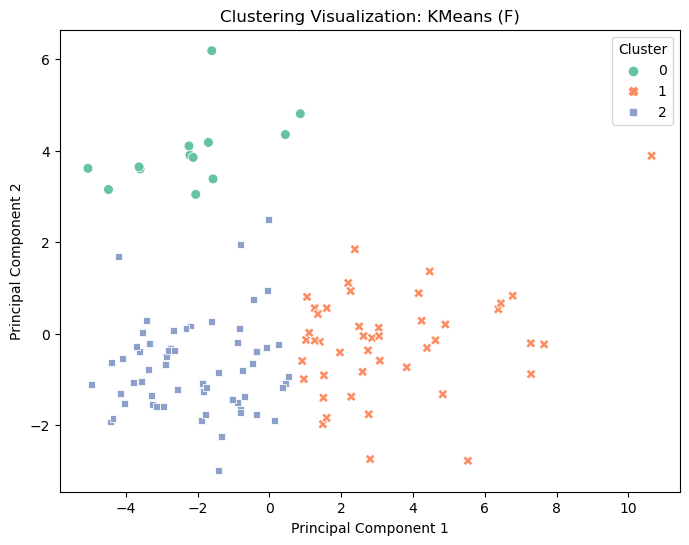

C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


GMM Silhouette Score: 0.1470


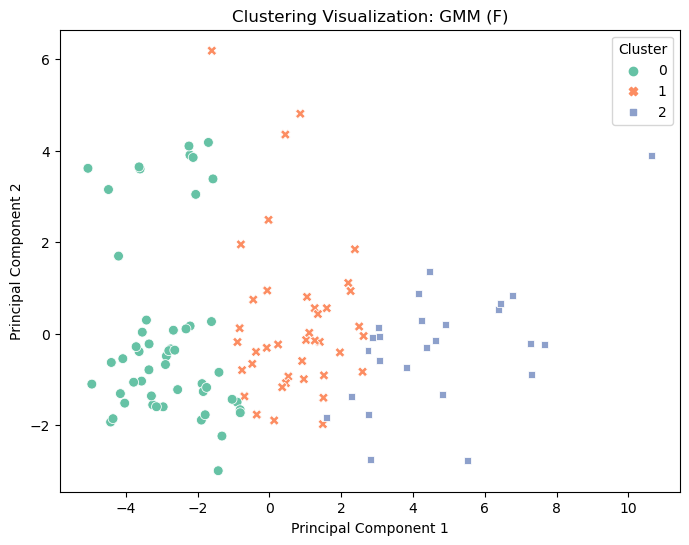

Agglomerative Silhouette Score: 0.2315


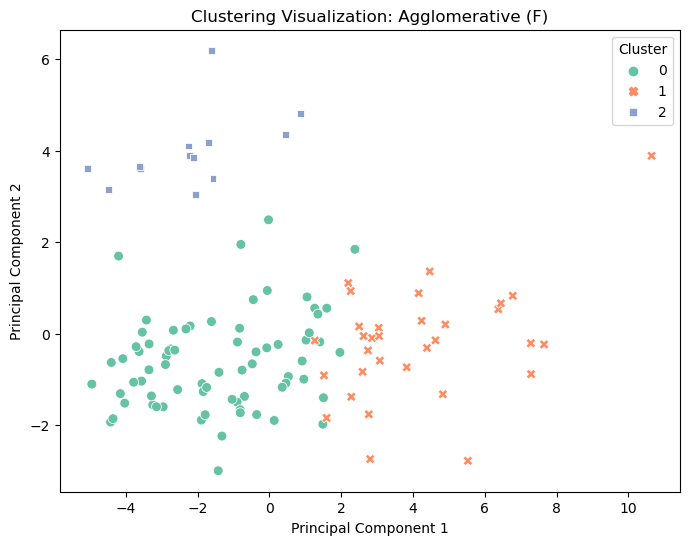


Processing Position: G


C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans Silhouette Score: 0.2140


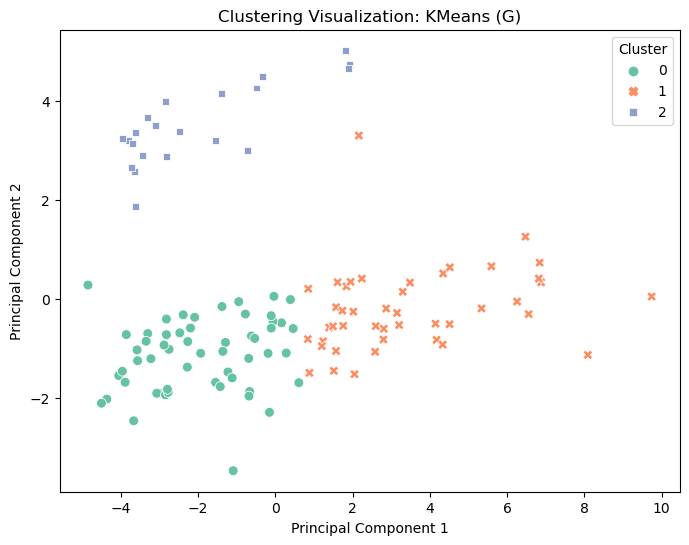

C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


GMM Silhouette Score: 0.2150


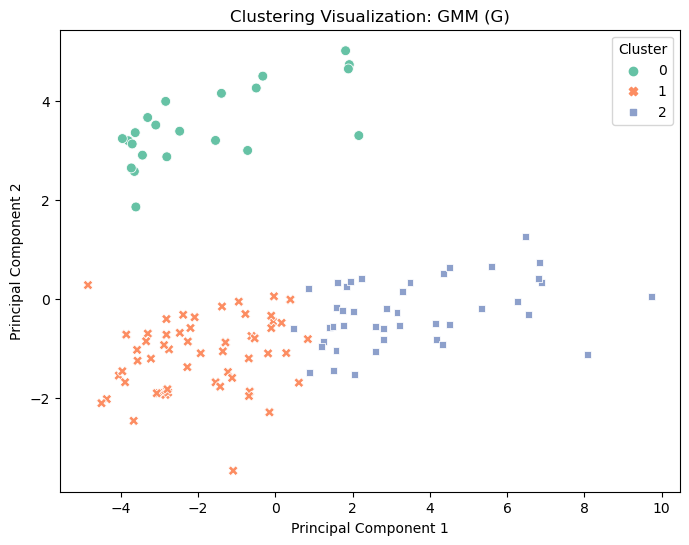

Agglomerative Silhouette Score: 0.1957


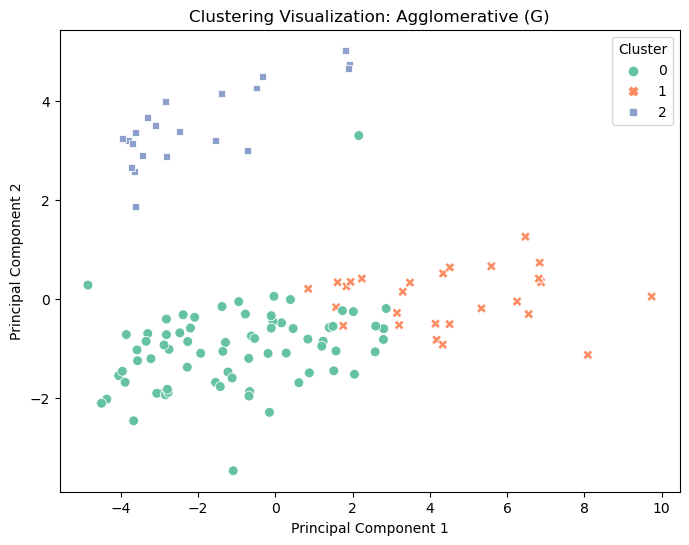


Processing Position: C


C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans Silhouette Score: 0.2728


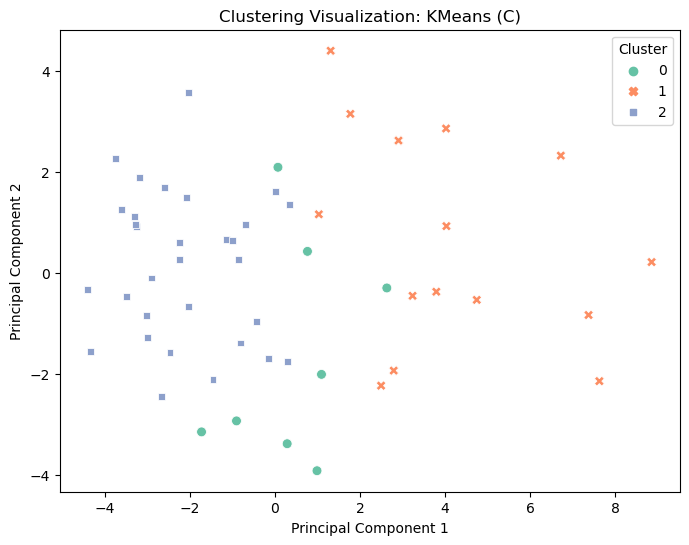

C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


GMM Silhouette Score: 0.2660


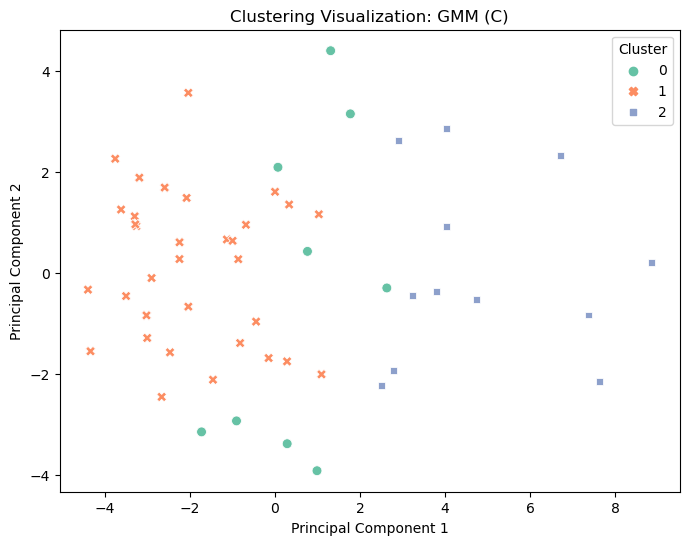

Agglomerative Silhouette Score: 0.2821


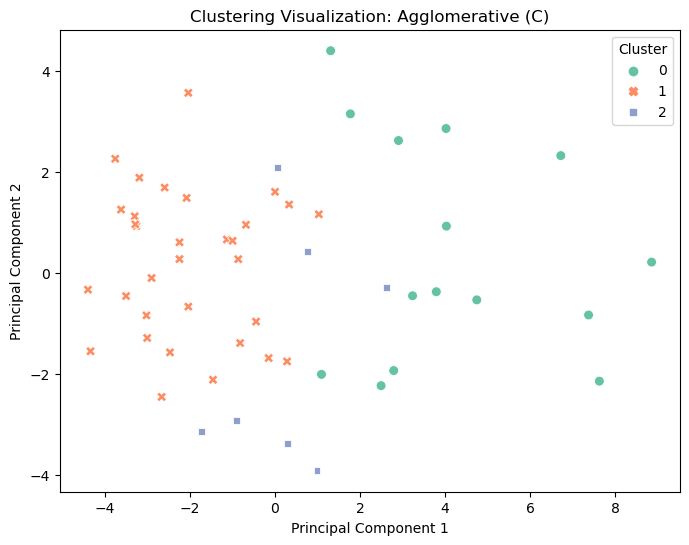


Position: F
KMeans - Silhouette Score: 0.2383
GMM - Silhouette Score: 0.1470
Agglomerative - Silhouette Score: 0.2315

Position: G
KMeans - Silhouette Score: 0.2140
GMM - Silhouette Score: 0.2150
Agglomerative - Silhouette Score: 0.1957

Position: C
KMeans - Silhouette Score: 0.2728
GMM - Silhouette Score: 0.2660
Agglomerative - Silhouette Score: 0.2821


In [78]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Function to apply PCA
def apply_pca(features, n_components=2):
    pca = PCA(n_components=n_components)
    pca_features = pca.fit_transform(features)
    return pca_features, pca

# Function to run clustering for each position
def run_clustering_by_position(df, features, n_clusters=3):
    clustering_results = {}

    for position in df['position'].unique():
        print(f"\nProcessing Position: {position}")
        
        # Subset data for the specific position
        position_data = df[df['position'] == position].copy()
        position_features = position_data[features]
        
        # Standardize features
        scaler = StandardScaler()
        standardized_features = scaler.fit_transform(position_features)

        # Apply PCA
        pca_features, pca = apply_pca(standardized_features)
        position_data['PCA1'], position_data['PCA2'] = pca_features[:, 0], pca_features[:, 1]

        # Clustering Models
        models = {
            "KMeans": KMeans(n_clusters=n_clusters, random_state=42),
            "GMM": GaussianMixture(n_components=n_clusters, random_state=42),
            "Agglomerative": AgglomerativeClustering(n_clusters=n_clusters)
        }

        position_clustering_results = {}

        for model_name, model in models.items():
            if model_name == "Agglomerative":
                labels = model.fit_predict(standardized_features)
            else:
                model.fit(standardized_features)
                labels = model.predict(standardized_features)

            position_data[f'{model_name}_Cluster'] = labels

            # Evaluate clustering using silhouette score
            silhouette = silhouette_score(standardized_features, labels)
            print(f"{model_name} Silhouette Score: {silhouette:.4f}")

            # Visualization
            plt.figure(figsize=(8, 6))
            sns.scatterplot(
                x=position_data['PCA1'],
                y=position_data['PCA2'],
                hue=labels,
                palette="Set2",
                style=labels,
                s=50
            )
            plt.title(f"Clustering Visualization: {model_name} ({position})")
            plt.xlabel('Principal Component 1')
            plt.ylabel('Principal Component 2')
            plt.legend(title='Cluster')
            plt.show()

            position_clustering_results[model_name] = {
                "Labels": labels,
                "Silhouette Score": silhouette,
                "PCA Explained Variance Ratio": pca.explained_variance_ratio_
            }

        clustering_results[position] = position_clustering_results

    return clustering_results

# Example Workflow
if __name__ == "__main__":
    # Use df_combined (make sure it is loaded in your environment)
    df = df_combined.copy()
    
    # Define features and target
    # features = ['estimatedOffensiveRating', 'offensiveRating', 'estimatedDefensiveRating',
    #             'defensiveRating', 'assistPercentage', 'reboundPercentage',
    #             'effectiveFieldGoalPercentage', 'trueShootingPercentage']
    target = 'position'  # Primary positions: G, F, C

    # Filter dataset to exclude rows with missing positions or features
    df = df.dropna(subset=[target] + features)

    # Run clustering per position
    clustering_results = run_clustering_by_position(df, features, n_clusters=3)

    # Example output: Access clustering results for a position
    for position, results in clustering_results.items():
        print(f"\nPosition: {position}")
        for model_name, result in results.items():
            print(f"{model_name} - Silhouette Score: {result['Silhouette Score']:.4f}")



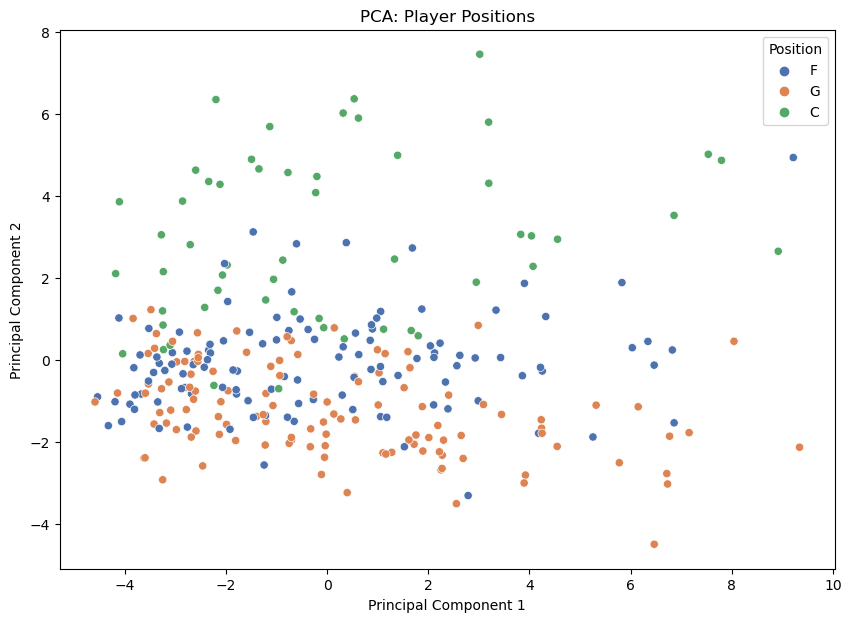


Processing with KMeans...


C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Accuracy for KMeans: 44.86%
Silhouette Score for KMeans: 0.1930


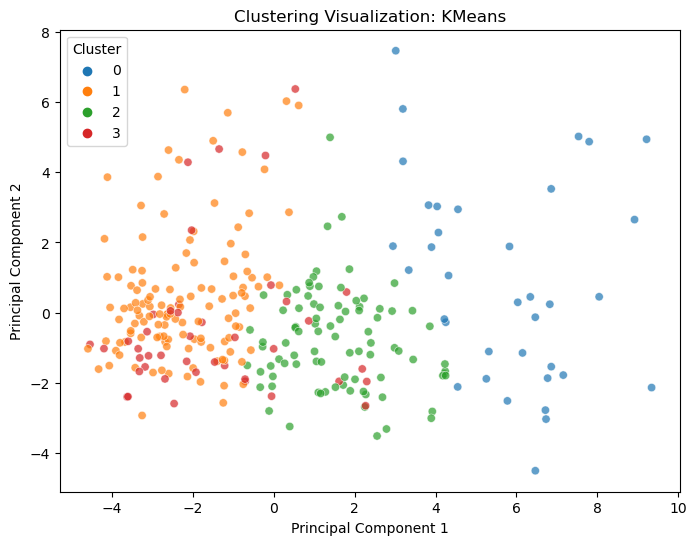


Processing with GMM...
Accuracy for GMM: 50.00%
Silhouette Score for GMM: 0.1503


C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


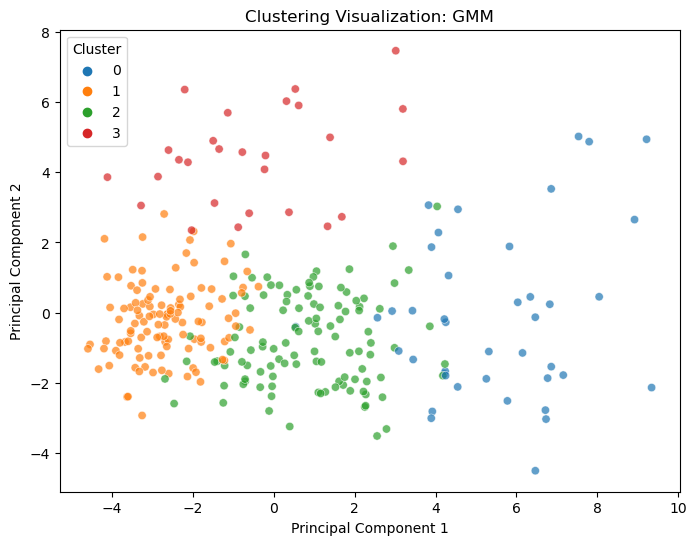


Processing with Agglomerative...
Accuracy for Agglomerative: 48.97%
Silhouette Score for Agglomerative: 0.2234


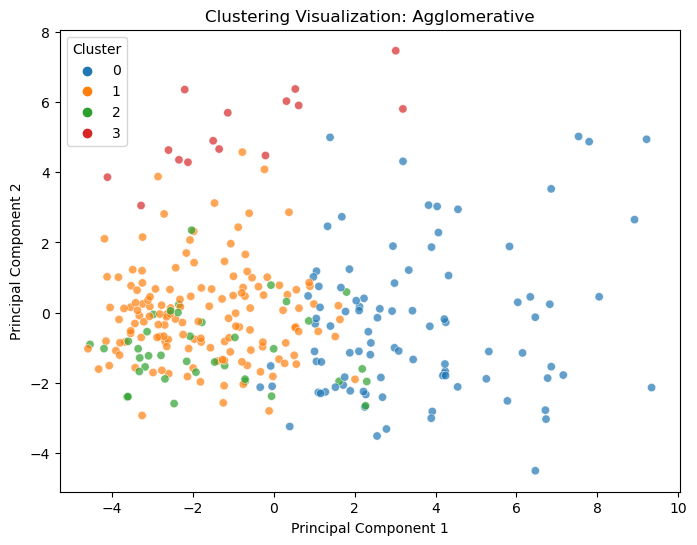


Processing with DBSCAN...
DBSCAN detected noise. Skipping accuracy evaluation.
KMeans: Accuracy=44.86%, Silhouette=0.1930
GMM: Accuracy=50.00%, Silhouette=0.1503
Agglomerative: Accuracy=48.97%, Silhouette=0.2234


In [79]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

# Data Preprocessing
# features = [
#     "estimatedOffensiveRating", "offensiveRating", "estimatedDefensiveRating",
#     "defensiveRating", "netRating", "assistPercentage", "reboundPercentage",
#     "trueShootingPercentage", "usagePercentage", "PIE"
# ]

df_filtered = df_combined.dropna(subset=features)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_filtered[features])

# PCA for Visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)
df_filtered['PC1'] = pca_result[:, 0]
df_filtered['PC2'] = pca_result[:, 1]

# Plot PCA
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', hue=df_filtered['position'], palette='deep', data=df_filtered)
plt.title("PCA: Player Positions")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Position")
plt.show()

# Function to Map Clusters to Labels
def map_clusters_to_labels(labels, true_labels):
    label_mapping = {}
    for cluster in np.unique(labels):
        cluster_labels = true_labels[labels == cluster]
        most_common_label = Counter(cluster_labels).most_common(1)[0][0]
        label_mapping[cluster] = most_common_label
    return np.vectorize(label_mapping.get)(labels)

# Clustering and Evaluation
models = {
    "KMeans": KMeans(n_clusters=4, random_state=42),
    "GMM": GaussianMixture(n_components=4, random_state=42),
    "Agglomerative": AgglomerativeClustering(n_clusters=4),
    "DBSCAN": DBSCAN(eps=1.5, min_samples=10)
}

results = {}
for model_name, model in models.items():
    print(f"\nProcessing with {model_name}...")
    if model_name == "DBSCAN":
        labels = model.fit_predict(scaled_features)
    else:
        model.fit(scaled_features)
        labels = model.predict(scaled_features) if hasattr(model, "predict") else model.labels_

    # Skip evaluation for models with -1 (noise) in labels
    if -1 in labels:
        print(f"{model_name} detected noise. Skipping accuracy evaluation.")
        continue

    # Map Clusters to True Labels and Evaluate
    mapped_labels = map_clusters_to_labels(labels, df_filtered['position'].values)
    accuracy = accuracy_score(df_filtered['position'], mapped_labels)
    silhouette = silhouette_score(scaled_features, labels) if len(np.unique(labels)) > 1 else -1
    results[model_name] = {"accuracy": accuracy, "silhouette": silhouette}

    print(f"Accuracy for {model_name}: {accuracy:.2%}")
    print(f"Silhouette Score for {model_name}: {silhouette:.4f}")

    # Visualization
    df_filtered['Cluster'] = labels
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x='PC1', y='PC2', hue='Cluster', palette='tab10', data=df_filtered, alpha=0.7
    )
    plt.title(f"Clustering Visualization: {model_name}")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title="Cluster")
    plt.show()

# Display Results
for model_name, metrics in results.items():
    print(f"{model_name}: Accuracy={metrics['accuracy']:.2%}, Silhouette={metrics['silhouette']:.4f}")



Position: F


C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chun

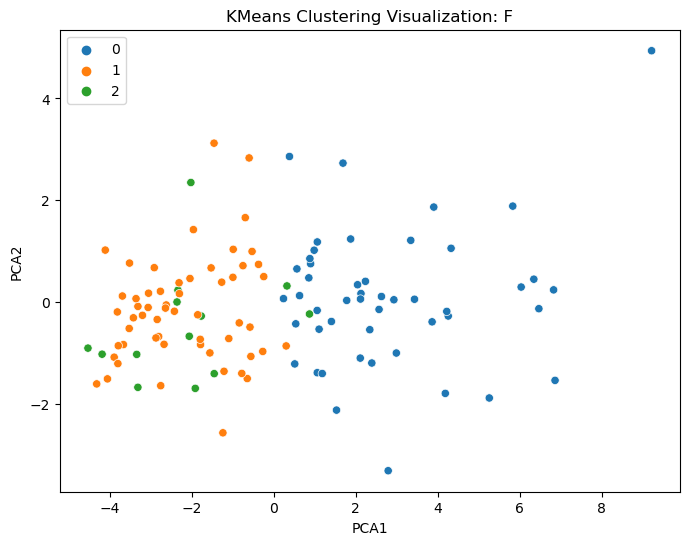

KMeans - Silhouette Score: 0.2500


C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


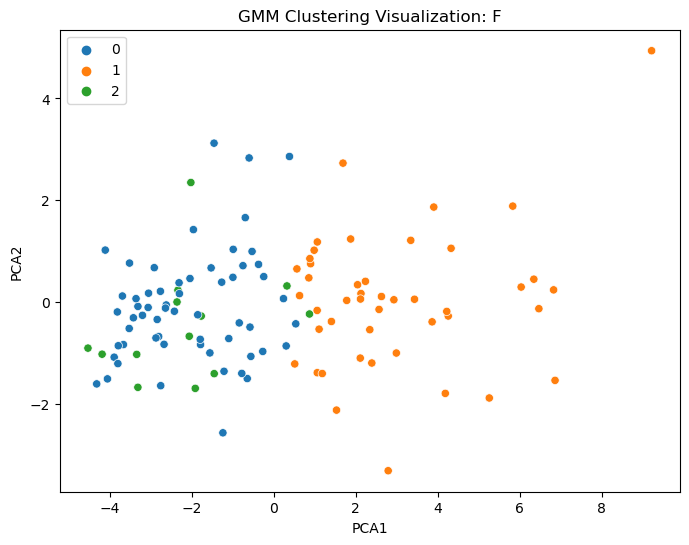

GMM - Silhouette Score: 0.2491


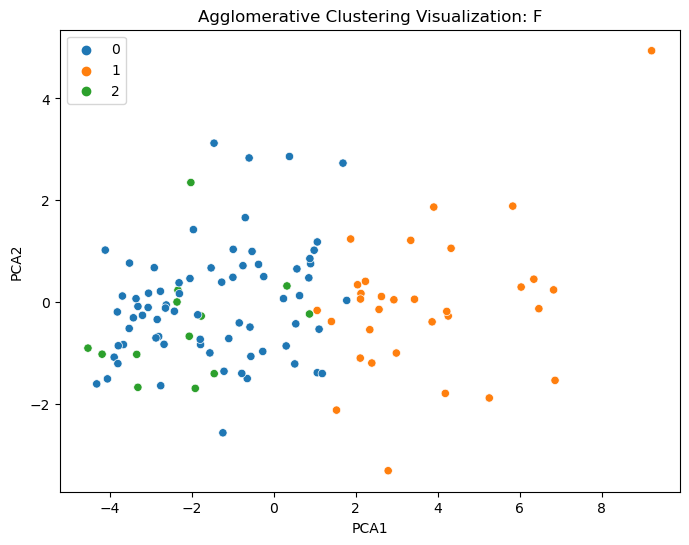

Agglomerative - Silhouette Score: 0.2456

Position: G


C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chun

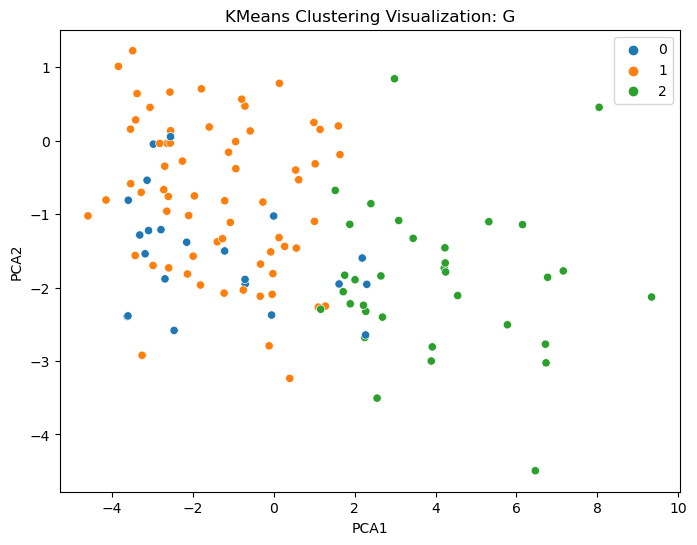

KMeans - Silhouette Score: 0.2701


C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


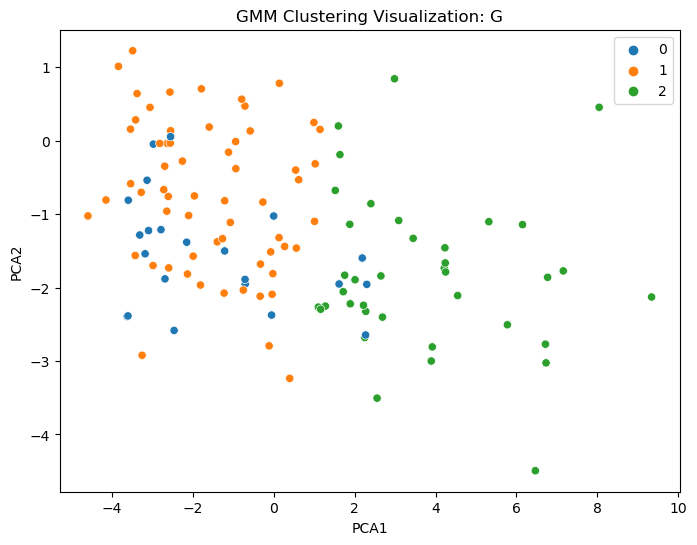

GMM - Silhouette Score: 0.2680


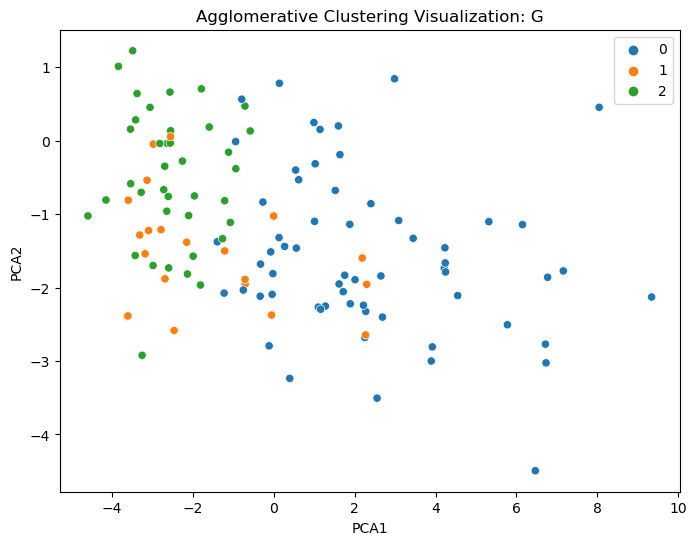

Agglomerative - Silhouette Score: 0.2270

Position: C


C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chun

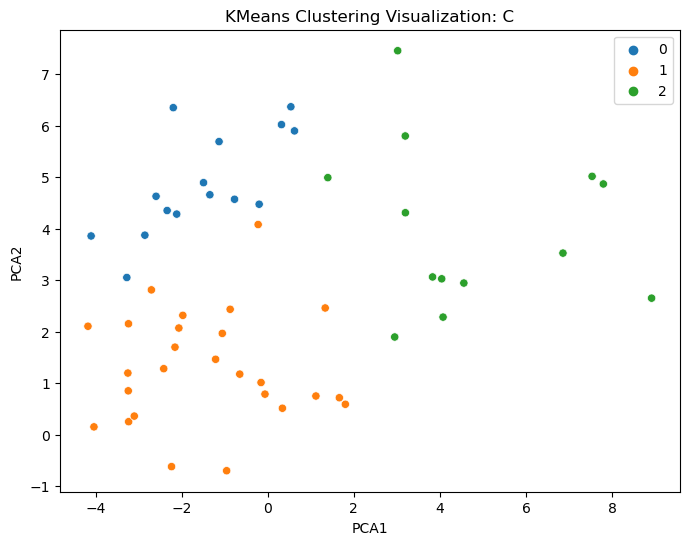

KMeans - Silhouette Score: 0.1776


C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


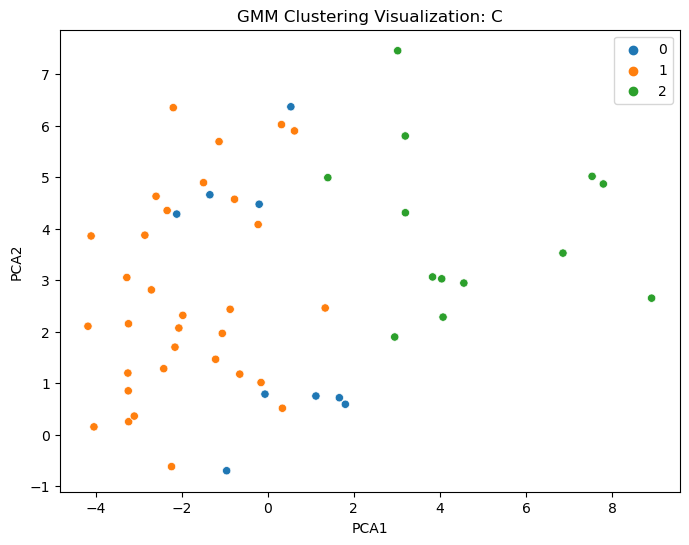

GMM - Silhouette Score: 0.2226


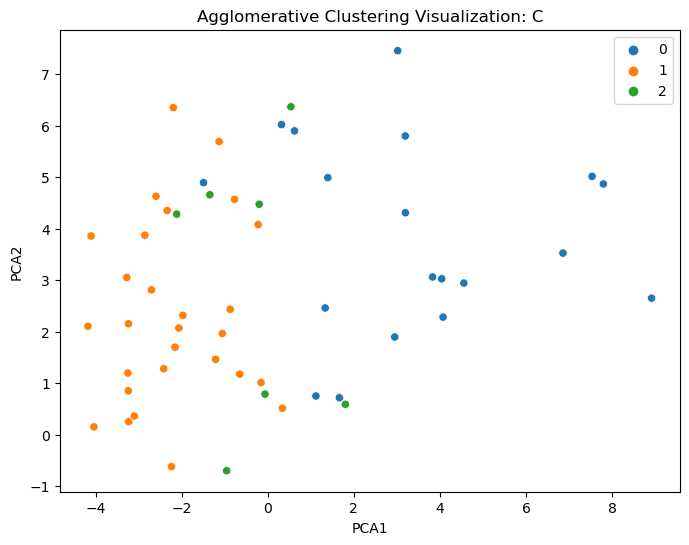

Agglomerative - Silhouette Score: 0.2310

Position: F
KMeans - Silhouette Score: 0.2500
GMM - Silhouette Score: 0.2491
Agglomerative - Silhouette Score: 0.2456

Position: G
KMeans - Silhouette Score: 0.2701
GMM - Silhouette Score: 0.2680
Agglomerative - Silhouette Score: 0.2270

Position: C
KMeans - Silhouette Score: 0.1776
GMM - Silhouette Score: 0.2226
Agglomerative - Silhouette Score: 0.2310


In [80]:
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure primary positions are labeled directly in the data
df_combined['Primary_Position'] = df_combined['position']  # Label positions directly

# Standardize the features
scaler = StandardScaler()
df_combined[features] = scaler.fit_transform(df_combined[features])

# Reduce dimensions using PCA for visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(df_combined[features])
df_combined['PCA1'], df_combined['PCA2'] = pca_features[:, 0], pca_features[:, 1]

# Initialize clustering models
clustering_models = {
    'KMeans': KMeans(n_clusters=3, random_state=42),
    'GMM': GaussianMixture(n_components=3, random_state=42),
    'Agglomerative': AgglomerativeClustering(n_clusters=3)
}

results = {}

# Perform clustering within each position
for position in df_combined['Primary_Position'].unique():
    position_data = df_combined[df_combined['Primary_Position'] == position]
    position_features = position_data[features]
    pca_position = position_data[['PCA1', 'PCA2']]

    print(f"\nPosition: {position}")
    results[position] = {}

    for model_name, model in clustering_models.items():
        # Fit model
        if model_name == 'GMM':
            labels = model.fit_predict(position_features)
        else:
            labels = model.fit(position_features).fit_predict(position_features)

        # Add clustering labels to the data
        df_combined.loc[position_data.index, f'{model_name}_Cluster'] = labels

        # Calculate silhouette score
        sil_score = silhouette_score(position_features, labels)
        results[position][model_name] = {'Silhouette Score': sil_score}

        # Visualization
        plt.figure(figsize=(8, 6))
        sns.scatterplot(
            x='PCA1', y='PCA2', hue=labels, palette='tab10', data=position_data, legend='full'
        )
        plt.title(f'{model_name} Clustering Visualization: {position}')
        plt.show()

        # Print silhouette score
        print(f"{model_name} - Silhouette Score: {sil_score:.4f}")

# Display summary results
for position, metrics in results.items():
    print(f"\nPosition: {position}")
    for model_name, scores in metrics.items():
        print(f"{model_name} - Silhouette Score: {scores['Silhouette Score']:.4f}")



Position: F


C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chun

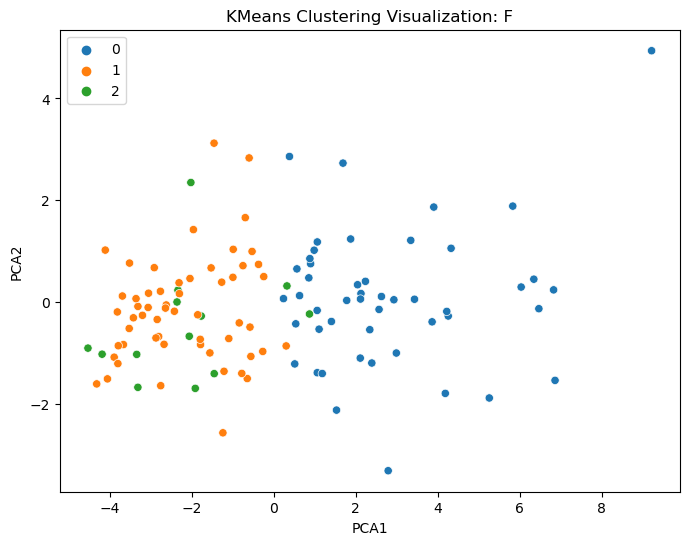

KMeans - Silhouette Score: 0.2500


C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


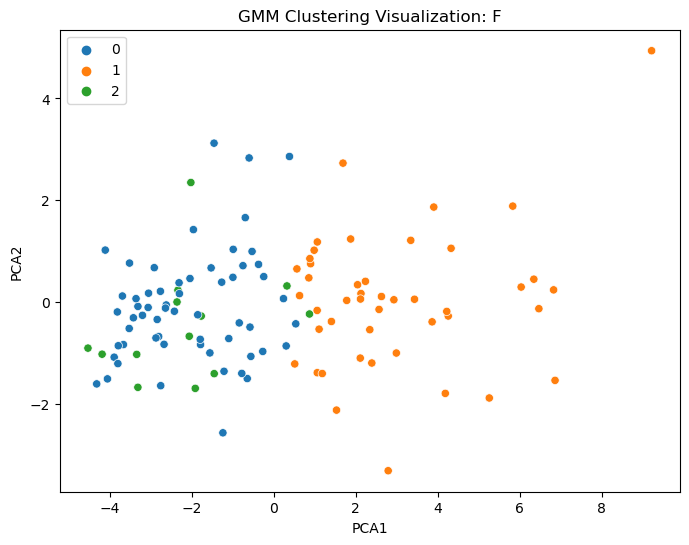

GMM - Silhouette Score: 0.2491


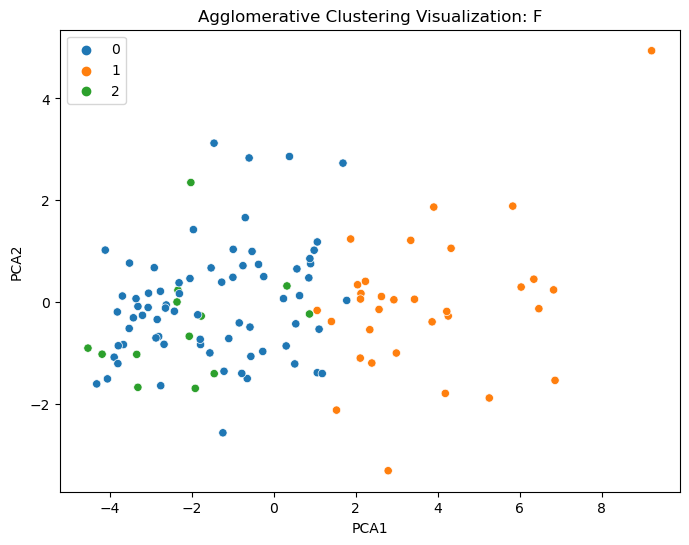

Agglomerative - Silhouette Score: 0.2456

Position: G


C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chun

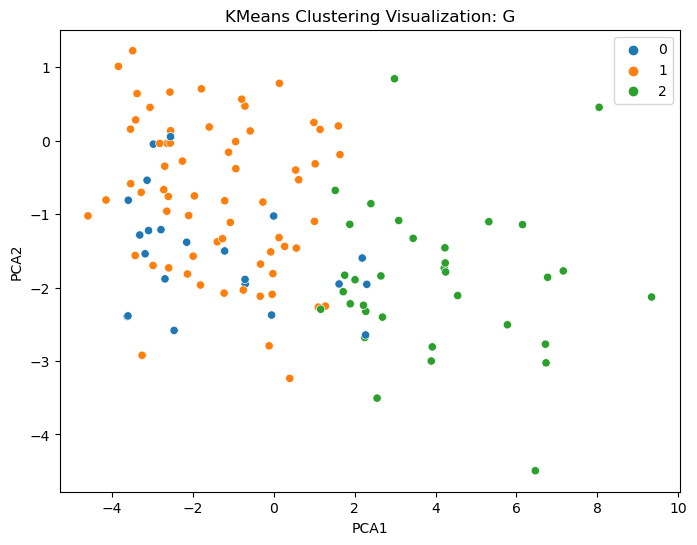

KMeans - Silhouette Score: 0.2701


C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


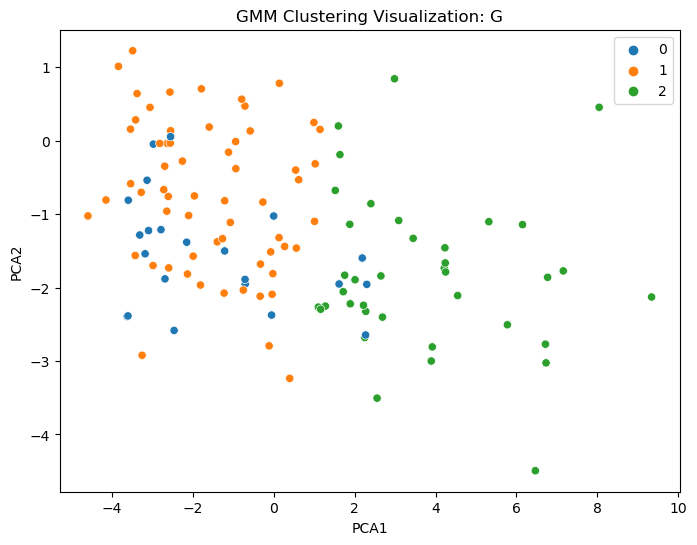

GMM - Silhouette Score: 0.2680


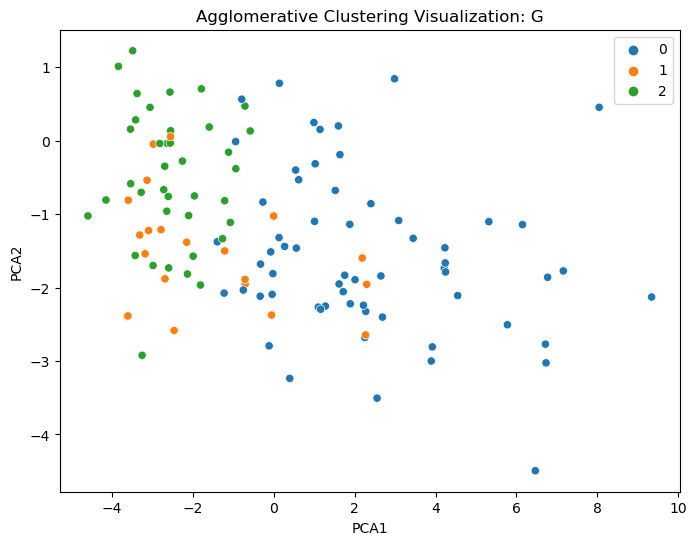

Agglomerative - Silhouette Score: 0.2270

Position: C


C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chun

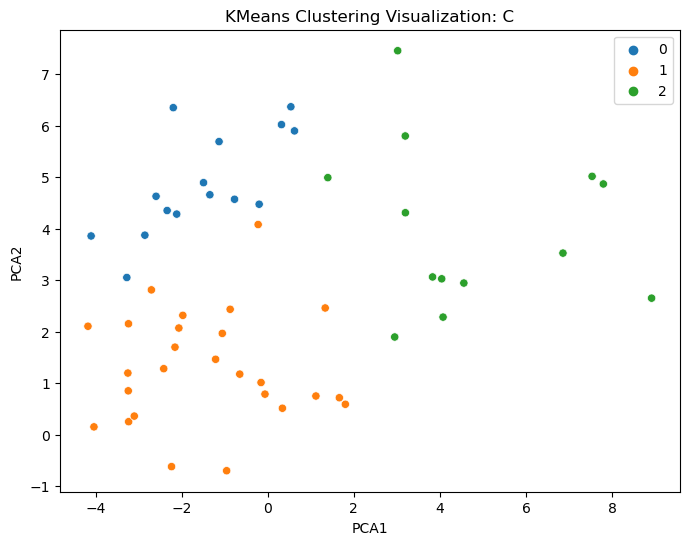

KMeans - Silhouette Score: 0.1776


C:\Users\nlomnitz\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


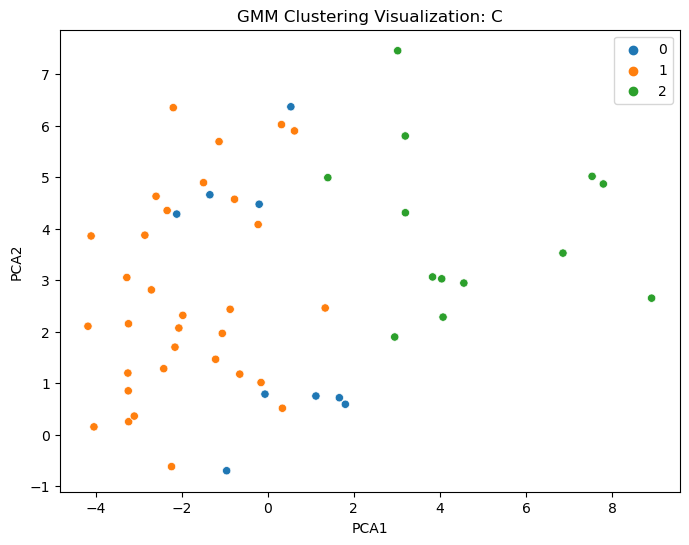

GMM - Silhouette Score: 0.2226


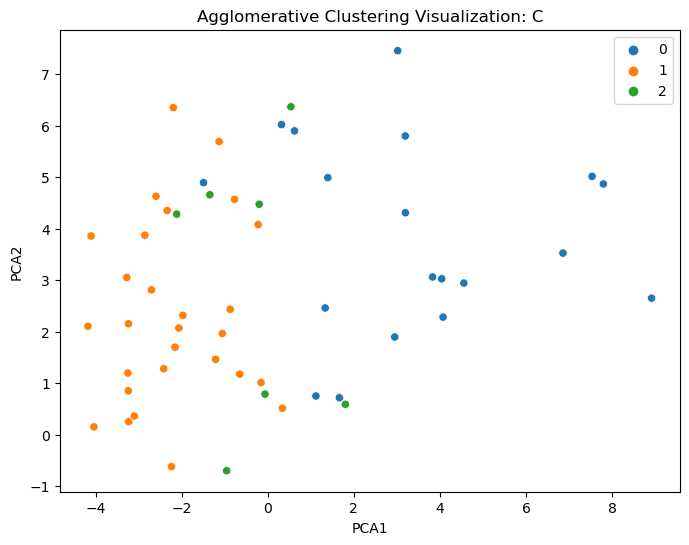

Agglomerative - Silhouette Score: 0.2310

Position: F
KMeans - Silhouette Score: 0.2500
GMM - Silhouette Score: 0.2491
Agglomerative - Silhouette Score: 0.2456

Position: G
KMeans - Silhouette Score: 0.2701
GMM - Silhouette Score: 0.2680
Agglomerative - Silhouette Score: 0.2270

Position: C
KMeans - Silhouette Score: 0.1776
GMM - Silhouette Score: 0.2226
Agglomerative - Silhouette Score: 0.2310


In [81]:
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure primary positions are labeled directly in the data
df_combined['Primary_Position'] = df_combined['position']  # Label positions directly

# Standardize the features
scaler = StandardScaler()
df_combined[features] = scaler.fit_transform(df_combined[features])

# Reduce dimensions using PCA for visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(df_combined[features])
df_combined['PCA1'], df_combined['PCA2'] = pca_features[:, 0], pca_features[:, 1]

# Initialize clustering models
clustering_models = {
    'KMeans': KMeans(n_clusters=3, random_state=42),
    'GMM': GaussianMixture(n_components=3, random_state=42),
    'Agglomerative': AgglomerativeClustering(n_clusters=3)
}

results = {}

# Perform clustering within each position
for position in df_combined['Primary_Position'].unique():
    position_data = df_combined[df_combined['Primary_Position'] == position]
    position_features = position_data[features]
    pca_position = position_data[['PCA1', 'PCA2']]

    print(f"\nPosition: {position}")
    results[position] = {}

    for model_name, model in clustering_models.items():
        # Fit model
        if model_name == 'GMM':
            labels = model.fit_predict(position_features)
        else:
            labels = model.fit(position_features).fit_predict(position_features)

        # Add clustering labels to the data
        df_combined.loc[position_data.index, f'{model_name}_Cluster'] = labels

        # Calculate silhouette score
        sil_score = silhouette_score(position_features, labels)
        results[position][model_name] = {'Silhouette Score': sil_score}

        # Visualization
        plt.figure(figsize=(8, 6))
        sns.scatterplot(
            x='PCA1', y='PCA2', hue=labels, palette='tab10', data=position_data, legend='full'
        )
        plt.title(f'{model_name} Clustering Visualization: {position}')
        plt.show()

        # Print silhouette score
        print(f"{model_name} - Silhouette Score: {sil_score:.4f}")

# Display summary results
for position, metrics in results.items():
    print(f"\nPosition: {position}")
    for model_name, scores in metrics.items():
        print(f"{model_name} - Silhouette Score: {scores['Silhouette Score']:.4f}")


## Final Model

In [83]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import export_text


# Print one tree from the Random Forest
def print_random_forest_tree(model, feature_names):
    tree = model.estimators_[0]  # Extract the first tree
    tree_text = export_text(tree, feature_names=feature_names)
    print("Decision Tree Text Representation:")
    print(tree_text)

# Step 1: Train a Classification Model to Predict Primary Position
def train_position_model(df, features, target):
    
    scaler = StandardScaler()
    X = scaler.fit_transform(df[features])
    y = df[target]
    
    # Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Random Forest Classifier
    model = RandomForestClassifier(random_state=42)
    print(model.decision_path)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print_random_forest_tree(position_model, features) 
    # Evaluate Model
    print("Classification Report for Position Prediction:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")
    
    # Return trained model and scaler
    return model, scaler, accuracy_score(y_test, y_pred)

# Step 2: Cluster Players into Archetypes Within Each Predicted Position
def cluster_archetypes(df, features, position_col, scaler):
    clustering_models = {
        "KMeans": KMeans(n_clusters=3, random_state=42),
        "Agglomerative": AgglomerativeClustering(n_clusters=3),
        "GMM": GaussianMixture(n_components=3, random_state=42),
    }

    # Standardize features
    scaled_features = scaler.transform(df[features])
    
    # PCA for visualization
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(scaled_features)
    df['PCA1'], df['PCA2'] = pca_features[:, 0], pca_features[:, 1]
    
    clustering_results = []
    
    for position in df[position_col].unique():
        position_data = df[df[position_col] == position]
        position_features = position_data[features]
        
        print(f"\nPosition: {position}")
        for model_name, model in clustering_models.items():
            model.fit(position_features)
            labels = model.predict(position_features) if hasattr(model, "predict") else model.labels_
            silhouette = silhouette_score(position_features, labels)
            print(f"{model_name} - Silhouette Score: {silhouette:.4f}")
            
            position_data[f"{model_name}_Cluster"] = labels
            clustering_results.append(position_data)

    return pd.concat(clustering_results, ignore_index=True)

# Step 3: Generate Final Table with Each Player's Archetype and Position
def generate_final_table(df, position_col, cluster_col):
    result_df = df[[position_col, cluster_col, 'PLAYER_NAME_x']].copy()
    result_df.rename(columns={
        position_col: 'Predicted_Position',
        cluster_col: 'Archetype'
    }, inplace=True)
    return result_df

# Main Script
target = 'Primary_Position'

# Train position prediction model
position_model, scaler, position_accuracy = train_position_model(df_combined, features, target)

# Predict positions and cluster
df_combined['Predicted_Position'] = position_model.predict(scaler.transform(df_combined[features]))
clustered_data = cluster_archetypes(df_combined, features, 'Predicted_Position', scaler)

# Generate final table with each player's archetype and predicted position
final_table = generate_final_table(clustered_data, 'Predicted_Position', 'Agglomerative_Cluster')
print("\nFinal Table:")
print(final_table)

# Visualize clustering results for each position and archetype
positions = df_combined['Predicted_Position'].unique()
for position in positions:
    position_data = clustered_data[clustered_data['Predicted_Position'] == position]
    
    plt.figure(figsize=(8, 6))
    plt.scatter(
        position_data['PCA1'], 
        position_data['PCA2'], 
        c=position_data['KMeans_Cluster'], 
        cmap='viridis', 
        label=position
    )
    plt.title(f"Clustering Visualization for Position {position}")
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.colorbar(label='Archetype')
    plt.legend()
    plt.show()

# Report position prediction accuracy
print(f"Position Prediction Accuracy: {position_accuracy:.2%}")


<bound method BaseForest.decision_path of RandomForestClassifier(random_state=42)>


NameError: name 'position_model' is not defined

## Final Position & Archetype Table

Classification Report for Position Prediction:
              precision    recall  f1-score   support

           C       0.77      0.67      0.71        15
           F       0.60      0.65      0.63        23
           G       0.71      0.71      0.71        21

    accuracy                           0.68        59
   macro avg       0.69      0.68      0.68        59
weighted avg       0.68      0.68      0.68        59

Accuracy: 67.80%

Position: F
Agglomerative - Silhouette Score: 0.2586

Position: G
Agglomerative - Silhouette Score: 0.2424

Position: C
Agglomerative - Silhouette Score: 0.2239

Final Table:
  Predicted_Position  Archetype  \
0                  C          0   
1                  C          1   
2                  C          2   
3                  F          0   
4                  F          1   
5                  F          2   
6                  G          0   
7                  G          1   
8                  G          2   

                            

C:\Users\nlomnitz\AppData\Local\Temp\ipykernel_18392\1753409133.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  position_data[f"{model_name}_Cluster"] = labels
C:\Users\nlomnitz\AppData\Local\Temp\ipykernel_18392\1753409133.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  position_data[f"{model_name}_Cluster"] = labels
C:\Users\nlomnitz\AppData\Local\Temp\ipykernel_18392\1753409133.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

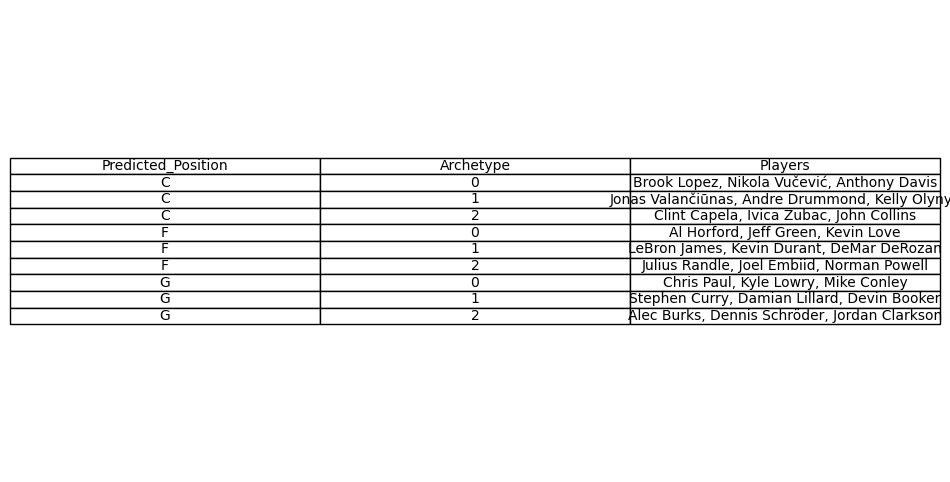

In [84]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Step 1: Train a Classification Model to Predict Primary Position
def train_position_model(df, features, target):
    scaler = StandardScaler()
    X = scaler.fit_transform(df[features])
    y = df[target]
    
    # Train/Test Split
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Random Forest Classifier
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Evaluate Model
    print("Classification Report for Position Prediction:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")
    
    # Return trained model and scaler
    return model, scaler

# Step 2: Cluster Players into Archetypes Within Each Predicted Position
def cluster_archetypes(df, features, position_col, scaler):
    archetype_results = []
    clustering_models = {
        "Agglomerative": AgglomerativeClustering(n_clusters=3)
    }

    # Standardize features
    scaled_features = scaler.transform(df[features])
    
    # PCA for visualization
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(scaled_features)
    df['PCA1'], df['PCA2'] = pca_features[:, 0], pca_features[:, 1]
    
    for position in df[position_col].unique():
        position_data = df[df[position_col] == position]
        position_features = position_data[features]
        
        print(f"\nPosition: {position}")
        for model_name, model in clustering_models.items():
            model.fit(position_features)
            labels = model.predict(position_features) if hasattr(model, "predict") else model.labels_
            silhouette = silhouette_score(position_features, labels)
            print(f"{model_name} - Silhouette Score: {silhouette:.4f}")
            
            # Add clustering results
            position_data[f"{model_name}_Cluster"] = labels
            archetype_results.append(position_data)
    
    return pd.concat(archetype_results, ignore_index=True)

# Step 3: Generate Final Table
def generate_final_table(df, position_col, cluster_col):
    grouped = df.groupby([position_col, cluster_col])['PLAYER_NAME_x'].apply(list).reset_index()
    grouped['Players'] = grouped['PLAYER_NAME_x'].apply(lambda x: ", ".join(x[:3]))  # Show up to 3 players
    grouped.drop('PLAYER_NAME_x', axis=1, inplace=True)
    grouped.rename(columns={cluster_col: 'Archetype'}, inplace=True)
    return grouped

# Main Script
target = 'Primary_Position'

# Train position prediction model
position_model, scaler = train_position_model(df_combined, features, target)

# Predict positions and cluster
df_combined['Predicted_Position'] = position_model.predict(scaler.transform(df_combined[features]))
clustered_data = cluster_archetypes(df_combined, features, 'Predicted_Position', scaler)

# Generate final table
final_table = generate_final_table(clustered_data, 'Predicted_Position', 'Agglomerative_Cluster')
print("\nFinal Table:")
print(final_table)

# Display table
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('tight')
ax.axis('off')
table = ax.table(
    cellText=final_table.values,
    colLabels=final_table.columns,
    loc='center',
    cellLoc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(10)
plt.show()


# Business Cases

# Season to Season consistency

In [89]:
df_combined_23_24 = df_combined[['PLAYER_ID', 'PLAYER_NAME_x', 'Predicted_Position', 'KMeans_Cluster']]

# Rename the columns in df_combined_filtered
df_combined_23_24 = df_combined_23_24.rename(
    columns={
        "Predicted_Position": "POSITION_23_24",
        "KMeans_Cluster": "KMeans_Cluster_23_24"
    }
)

df_combined_23_24.to_csv(r'df_combined_23_24.csv')

In [93]:
df_combined_24_25 = pd.read_csv(r'df_combined_24_25.csv')

df_combined_23_24_25 = pd.merge(df_combined_23_24, df_combined_24_25, on=['PLAYER_ID', 'PLAYER_NAME_x'])

# Create a new column to check if the values match in the specified columns
df_combined_23_24_25['Position_Match'] = df_combined_23_24_25['POSITION_23_24'] == df_combined_23_24_25['POSITION_24_25']
df_combined_23_24_25['Cluster_Match'] = df_combined_23_24_25['KMeans_Cluster_23_24'] == df_combined_23_24_25['KMeans_Cluster_24_25']

# Create a new column that checks if both Position_Match and Cluster_Match are True
df_combined_23_24_25['Both_Match'] = df_combined_23_24_25['Position_Match'] & df_combined_23_24_25['Cluster_Match']

In [95]:
# Calculate total number of rows
total_rows = len(df_combined_23_24_25)

# Calculate percentages
position_match_percentage = (df_combined_23_24_25['Position_Match'].sum() / total_rows) * 100
cluster_match_percentage = (df_combined_23_24_25['Cluster_Match'].sum() / total_rows) * 100
both_match_percentage = (df_combined_23_24_25['Both_Match'].sum() / total_rows) * 100

# Display the percentages
print(f"Percentage of Position Matches: {position_match_percentage:.2f}%")
print(f"Percentage of Cluster Matches: {cluster_match_percentage:.2f}%")
print(f"Percentage of Both Matches: {both_match_percentage:.2f}%")

Percentage of Position Matches: 78.53%
Percentage of Cluster Matches: 43.56%
Percentage of Both Matches: 33.74%


In [97]:
df_combined_23_24_25.to_csv(r'df_combined_23_24_25.csv')

# Free Agency Application

In [101]:
combined_stats = combined_stats[['PLAYER_ID', 'TEAM_ID']]

combined_stats.drop_duplicates(inplace=True)

combined_stats.reset_index(inplace=True, drop=True)

In [103]:
teams_and_players_with_classifications = pd.merge(combined_stats, df_combined_23_24, on='PLAYER_ID')

In [105]:
free_agent_in_23_24_key = pd.read_csv(r'was_free_agent_23_24.csv')

list_of_fa_23_24 = free_agent_in_23_24_key[free_agent_in_23_24_key['Is_Free_Agent_23_24'] == 1]

list_of_fa_23_24.reset_index(inplace=True, drop=True)

list_of_players_not_in_fa_23_24 = free_agent_in_23_24_key[free_agent_in_23_24_key['Is_Free_Agent_23_24'] == 0]

list_of_players_not_in_fa_23_24.reset_index(inplace=True, drop=True)

In [107]:
mavericks_roster = teams_and_players_with_classifications[teams_and_players_with_classifications['TEAM_ID'] == 1610612742]

In [117]:
mavericks_roster_going_into_fa = pd.merge(mavericks_roster, list_of_players_not_in_fa_23_24, on='PLAYER_ID')

mavericks_roster_going_into_fa.drop_duplicates(inplace=True)

mavericks_roster_into_fa_sorted = mavericks_roster_going_into_fa.sort_values(by='POSITION_23_24')

print(mavericks_roster_into_fa_sorted[['PLAYER_NAME_x', 'POSITION_23_24', 'KMeans_Cluster_23_24']])

       PLAYER_NAME_x POSITION_23_24  KMeans_Cluster_23_24
0     Daniel Gafford              C                   0.0
3   Dereck Lively II              C                   0.0
4      Dwight Powell              C                   1.0
10       Maxi Kleber              C                   1.0
6         Josh Green              F                   1.0
11   P.J. Washington              F                   0.0
1         Danté Exum              G                   0.0
5        Jaden Hardy              G                   1.0
7       Kyrie Irving              G                   2.0
8        Luka Dončić              G                   2.0
12  Tim Hardaway Jr.              G                   1.0


In [119]:
list_of_fa_with_classifications = pd.merge(teams_and_players_with_classifications, list_of_fa_23_24, on='PLAYER_ID')


In [125]:
filtered_df = list_of_fa_with_classifications[
    (list_of_fa_with_classifications['POSITION_23_24'] == 'F') &
    (list_of_fa_with_classifications['KMeans_Cluster_23_24'].isin([2]))
]

# Display the filtered DataFrame
print(filtered_df[['PLAYER_NAME_x', 'POSITION_23_24', 'KMeans_Cluster_23_24']])


        PLAYER_NAME_x POSITION_23_24  KMeans_Cluster_23_24
0   Derrick Jones Jr.              F                   2.0
16   Patrick Williams              F                   2.0
44  Simone Fontecchio              F                   2.0
58      Naji Marshall              F                   2.0


# Collecting Team and Player IDs from past NBA Champions

### List of Previous 20 NBA Champions

2023-24 — Boston Celtics def. Dallas Mavericks, 4-1

2022-23 — Denver Nuggets def. Miami Heat, 4-1

2021-22 — Golden State Warriors def. Boston Celtics, 4-2

2020-21 — Milwaukee Bucks def. Phoenix Suns, 4-2

2019-20 — Los Angeles Lakers def. Miami Heat, 4-2

2018-19 — Toronto Raptors def. Golden State Warriors, 4-2

2017-18 — Golden State Warriors def. Cleveland Cavaliers, 4-0

2016-17 — Golden State Warriors def. Cleveland Cavaliers, 4-1

2015-16 — Cleveland Cavaliers def. Golden State Warriors, 4-3

2014-15 — Golden State Warriors def. Cleveland Cavaliers, 4-2

2013-14 — San Antonio Spurs def. Miami Heat, 4-1

2012-13 — Miami Heat def. San Antonio Spurs, 4-3

2011-12 — Miami Heat def. Oklahoma City Thunder, 4-1

2010-11 — Dallas Mavericks def. Miami Heat, 4-2

2009-10 — Los Angeles Lakers def. Boston Celtics, 4-3 

2008-09 — Los Angeles Lakers def. Orlando Magic, 4-1

2007-08 — Boston Celtics def. Los Angeles Lakers, 4-2

2006-07 — San Antonio Spurs def. Cleveland Cavaliers, 4-0

2005-06 — Miami Heat def. Dallas Mavericks, 4-2

2004-05 — San Antonio Spurs def. Detroit Pistons, 4-3

## Retrieve Team ID and Roster Information for Each NBA Championship

In [ ]:
from nba_api.stats.endpoints import commonteamroster
from nba_api.stats.static import teams

# Step 1: Hard-coded list of NBA champions (replace with API pull for dynamic updating)
def get_last_20_champions():
    champions = [
        {"year": 2024, "team_name": "Boston Celtics"},
        {"year": 2023, "team_name": "Denver Nuggets"},
        {"year": 2022, "team_name": "Golden State Warriors"},
        {"year": 2021, "team_name": "Milwaukee Bucks"},
        {"year": 2020, "team_name": "Los Angeles Lakers"},
        {"year": 2019, "team_name": "Toronto Raptors"},
        {"year": 2018, "team_name": "Golden State Warriors"},
        {"year": 2017, "team_name": "Golden State Warriors"},
        {"year": 2016, "team_name": "Cleveland Cavaliers"},
        {"year": 2015, "team_name": "Golden State Warriors"},
        {"year": 2014, "team_name": "San Antonio Spurs"},
        {"year": 2013, "team_name": "Miami Heat"},
        {"year": 2012, "team_name": "Miami Heat"},
        {"year": 2011, "team_name": "Dallas Mavericks"},
        {"year": 2010, "team_name": "Los Angeles Lakers"},
        {"year": 2009, "team_name": "Los Angeles Lakers"},
        {"year": 2008, "team_name": "Boston Celtics"},
        {"year": 2007, "team_name": "San Antonio Spurs"},
        {"year": 2006, "team_name": "Miami Heat"},
        {"year": 2005, "team_name": "San Antonio Spurs"}
    ]
    return champions

# Step 2: Map champion team names to team IDs
def get_team_ids(champions):
    team_dict = teams.get_teams()
    team_ids = {}
    for champion in champions:
        for team in team_dict:
            if champion["team_name"] == team["full_name"]:
                team_ids[champion["year"]] = {"team_id": team["id"], "team_name": team["full_name"]}
    return team_ids

# Step 3: Get player names and IDs for each team's roster in their championship year
def get_championship_rosters(team_ids):
    rosters = {}
    for year, team_info in team_ids.items():
        team_id = team_info["team_id"]
        team_name = team_info["team_name"]
        season = f"{year-1}-{str(year)[-2:]}"  # Format like "2022-23"
        try:
            roster = commonteamroster.CommonTeamRoster(team_id=team_id, season=season)
            players = roster.common_team_roster.get_dict()["data"]
            rosters[year] = {
                "team_name": team_name,
                "team_id": team_id,
                "players": [{"player_name": player[3], "player_id": player[0]} for player in players]
            }
        except Exception as e:
            print(f"Error fetching roster for {team_name} ({year}): {e}")
    return rosters

# Execute the functions
champions = get_last_20_champions()
team_ids = get_team_ids(champions)
championship_rosters = get_championship_rosters(team_ids)

# Output results
print("Team IDs of Last 20 Champions:")
for year, info in team_ids.items():
    print(f"{year}: {info['team_name']} (Team ID: {info['team_id']})")

print("\nPlayer Rosters of Championship Teams:")
for year, roster in championship_rosters.items():
    print(f"\nYear: {year}, Team: {roster['team_name']} (Team ID: {roster['team_id']})")
    for player in roster["players"]:
        print(f" - Player Name: {player['player_name']}, Player ID: {player['player_id']}")


Team IDs of Last 20 Champions:
2024: Boston Celtics (Team ID: 1610612738)
2023: Denver Nuggets (Team ID: 1610612743)
2022: Golden State Warriors (Team ID: 1610612744)
2021: Milwaukee Bucks (Team ID: 1610612749)
2020: Los Angeles Lakers (Team ID: 1610612747)
2019: Toronto Raptors (Team ID: 1610612761)
2018: Golden State Warriors (Team ID: 1610612744)
2017: Golden State Warriors (Team ID: 1610612744)
2016: Cleveland Cavaliers (Team ID: 1610612739)
2015: Golden State Warriors (Team ID: 1610612744)
2014: San Antonio Spurs (Team ID: 1610612759)
2013: Miami Heat (Team ID: 1610612748)
2012: Miami Heat (Team ID: 1610612748)
2011: Dallas Mavericks (Team ID: 1610612742)
2010: Los Angeles Lakers (Team ID: 1610612747)
2009: Los Angeles Lakers (Team ID: 1610612747)
2008: Boston Celtics (Team ID: 1610612738)
2007: San Antonio Spurs (Team ID: 1610612759)
2006: Miami Heat (Team ID: 1610612748)
2005: San Antonio Spurs (Team ID: 1610612759)

Player Rosters of Championship Teams:

Year: 2024, Team: Bosto

# Data Collection for NBA Championship Rosters

In [ ]:
from nba_api.stats.endpoints import leaguegamefinder, commonteamroster, BoxScoreAdvancedV3, ShotChartDetail
from nba_api.stats.endpoints import LeagueDashPlayerStats
from nba_api.stats.static import teams
from requests.exceptions import RequestException
import pandas as pd
import time

# Step 1: Hardcoded list of NBA champions
def get_last_20_champions():
    return [
        {"year": 2024, "team_name": "Boston Celtics"},
        {"year": 2023, "team_name": "Denver Nuggets"},
        {"year": 2022, "team_name": "Golden State Warriors"},
        {"year": 2021, "team_name": "Milwaukee Bucks"},
        {"year": 2020, "team_name": "Los Angeles Lakers"},
        {"year": 2019, "team_name": "Toronto Raptors"},
        {"year": 2018, "team_name": "Golden State Warriors"},
        {"year": 2017, "team_name": "Golden State Warriors"},
        {"year": 2016, "team_name": "Cleveland Cavaliers"},
        {"year": 2015, "team_name": "Golden State Warriors"},
        {"year": 2014, "team_name": "San Antonio Spurs"},
        {"year": 2013, "team_name": "Miami Heat"},
        {"year": 2012, "team_name": "Miami Heat"},
        {"year": 2011, "team_name": "Dallas Mavericks"},
        {"year": 2010, "team_name": "Los Angeles Lakers"},
        {"year": 2009, "team_name": "Los Angeles Lakers"},
        {"year": 2008, "team_name": "Boston Celtics"},
        {"year": 2007, "team_name": "San Antonio Spurs"},
        {"year": 2006, "team_name": "Miami Heat"},
        {"year": 2005, "team_name": "San Antonio Spurs"}
    ]

# Step 2: Fetch team IDs for champions
def get_team_ids(champions):
    team_dict = teams.get_teams()
    return {champion["year"]: {"team_id": next(team["id"] for team in team_dict if team["full_name"] == champion["team_name"]),
                               "team_name": champion["team_name"]} for champion in champions}

# Step 3: Pull advanced stats, traditional stats, and shot chart data for each championship team
def pull_data_for_teams(team_ids):
    advanced_stats, traditional_stats, shot_chart_data, clutch_stats, lineup_stats, player_roster_data = [], [], [], [], [], []

    for year, team_info in team_ids.items():
        team_id = team_info["team_id"]
        team_name = team_info["team_name"]
        season = f"{year-1}-{str(year)[-2:]}"
        print(f"\nPulling data for {team_name} in season {season}...")

        # Sleep for 2.5 minutes between seasons
        print("Pausing for 2.5 minutes to respect rate limits...")
        time.sleep(150)

        # Fetch games for the team in the championship season
        try:
            print(f"Fetching game IDs for {team_name} in season {season}...")
            for attempt in range(3):  # Retry up to 3 times
                try:
                    gamefinder = leaguegamefinder.LeagueGameFinder(season_nullable=season, team_id_nullable=team_id)
                    games = gamefinder.get_data_frames()[0]
                    if games.empty:
                        print(f"No game data returned for {team_name} in season {season}.")
                        break
                    game_ids = games['GAME_ID'].unique().tolist()
                    print(f"Found {len(game_ids)} games for {team_name}.")
                    break
                except RequestException as e:
                    print(f"Request failed (attempt {attempt + 1}/3): {e}")
                    time.sleep(5)  # Wait before retrying
                except Exception as e:
                    print(f"Unexpected error fetching games for {team_name}: {e}")
                    break
            else:
                print(f"Failed to fetch game data for {team_name} after 3 attempts.")
                continue
        except Exception as e:
            print(f"Error fetching games for {team_name}: {e}")
            continue

        # Pull advanced box score stats and extract player-team pairs
        player_team_ids = set()
        print(f"Pulling advanced box score stats for {team_name}...")
        for game_id in game_ids:
            success = False
            for attempt in range(3):  # Retry up to 3 times
                try:
                    boxscore = BoxScoreAdvancedV3(game_id=game_id)
                    if boxscore.player_stats:
                        player_stats_dict = boxscore.player_stats.get_dict()
                        headers = player_stats_dict["headers"]
                        person_id_index = headers.index("personId")
                        team_id_index = headers.index("teamId")

                        for stat in player_stats_dict["data"]:
                            player_team_ids.add((stat[person_id_index], stat[team_id_index]))

                        advanced_stats.extend(player_stats_dict["data"])
                        print(f"Advanced stats for game {game_id} pulled successfully.")
                        success = True
                    time.sleep(1)  # Respect rate limits
                    break  # Exit retry loop on success
                except Exception as e:
                    print(f"Attempt {attempt + 1} failed for game {game_id}: {e}")
                    time.sleep(5)  # Wait before retrying

            if not success:
                print(f"Failed to pull advanced stats for game {game_id} after 3 attempts.")

        print(f"Extracted {len(player_team_ids)} unique player-team pairs for {team_name}.")


        # Pull traditional stats to get player IDs and names
        print(f"Pulling traditional stats for {team_name}...")
        team_player_data = []  # To store player ID and names
        try:
            leaguedash = LeagueDashPlayerStats(season=season, team_id_nullable=team_id)
            traditional_stats_data = leaguedash.league_dash_player_stats.get_dict()["data"]
            traditional_stats_headers = leaguedash.league_dash_player_stats.get_dict()["headers"]
            traditional_stats.extend(traditional_stats_data)

            # Extract player IDs and names
            player_id_index = traditional_stats_headers.index("PLAYER_ID")
            player_name_index = traditional_stats_headers.index("PLAYER_NAME")
            team_player_data = [(stat[player_id_index], stat[player_name_index]) for stat in traditional_stats_data]
            print(f"Extracted {len(team_player_data)} players for {team_name} from traditional stats.")
        except Exception as e:
            print(f"Error pulling traditional stats for {team_name}: {e}")

        # Pull shot chart data for all players on the championship team's roster
        print(f"Pulling shot chart data for {team_name}...")
        for player_id, player_name in team_player_data:
            success = False
            for attempt in range(3):  # Retry up to 3 times
                try:
                    shot_chart = ShotChartDetail(player_id=player_id, team_id=team_id, season_nullable=season)
                    if shot_chart.shot_chart_detail:
                        shot_chart_data.extend(shot_chart.shot_chart_detail.get_dict()["data"])
                        print(f"Shot chart data for player {player_id} ({player_name}) pulled successfully.")
                        success = True
                    time.sleep(1)  # Respect rate limits
                    break  # Exit retry loop on success
                except Exception as e:
                    print(f"Attempt {attempt + 1} failed for player {player_id} ({player_name}): {e}")
                    time.sleep(5)  # Wait before retrying

            if not success:
                print(f"Failed to pull shot chart data for player {player_id} ({player_name}) after 3 attempts.")


        # Pull roster data
        print(f"Pulling player roster data for {team_name}...")
        try:
            roster = commonteamroster.CommonTeamRoster(team_id=team_id, season=season)
            players = roster.common_team_roster.get_data_frame()
            players["TEAM_ID"] = team_id
            players["TEAM_NAME"] = team_name
            players["SEASON"] = season
            player_roster_data.extend(players.to_dict("records"))
            print(f"Player roster data pulled successfully for {team_name}.")
        except Exception as e:
            print(f"Error pulling roster data for {team_name}: {e}")

        # Pull clutch stats for the championship team
        print(f"Pulling clutch stats for {team_name}...")
        try:
            clutch_data = LeagueDashPlayerClutch(season=season, team_id_nullable=team_id).get_data_frames()[0]
            clutch_stats.extend(clutch_data.to_dict("records"))
            print("Clutch stats pulled successfully.")
        except Exception as e:
            print(f"Error pulling clutch stats for {team_name}: {e}")

        # Pull lineup stats for the championship team
        print(f"Pulling lineup stats for {team_name}...")
        try:
            lineup_data = LeagueDashLineups(season=season, team_id_nullable=team_id).get_data_frames()[0]
            lineup_stats.extend(lineup_data.to_dict("records"))
            print("Lineup stats pulled successfully.")
        except Exception as e:
            print(f"Error pulling lineup stats for {team_name}: {e}")

    return advanced_stats, traditional_stats, shot_chart_data, clutch_stats, lineup_stats, player_roster_data

# Step 4: Save all data to CSV files
def save_to_csv(advanced_stats, traditional_stats, shot_chart_data, clutch_stats, lineup_stats, player_roster_data):
    if advanced_stats:
        pd.DataFrame(advanced_stats).to_csv("advanced_player_stats.csv", index=False)
        print("Advanced player stats saved to advanced_player_stats.csv.")
    if traditional_stats:
        pd.DataFrame(traditional_stats).to_csv("traditional_player_stats.csv", index=False)
        print("Traditional player stats saved to traditional_player_stats.csv.")
    if shot_chart_data:
        pd.DataFrame(shot_chart_data).to_csv("shot_chart_data.csv", index=False)
        print("Shot chart data saved to shot_chart_data.csv.")
    if clutch_stats:
        pd.DataFrame(clutch_stats).to_csv("clutch_stats.csv", index=False)
        print("Clutch stats saved to clutch_stats.csv.")
    if lineup_stats:
        pd.DataFrame(lineup_stats).to_csv("lineup_stats.csv", index=False)
        print("Lineup stats saved to lineup_stats.csv.")
    if player_roster_data:
        pd.DataFrame(player_roster_data).to_csv("player_roster_data.csv", index=False)
        print("Player roster data saved to player_roster_data.csv.")

# Main Execution
champions = get_last_20_champions()
team_ids = get_team_ids(champions)
advanced_stats, traditional_stats, shot_chart_data, clutch_stats, lineup_stats, player_roster_data = pull_data_for_teams(team_ids)
save_to_csv(advanced_stats, traditional_stats, shot_chart_data, clutch_stats, lineup_stats, player_roster_data)


Pulling data for Boston Celtics in season 2023-24...
Pausing for 5 minutes to respect rate limits...
Fetching game IDs for Boston Celtics in season 2023-24...
Found 106 games for Boston Celtics.
Pulling advanced box score stats for Boston Celtics...
Advanced stats for game 0042300405 pulled successfully.
Advanced stats for game 0042300404 pulled successfully.
Advanced stats for game 0042300403 pulled successfully.
Advanced stats for game 0042300402 pulled successfully.
Advanced stats for game 0042300401 pulled successfully.
Advanced stats for game 0042300304 pulled successfully.
Advanced stats for game 0042300303 pulled successfully.
Advanced stats for game 0042300302 pulled successfully.
Advanced stats for game 0042300301 pulled successfully.
Advanced stats for game 0042300205 pulled successfully.
Advanced stats for game 0042300204 pulled successfully.
Advanced stats for game 0042300203 pulled successfully.
Advanced stats for game 0042300202 pulled successfully.
Advanced stats for ga

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nba_api.stats.endpoints import leaguegamefinder, BoxScoreAdvancedV3, ShotChartDetail, LeagueDashPlayerStats
import time
from sklearn.metrics import accuracy_score
from scipy.stats import mode

# Import CSV Files After Collection has Completed

In [ ]:
import pandas as pd

# Load the uploaded datasets
clutch_stats = pd.read_csv('/Users/alexplewis/Desktop/NBA Champions Data/clutch_stats.csv')
shot_chart_data = pd.read_csv('/Users/alexplewis/Desktop/NBA Champions Data/shot_chart_data.csv')
advanced_player_stats = pd.read_csv('/Users/alexplewis/Desktop/NBA Champions Data/advanced_player_stats.csv')
lineup_stats = pd.read_csv('/Users/alexplewis/Desktop/NBA Champions Data/lineup_stats.csv')
player_roster_data = pd.read_csv('/Users/alexplewis/Desktop/NBA Champions Data/player_roster_data.csv')
traditional_player_stats = pd.read_csv('/Users/alexplewis/Desktop/NBA Champions Data/traditional_player_stats.csv')

## Run Modified Data Cleaning and Preparation Procedure

In [ ]:
# Rename columns
advanced_player_stats.rename(columns={"personId": "PLAYER_ID"}, inplace=True)

In [ ]:
combined_stats = pd.merge(clutch_stats, lineup_stats, on="TEAM_ID", how="inner")

In [ ]:
advanced_player_stats = advanced_player_stats.loc[:, ~advanced_player_stats.columns.duplicated()]

In [ ]:
# Handle duplicates in `advanced_player_stats` by averaging numeric columns
advanced_player_stats_grouped = (
    advanced_player_stats
    .groupby("PLAYER_ID", as_index=False)
    .mean(numeric_only=True)  # Aggregate numeric columns by averaging
)

In [ ]:
df_combined = pd.merge(advanced_player_stats_grouped, traditional_player_stats, on="PLAYER_ID", how="inner")
df_combined = pd.merge(df_combined, shot_chart_data, on="PLAYER_ID", how="inner")
df_combined = df_combined.groupby('PLAYER_ID', as_index=False).first()

In [ ]:
df_combined = pd.merge(df_combined, player_roster_data, on="PLAYER_ID", how="inner")

In [ ]:
# Select only numeric columns (excluding PLAYER_ID)
numeric_columns = combined_stats.select_dtypes(include='number').columns

# Group by PLAYER_ID and calculate the mean for numeric columns
aggregated_stats = combined_stats.groupby("PLAYER_ID")[numeric_columns].mean()

# If PLAYER_ID is already a column, avoid resetting the index
if 'PLAYER_ID' not in aggregated_stats.columns:
    aggregated_stats = aggregated_stats.reset_index()

# Check the shape and structure of the aggregated DataFrame
print(aggregated_stats.shape)
print(aggregated_stats.head())

(221, 115)
           PLAYER_ID       TEAM_ID   AGE  GP_x   W_x   L_x  W_PCT_x  \
PLAYER_ID                                                             
56              56.0  1.610613e+09  37.0  39.0  22.0  17.0    0.564   
109            109.0  1.610613e+09  35.0  15.5   6.5   9.0    0.419   
136            136.0  1.610613e+09  38.0   1.0   1.0   0.0    1.000   
208            208.0  1.610613e+09  38.0   5.0   4.0   1.0    0.800   
297            297.0  1.610613e+09  36.0  21.0  13.0   8.0    0.619   

                MIN_x  FGM_x  FGA_x  ...  REB_RANK_y  AST_RANK_y  TOV_RANK_y  \
PLAYER_ID                            ...                                       
56         138.726667   13.0   30.0  ...  135.954925  123.272120  120.382304   
109         51.155000    4.0   10.0  ...  233.719231  216.226923  196.098077   
136          3.928333    0.0    0.0  ...  173.441099  159.465969  147.895288   
208         18.016667    6.0   13.0  ...  173.441099  159.465969  147.895288   
297        

In [ ]:
features = [
    "PTS", "REB", "AST", "STL", "BLK", "TOV", "MIN", 
    "FG_PCT", "FG3_PCT", "FT_PCT", "PLUS_MINUS", "usagePercentage",
    "trueShootingPercentage", "offensiveRating", "defensiveRating", 
    "netRating", "PIE", "AGE_y", "GP", "W_PCT"
]
df_features = df_combined[features].dropna()  # Drop rows with missing data

# Scale the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_features)

## Analysis of Player Level Amongst NBA Champions

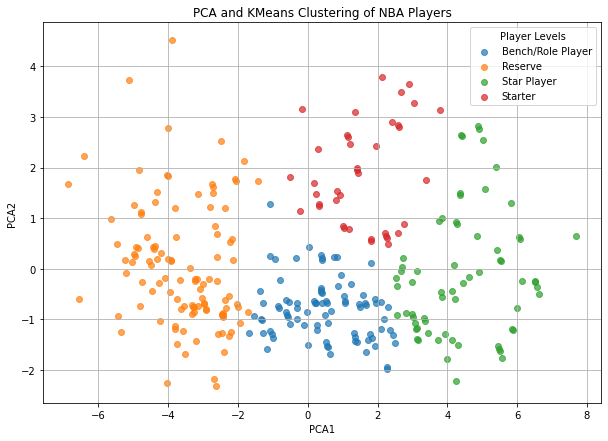

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Perform PCA
pca = PCA(n_components=2)  # Reduce to 2 components for visualization
pca_result = pca.fit_transform(df_scaled)

# Create a DataFrame for the PCA results
df_pca = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])

# Perform KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)  # 4 clusters for player levels
kmeans.fit(pca_result)
df_pca['Cluster'] = kmeans.labels_

# Add descriptive levels to clusters
cluster_map = {0: 'Starter', 1: 'Star Player', 2: 'Bench/Role Player', 3: 'Reserve'}
df_pca['Level'] = df_pca['Cluster'].map(cluster_map)

# Visualize the PCA results with clusters
plt.figure(figsize=(10, 7))
for level, group in df_pca.groupby('Level'):
    plt.scatter(group['PCA1'], group['PCA2'], label=level, alpha=0.7)
plt.title('PCA and KMeans Clustering of NBA Players')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title="Player Levels")
plt.grid(True)
plt.show()


In [ ]:
# Add Level to df_combined
df_combined["Level"] = df_pca["Level"]

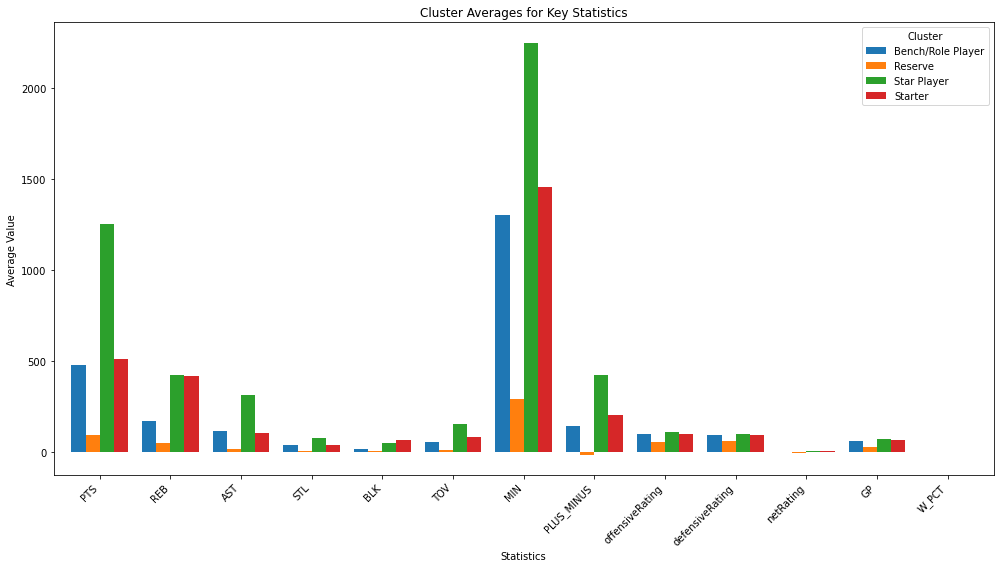

In [ ]:
# Cluster statistics visualization
stats = [
    "PTS", "REB", "AST", "STL", "BLK", "TOV", "MIN", 
    "PLUS_MINUS", "offensiveRating", "defensiveRating", 
    "netRating", "GP", "W_PCT"
]
cluster_averages = df_combined.groupby("Level")[stats].mean()

cluster_averages.T.plot(kind="bar", figsize=(14, 8), width=0.8)
plt.title("Cluster Averages for Key Statistics")
plt.ylabel("Average Value")
plt.xlabel("Statistics")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Cluster", loc="upper right")
plt.tight_layout()
plt.show()

In [ ]:
levels_by_team = df_combined[["SEASON", "TEAM_NAME_y", "PLAYER", "Level"]].sort_values(by="SEASON")

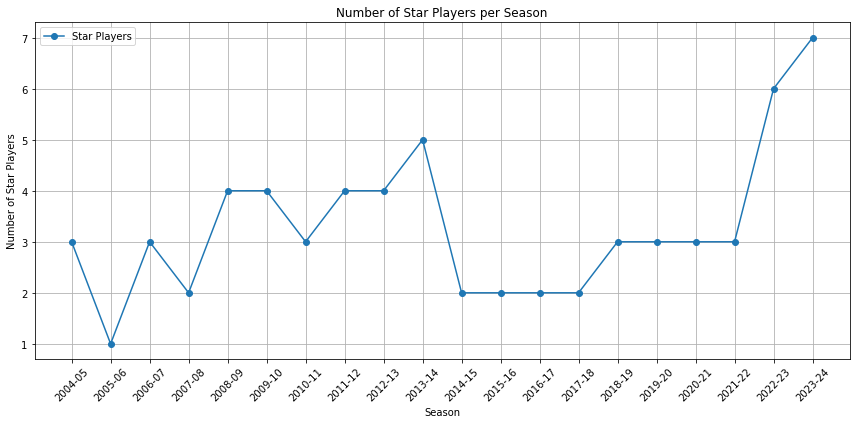

Level   SEASON  Bench/Role Player  Reserve  Star Player  Starter
0      2004-05                  5        5            3        1
1      2005-06                  3        6            1        3
2      2006-07                  7        3            3        2
3      2007-08                  6        6            2        1
4      2008-09                  3        6            4        1
5      2009-10                  3        5            4        1
6      2010-11                  4        5            3        3
7      2011-12                  3        7            4        1
8      2012-13                  4        5            4        1
9      2013-14                  5        3            5        2
10     2014-15                  5        5            2        3
11     2015-16                  5        6            2        2
12     2016-17                  5        3            2        5
13     2017-18                  4        3            2        6
14     2018-19                  5        7            3        1
15     2019-20                  5        8            3        2
16     2020-21                  4        9            3        1
17     2021-22                  7        3            3        3
18     2022-23                  2        8            6        0
19     2023-24                  2        8            7        0

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a pivot table to count players by Level for each season
level_counts = levels_by_team.pivot_table(
    index='SEASON', 
    columns='Level', 
    aggfunc='size', 
    fill_value=0
)

# Reset index for cleaner display
level_counts.reset_index(inplace=True)

# Create a line plot for "Star Player" counts across seasons
plt.figure(figsize=(12, 6))
plt.plot(level_counts['SEASON'], level_counts.get('Star Player', 0), marker='o', label='Star Players')
plt.title('Number of Star Players per Season')
plt.xlabel('Season')
plt.ylabel('Number of Star Players')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

level_counts


In [ ]:
df_combined.to_csv('df_combined.csv', index=False)

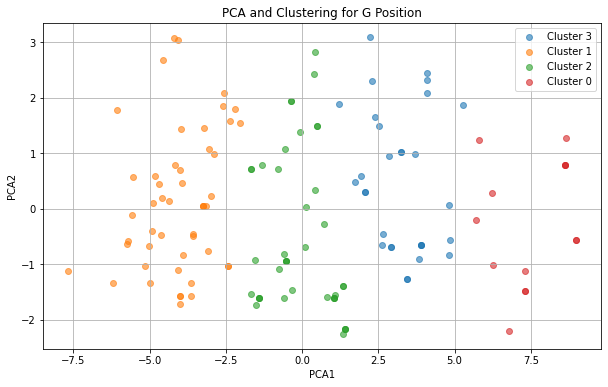

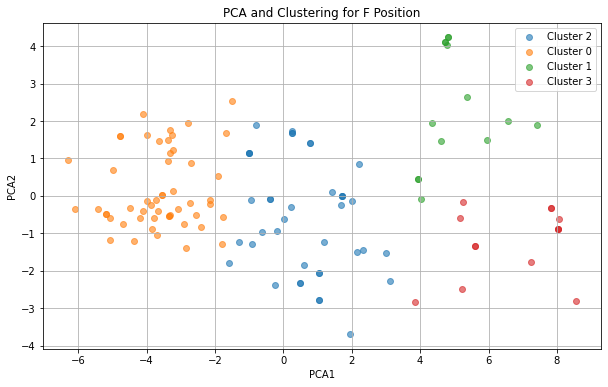

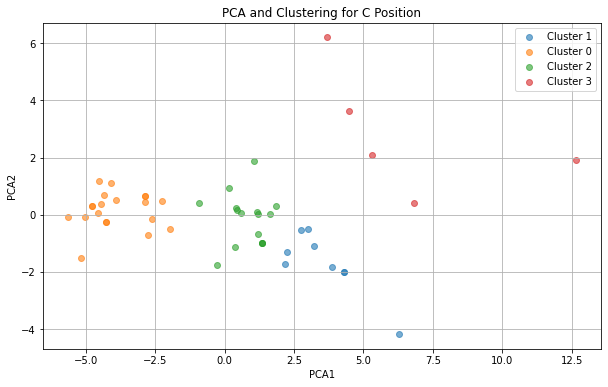

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Extract primary position (first character of POSITION column)
df_combined['Primary_Position'] = df_combined['POSITION'].str[0]

# Define features to use for clustering
features = [
    "PTS", "REB", "AST", "STL", "BLK", "TOV", "MIN", 
    "FGM", "FGA", "FG3M", "FG3A", "FTM", "FTA", "assistToTurnover",
    "FG_PCT", "FG3_PCT", "FT_PCT", "PLUS_MINUS", "usagePercentage",
    "trueShootingPercentage", "offensiveRating", "defensiveRating", 
    "netRating", "PIE", "HEIGHT", "WEIGHT"
]

# Dictionary to store results for each position
cluster_results = {}

# Process each position separately
for position in df_combined['Primary_Position'].unique():
    # Filter data for the current position
    position_data = df_combined[df_combined['Primary_Position'] == position]
    
    # Select and scale the relevant features
    position_features = position_data[features].dropna()
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(position_features)
    
    # Perform PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(scaled_features)
    
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=4, random_state=42)
    kmeans.fit(pca_result)
    
    # Create a DataFrame to store clustering results
    position_results = position_data.loc[position_features.index].copy()
    position_results['Cluster'] = kmeans.labels_
    
    # Store PCA results for visualization
    position_results['PCA1'] = pca_result[:, 0]
    position_results['PCA2'] = pca_result[:, 1]
    
    # Save results for the current position
    cluster_results[position] = position_results

    # Plot PCA results
    plt.figure(figsize=(10, 6))
    for cluster in position_results['Cluster'].unique():
        cluster_data = position_results[position_results['Cluster'] == cluster]
        plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f"Cluster {cluster}", alpha=0.6)
    plt.title(f"PCA and Clustering for {position} Position")
    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.legend()
    plt.grid(True)
    plt.show()

# Combine all results into a single DataFrame for further analysis
all_positions_results = pd.concat(cluster_results.values())

# # Save the results for download or inspection
# output_path = '/mnt/data/player_archetypes_by_position.csv'
# all_positions_results.to_csv(output_path, index=False)

# output_path


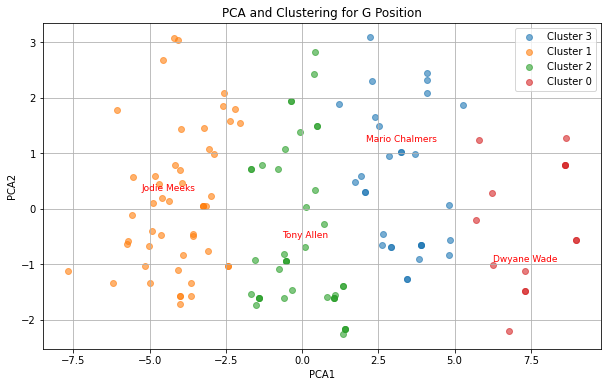

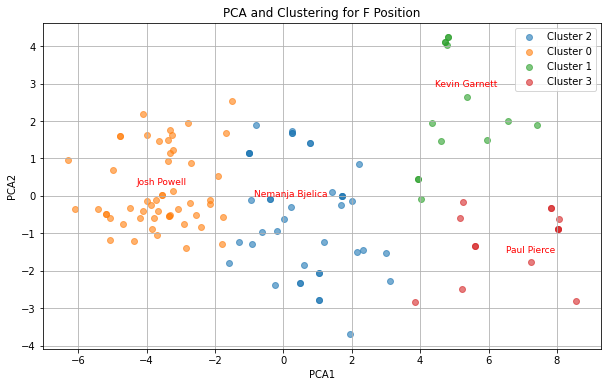

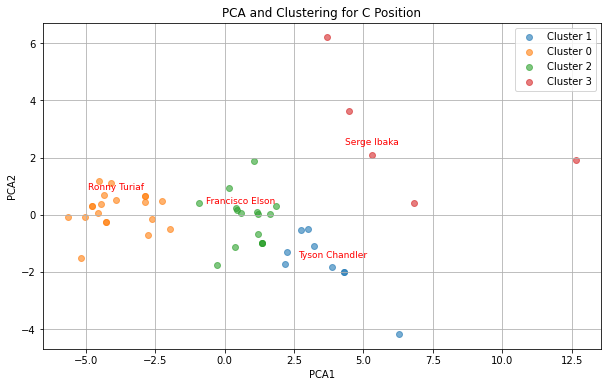

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# Extract primary position (first character of POSITION column)
df_combined['Primary_Position'] = df_combined['POSITION'].str[0]

# Define features to use for clustering
features = [
    "PTS", "REB", "AST", "STL", "BLK", "TOV", "MIN", 
    "FGM", "FGA", "FG3M", "FG3A", "FTM", "FTA", "assistToTurnover",
    "FG_PCT", "FG3_PCT", "FT_PCT", "PLUS_MINUS", "usagePercentage",
    "trueShootingPercentage", "offensiveRating", "defensiveRating", 
    "netRating", "PIE", "HEIGHT", "WEIGHT"
]

# Dictionary to store results for each position
cluster_results = {}

# Process each position separately
for position in df_combined['Primary_Position'].unique():
    # Filter data for the current position
    position_data = df_combined[df_combined['Primary_Position'] == position]
    
    # Select and scale the relevant features
    position_features = position_data[features].dropna()
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(position_features)
    
    # Perform PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(scaled_features)
    
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=4, random_state=42)
    kmeans.fit(pca_result)
    
    # Create a DataFrame to store clustering results
    position_results = position_data.loc[position_features.index].copy()
    position_results['Cluster'] = kmeans.labels_
    
    # Store PCA results for visualization
    position_results['PCA1'] = pca_result[:, 0]
    position_results['PCA2'] = pca_result[:, 1]
    
    # Save results for the current position
    cluster_results[position] = position_results

    # Calculate cluster centroids
    cluster_centroids = position_results.groupby('Cluster')[['PCA1', 'PCA2']].mean()
    
    # Find the player closest to each centroid
    distances = cdist(position_results[['PCA1', 'PCA2']], cluster_centroids)
    position_results['Distance_to_Centroid'] = distances.min(axis=1)
    
    # Identify central players
    central_players = position_results.loc[position_results.groupby('Cluster')['Distance_to_Centroid'].idxmin()]
    
    # Plot PCA results
    plt.figure(figsize=(10, 6))
    for cluster in position_results['Cluster'].unique():
        cluster_data = position_results[position_results['Cluster'] == cluster]
        plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f"Cluster {cluster}", alpha=0.6)
    
    # Annotate central players
    for _, player in central_players.iterrows():
        plt.annotate(
            player['PLAYER'], 
            (player['PCA1'], player['PCA2']), 
            textcoords="offset points", 
            xytext=(0, 10), 
            ha='center', 
            fontsize=9, 
            color='red'
        )
    
    plt.title(f"PCA and Clustering for {position} Position")
    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.legend()
    plt.grid(True)
    plt.show()

# Combine all results into a single DataFrame for further analysis
all_positions_results = pd.concat(cluster_results.values())

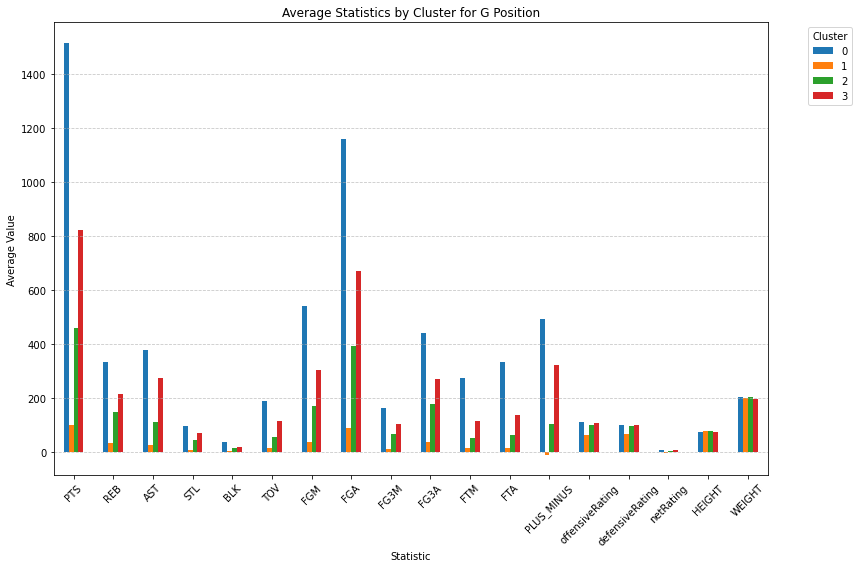

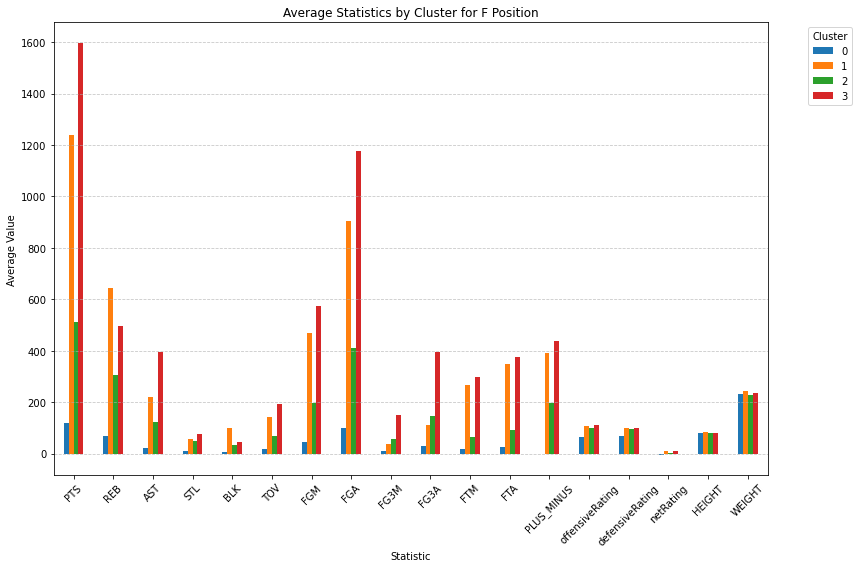

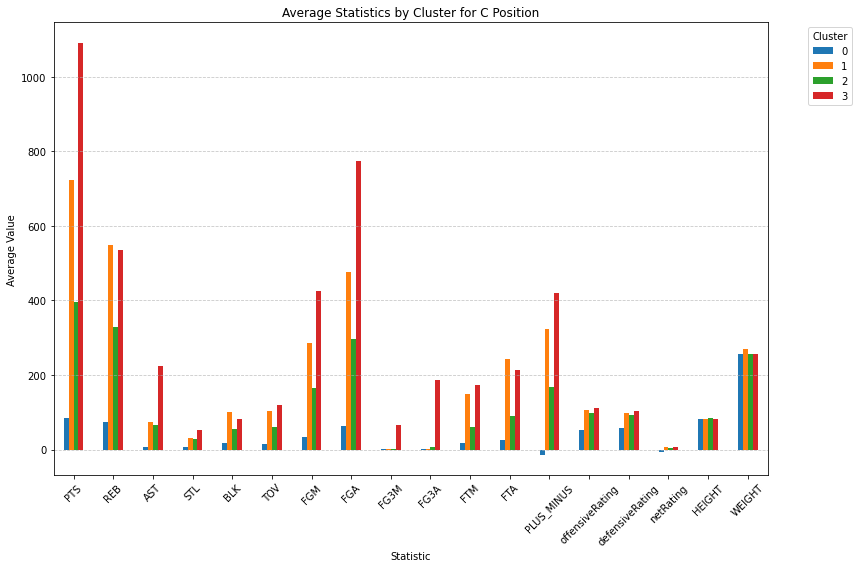

In [ ]:
# Analyze cluster statistics by position and visualize
positions = all_positions_results['Primary_Position'].unique()
relevant_stats = [
    "PTS", "REB", "AST", "STL", "BLK", "TOV",  
    "FGM", "FGA", "FG3M", "FG3A", "FTM", "FTA",
    "PLUS_MINUS",  "offensiveRating", "defensiveRating", 
    "netRating", "HEIGHT", "WEIGHT"
]

for position in positions:
    # Filter data for the current position
    position_data = all_positions_results[all_positions_results['Primary_Position'] == position]
    
    # Calculate average statistics for each cluster
    cluster_means = position_data.groupby('Cluster')[relevant_stats].mean()
    
    # Plot bar chart for the current position
    cluster_means.T.plot(kind='bar', figsize=(12, 8), title=f"Average Statistics by Cluster for {position} Position")
    plt.ylabel('Average Value')
    plt.xlabel('Statistic')
    plt.xticks(rotation=45)
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


In [ ]:
from IPython.display import display

# Prepare to store the unique central players for each position
unique_central_players = {}

# Process each position separately
for position in all_positions_results['Primary_Position'].unique():
    # Filter data for the current position
    position_data = all_positions_results[all_positions_results['Primary_Position'] == position]
    
    # Select relevant statistics for distance calculations
    position_features = position_data[relevant_stats].dropna()
    
    # Calculate centroids for each cluster
    cluster_centroids = position_features.groupby(position_data['Cluster']).mean()
    
    # Calculate distances from each player to their cluster centroid
    distances = cdist(position_features, cluster_centroids, metric='euclidean')
    position_data['Distance_to_Centroid'] = distances.min(axis=1)
    
    # For each cluster, find the top 3 players closest to the centroid
    position_central_players = []
    for cluster in cluster_centroids.index:
        cluster_players = position_data[position_data['Cluster'] == cluster]
        top_players = cluster_players.nsmallest(3, 'Distance_to_Centroid')[['PLAYER', 'TEAM_NAME_y', 'SEASON', 'Cluster', 'Distance_to_Centroid']]
        position_central_players.append(top_players)
    
    # Combine and remove duplicate player names for this position
    position_central_players_df = pd.concat(position_central_players).drop_duplicates(subset='PLAYER')
    unique_central_players[position] = position_central_players_df

# Display each position's table separately
for position, table in unique_central_players.items():
    print(f"Central Players for {position} Position:")
    display(table)
    print("\n")

Central Players for G Position:


/var/folders/rm/yg_gvh4d2v99cbbx0qwjg0qh0000gn/T/ipykernel_3010/1571547100.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  position_data['Distance_to_Centroid'] = distances.min(axis=1)


PLAYER            TEAM_NAME_y   SEASON  Cluster  \
252   Jaylen Brown         Boston Celtics  2023-24        0   
285   Jordan Poole  Golden State Warriors  2021-22        0   
174  Stephen Curry  Golden State Warriors  2017-18        0   
293    Sam Merrill        Milwaukee Bucks  2020-21        1   
213   Dion Waiters     Los Angeles Lakers  2019-20        1   
4      Sam Cassell         Boston Celtics  2007-08        1   
258     Damion Lee  Golden State Warriors  2021-22        2   
229      Ian Clark  Golden State Warriors  2016-17        2   
189  Avery Bradley     Los Angeles Lakers  2019-20        2   
48   Manu Ginobili      San Antonio Spurs  2013-14        3   

     Distance_to_Centroid  
252            243.499319  
285            306.321850  
174            362.277110  
293             47.988299  
213             56.359133  
4               69.241225  
258             79.416440  
229            119.949516  
189            120.427278  
48             136.013981



Central Players for F Position:


PLAYER            TEAM_NAME_y   SEASON  Cluster  \
272         Chris Boucher        Toronto Raptors  2018-19        0   
67       Brian Scalabrine         Boston Celtics  2007-08        0   
234  James Michael McAdoo  Golden State Warriors  2014-15        0   
57              Pau Gasol     Los Angeles Lakers  2009-10        1   
78             Chris Bosh             Miami Heat  2011-12        1   
226       Otto Porter Jr.  Golden State Warriors  2021-22        2   
193       Nemanja Bjelica  Golden State Warriors  2021-22        2   
45            James Posey         Boston Celtics  2007-08        2   
146          Kevin Durant  Golden State Warriors  2017-18        3   
205         Kawhi Leonard        Toronto Raptors  2018-19        3   

     Distance_to_Centroid  
272             60.905527  
67              67.046710  
234             69.149606  
57             186.523829  
78             204.148133  
226            119.251268  
193            135.608671  
45             156.582786  
146            254.576654  
205            274.009571



Central Players for C Position:


PLAYER            TEAM_NAME_y   SEASON  Cluster  \
269     Thomas Bryant         Denver Nuggets  2022-23        0   
121         DJ Mbenga     Los Angeles Lakers  2009-10        0   
56     Tyson Chandler       Dallas Mavericks  2010-11        1   
199  Tristan Thompson    Cleveland Cavaliers  2015-16        1   
5     Alonzo Mourning             Miami Heat  2005-06        1   
47    Francisco Elson      San Antonio Spurs  2006-07        2   
91      Zaza Pachulia  Golden State Warriors  2017-18        2   
168       Serge Ibaka        Toronto Raptors  2018-19        3   
77         Chris Bosh             Miami Heat  2012-13        3   
162       Brook Lopez        Milwaukee Bucks  2020-21        3   

     Distance_to_Centroid  
269             54.049580  
121             56.078984  
56             194.796155  
199            232.561356  
5              245.406789  
47              68.849395  
91              81.964164  
168            252.993482  
77             289.245929  
162            426.706417

In [ ]:
# Define a mapping of (Primary_Position, Cluster) to Archetype
archetype_mapping = {
    ('G', 0): 'Dynamic Scorer',       # Example: Guards in cluster 0
    ('G', 1): 'Streaky Shooter',       
    ('G', 2): '3-and-D Role Player',    
    ('G', 3): 'Playmaker',       
    ('F', 0): 'Hustler',              # Example: Forwards in cluster 0
    ('F', 1): 'Skilled Stretch Big',     
    ('F', 2): 'Versatile Big',         
    ('F', 3): 'Superstar Big',     
    ('C', 0): 'High-Energy Big',      # Example: Centers in cluster 0
    ('C', 1): 'Rim Protector',     
    ('C', 2): 'Role Player Big',   
    ('C', 3): 'All-Around Big',     
}

# Create the Archetype column using the mapping
all_positions_results['Archetype'] = all_positions_results.apply(
    lambda row: archetype_mapping.get((row['Primary_Position'], row['Cluster']), 'Unknown'), 
    axis=1
)

print(all_positions_results[['Primary_Position', 'Cluster', 'Archetype', 'PLAYER']])

    Primary_Position  Cluster            Archetype         PLAYER
0                  G        3            Playmaker    Gary Payton
4                  G        1      Streaky Shooter    Sam Cassell
10                 G        3            Playmaker     Jason Kidd
11                 G        2  3-and-D Role Player    Brent Barry
12                 G        2  3-and-D Role Player    Brent Barry
..               ...      ...                  ...            ...
250                C        0      High-Energy Big   Damian Jones
266                C        2      Role Player Big    Jordan Bell
269                C        0      High-Energy Big  Thomas Bryant
271                C        2      Role Player Big    Luke Kornet
286                C        0      High-Energy Big  Neemias Queta

[303 rows x 4 columns]


In [ ]:
from IPython.display import display, HTML

# Group data by season
seasons = all_positions_results['SEASON'].unique()

# Generate and display a table for each season
for season in seasons:
    # Filter data for the current season
    season_data = all_positions_results[all_positions_results['SEASON'] == season]
    
    # Select relevant columns
    season_table = season_data[['TEAM_NAME_y', 'PLAYER', 'Archetype', 'Primary_Position']]
    
    # Sort by team and position for clarity
    season_table = season_table.sort_values(by=['TEAM_NAME_y', 'Primary_Position'])
    
    # Display the table with a title
    display(HTML(f"<h3>Archetypes for Season {season}</h3>"))
    display(season_table.style.set_table_styles([{
        'selector': 'thead th',
        'props': [('background-color', '#f4f4f4'), ('font-weight', 'bold')]
    }]).set_caption(f"Archetypes of Players for Season {season}"))

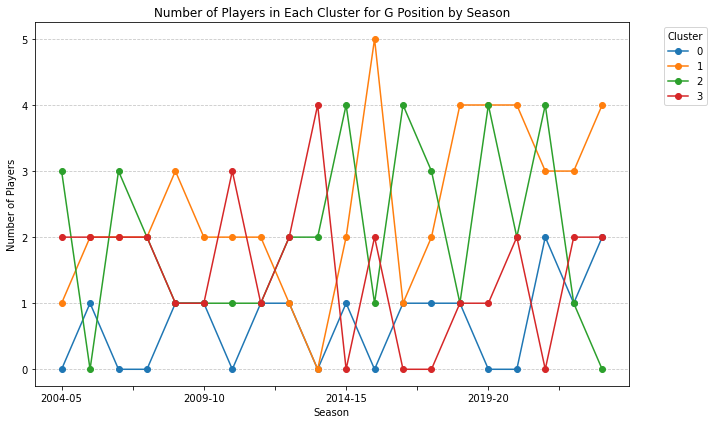

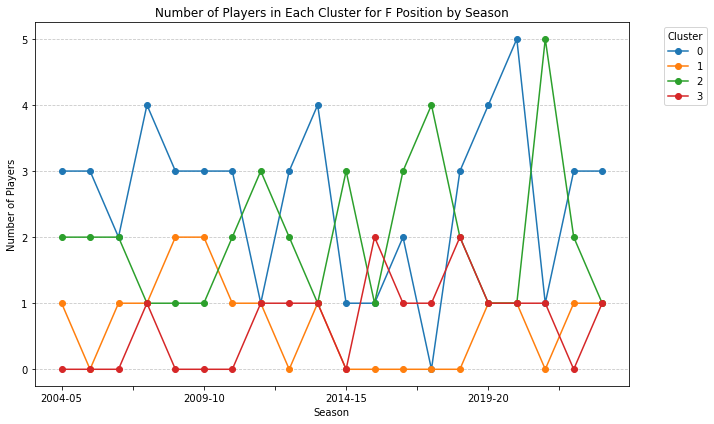

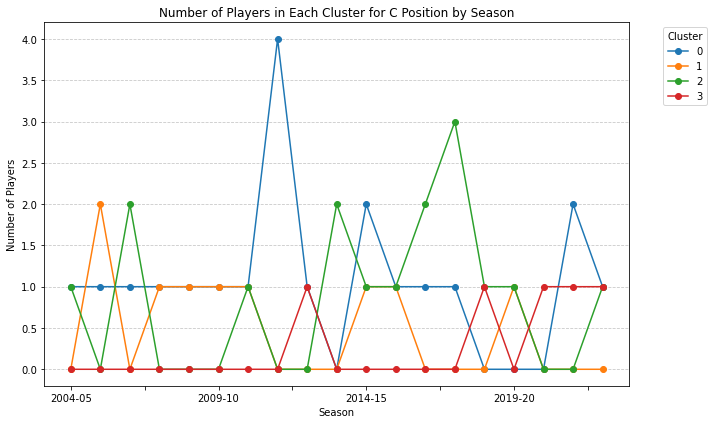

In [ ]:
# Prepare data for line charts
# Group by SEASON, Primary_Position, and Cluster to count players
cluster_counts = all_positions_results.groupby(['SEASON', 'Primary_Position', 'Cluster']).size().reset_index(name='Player_Count')

# Plot line charts for each position
positions = all_positions_results['Primary_Position'].unique()

for position in positions:
    # Filter data for the current position
    position_data = cluster_counts[cluster_counts['Primary_Position'] == position]
    
    # Pivot data for plotting
    position_pivot = position_data.pivot(index='SEASON', columns='Cluster', values='Player_Count').fillna(0)
    
    # Plot line chart
    position_pivot.plot(kind='line', figsize=(10, 6), marker='o')
    plt.title(f"Number of Players in Each Cluster for {position} Position by Season")
    plt.xlabel("Season")
    plt.ylabel("Number of Players")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

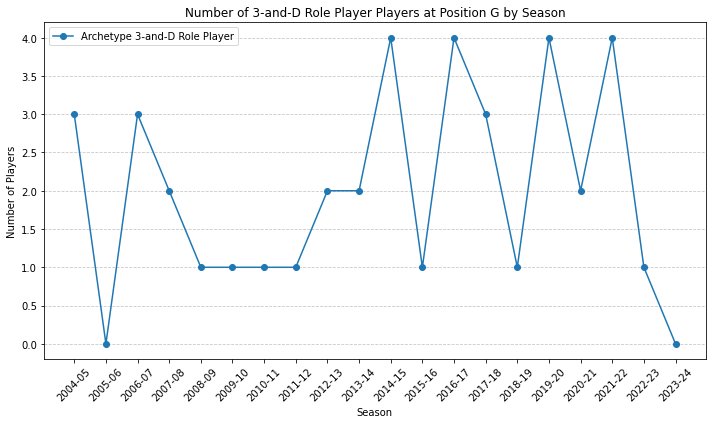

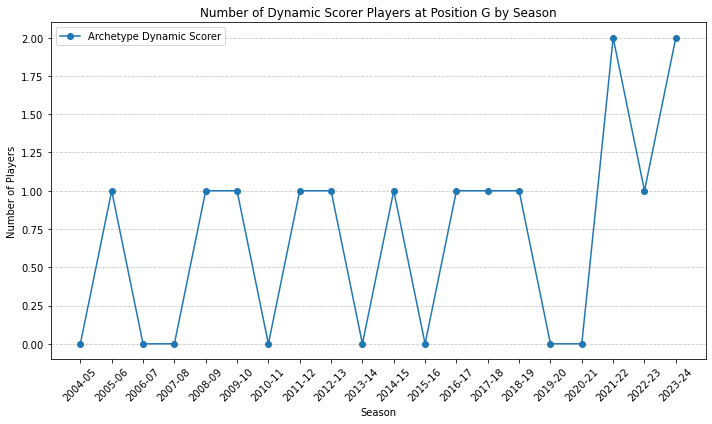

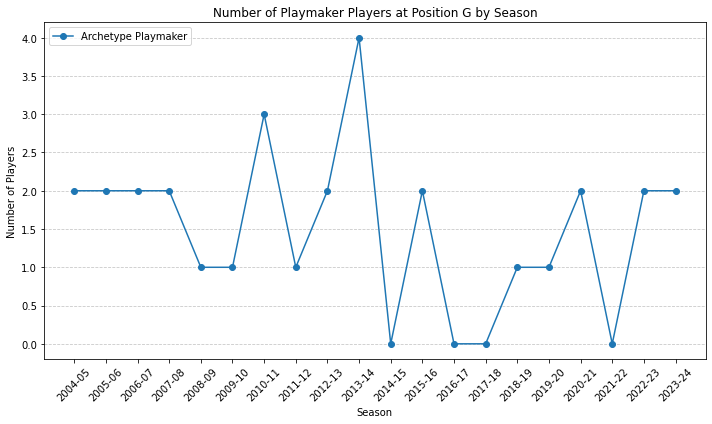

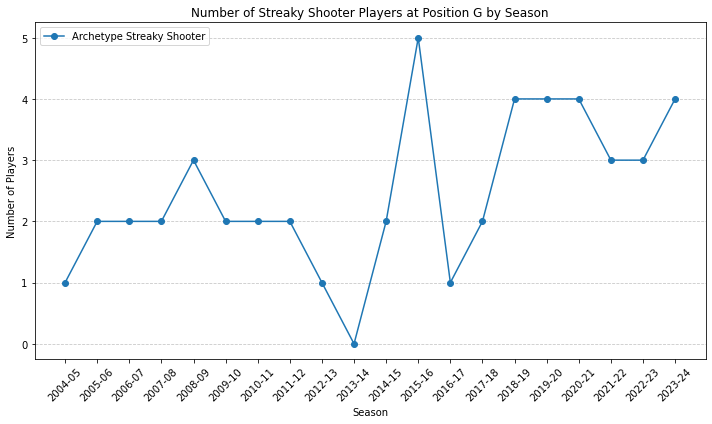

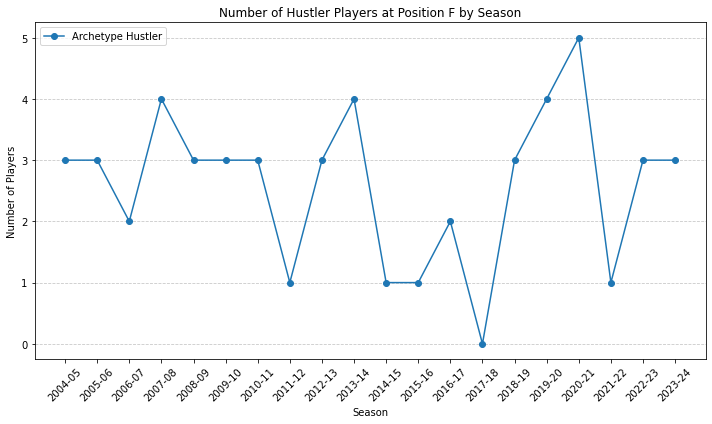

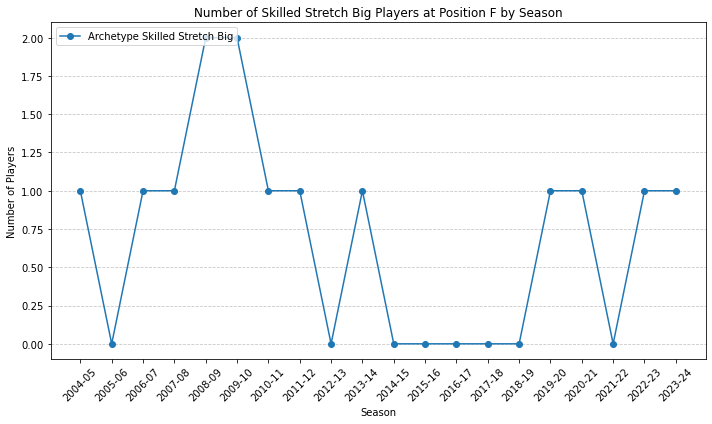

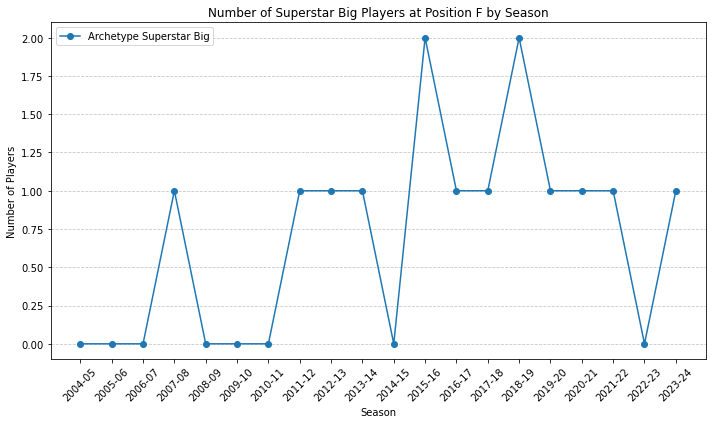

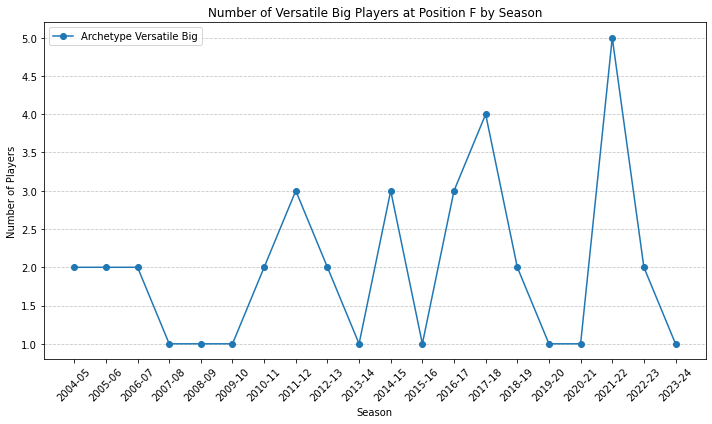

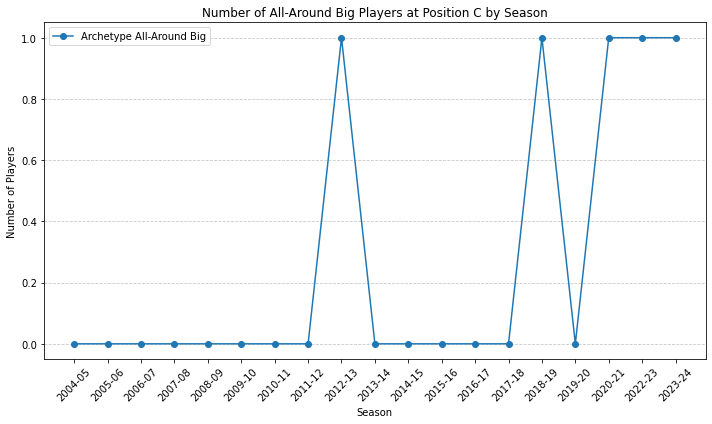

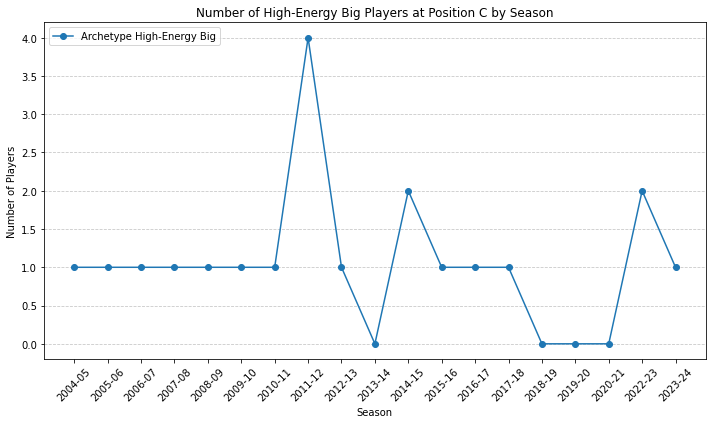

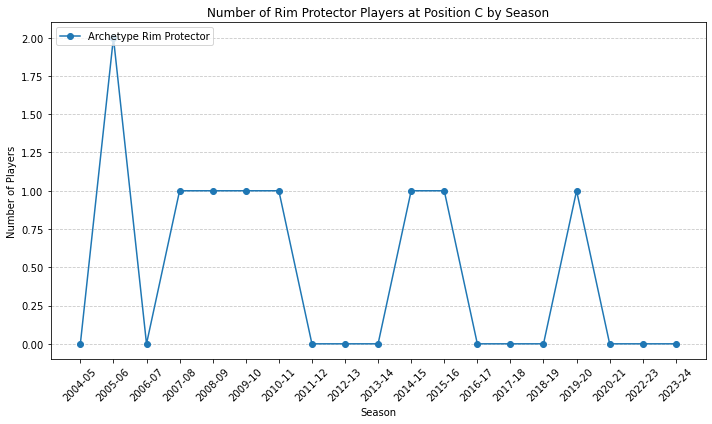

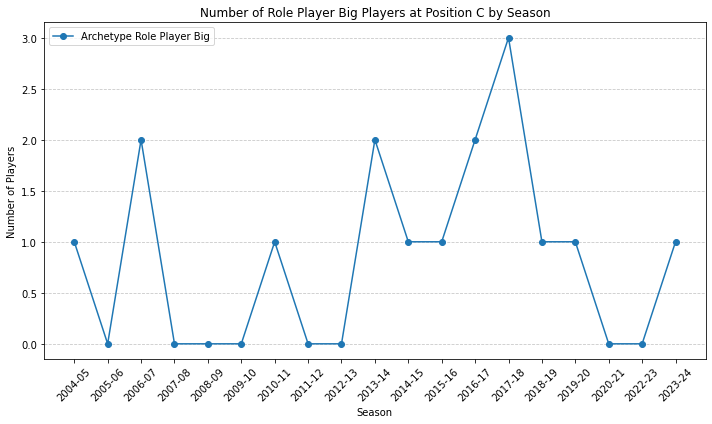

In [ ]:
archetype_counts = all_positions_results.groupby(['SEASON', 'Primary_Position', 'Archetype']).size().reset_index(name='Player_Count')


# Adjust line charts with raw player counts (no rolling averages) and rotated labels
for position in positions:
    # Filter data for the current position
    position_data = archetype_counts[cluster_counts['Primary_Position'] == position]
    
    # Pivot data for plotting
    position_pivot = position_data.pivot(index='SEASON', columns='Archetype', values='Player_Count').fillna(0)
    
    # Plot separate charts for each cluster
    for archetype in position_pivot.columns:
        plt.figure(figsize=(10, 6))
        plt.plot(position_pivot.index, position_pivot[archetype], marker='o', label=f"Archetype {archetype}")
        plt.title(f"Number of {archetype} Players at Position {position} by Season")
        plt.xlabel("Season")
        plt.ylabel("Number of Players")
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.xticks(rotation=45)  # Rotate x-axis labels
        plt.legend(loc='upper left')
        plt.tight_layout()
        plt.show()